<!-- IMPORTS -->

IMPORTS

In [1]:
from IPython import display as ipythondisplay
from torch import nn

from transformers import AutoTokenizer, AutoModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from transformers import BertModel, BertConfig, BertTokenizer
import albumentations as A
import cv2
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import time
import timm
import torch
import torch.nn.functional as F

c:\Users\haZAR\anaconda3\envs\pytorchgpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
##DATAFRAMES##

df = pd.read_csv("C:/Users/haZAR/Desktop/model_ws2/filtercaption (3).txt", sep=',')
df2 = pd.read_csv("C:/Users/haZAR/Desktop/model_ws2/output.txt", sep=',')

In [3]:
df2

,image,caption
0,Abalone_0002,Abalone
1,Abalone_0003,Abalone
2,Abalone_0004,Abalone
3,Abalone_0005,Abalone
4,Abalone_0007,Abalone
...,...,...
23479,Youtiao_0093,Youtiao
23480,Youtiao_0094,Youtiao
23481,Youtiao_0095,Youtiao
23482,Youtiao_0096,Youtiao


In [4]:
##PATHS##

image_path = "C:/Users/haZAR/Desktop/newdataset/ISIA_Food500/finetune_imagescopy"
captions_path = "C:/Users/haZAR/Desktop/model_ws2"
captions_path2 = "C:/Users/haZAR/Desktop/model_ws2"

CLASS FOR STTORING ALL

In [5]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    captions_path2 = captions_path2
    batch_size = 4
    num_workers = 0
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    # head_lr = 0.436
    factor = 0.4
    epochs = 27
    model_name = 'resnet101'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = device = torch.device("cpu")

    image_embedding = 2048
    text_encoder_model = 'google-bert/bert-base-uncased'
    text_embedding = 768
    text_tokenizer = 'google-bert/bert-base-uncased'
    max_length = 36
    pretrained = True
    trainable = True
    temperature = 1
    size =244
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.5038

In [6]:
##TRAIN TEST SPLIT FOR BOTH DATAFRAMES##

from sklearn.model_selection import train_test_split
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/filtercaption (3).txt") #instead of using + we cam use this too
    train, test = train_test_split(dataframe, test_size=.8, train_size=.2, shuffle=True, random_state=77,stratify=None)
    return train, test
testing_df , training_df = make_train_valid_dfs()

##TRAIN TEST SPLIT FOR BOTH DATAFRAMES##

def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path2}/output.txt") #instead of using + we cam use this too
    # print(dataframe)
    train, test = train_test_split(dataframe, test_size=.8, train_size=.2, shuffle=True, random_state=77,stratify=None)
    return train, test

testing_df2 , training_df2 = make_train_valid_dfs()

In [7]:
len(testing_df), len(training_df), len(testing_df2), len(training_df2)

(4696, 18788, 4696, 18788)

In [9]:
##DATASET LOADER HELPER##

import logging
# import torch
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and captions must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.skippedImgCount = 0
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        try:
            image = cv2.imread(CFG.image_path + "/" + self.image_filenames[idx] + '.jpg')
            if image is None:
                raise ValueError("Failed to read image from disk.")
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = self.transforms(image=image)['image']
            item['image'] = torch.tensor(image).permute(2, 0, 1).float()
            item['caption'] = self.captions[idx]

        except Exception as e:
            logging.error(f"Error processing image at index {idx}: {e}")
            self.skippedImgCount += 1
            # Skip this item and proceed to the next one
            return self.__getitem__(idx + 1)

        return item

    def __len__(self):
        return len(self.captions)




def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
                A.HorizontalFlip(p=0.34),
                A.ShiftScaleRotate(p=0.36),
                # A.RandomBrightnessContrast(p=0.2),
                # A.Sharpen(p=0.34)
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
                A.HorizontalFlip(p=0.34),
                A.ShiftScaleRotate(p=0.36),
                # A.RandomBrightnessContrast(p=0.2),
                # A.Sharpen(p=0.34)
            ]
        )

IMAGE ENCODER

In [10]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.fc = nn.Linear(CFG.image_embedding, CFG.image_embedding)
        self.gelu = nn.GELU()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        ) #maybe used as feature extracter
        for p in self.model.parameters():
            p.requires_grad = trainable #gradient will be calculated and back propogated

    def forward(self, x):
        # out = self.model(x)
        # out = self.fc(self.gelu(out))
        # print(out.shape)
        return self.model(x)

In [11]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images
        
    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    ph, pw = patch_size
    nh, nw = h // ph, w // pw

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches

In [12]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences
    
    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.linear = nn.Linear(token_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

    def __call__(self, batch):
        batch = patchify(batch, self.patch_size)

        b, c, nh, nw, ph, pw = batch.shape

        # Flattening the patches
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        batch = torch.reshape(batch, [b, nh * nw, ph * pw * c])

        batch = self.linear(batch)
        cls = self.cls_token.expand([b, -1, -1])
        emb = batch + self.pos_emb

        return torch.cat([cls, emb], axis=1)

In [13]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        """
        Args:
            img_size: Size of the image
            patch_size: Size of the patch
            n_channels: Number of image channels
            d_model: The number of features in the transformer encoder
            nhead: The number of heads in the multiheadattention models
            dim_feedforward: The dimension of the feedforward network model in the encoder
            blocks: The number of sub-encoder-layers in the encoder
            mlp_head_units: The hidden units of mlp_head
            n_classes: The number of output classes
        """
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        
        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax()

    def __call__(self, batch):
        print(batch.shape)

        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        print("before",batch.shape)
        return batch

TEXT ENCODER (BERT)

In [14]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=False):
        super().__init__()
        if pretrained:
            self.model = BertModel.from_pretrained(model_name)

        

        else:
            self.model = BertModel(config=BertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

COSINE SIMILARITY


In [15]:
def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    """Returns cosine similarity between x1 and x2, computed along dim."""
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

CUSTOM ACTIVATION

In [16]:
class ReluSIG(nn.Module):
    def __init__(self , embedding_dim):
        super().__init__()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        Relumoid = self.gelu(x)*(torch.sqrt(self.sigmoid(torch.square(x))))
        return Relumoid

In [17]:
class ReluSIG(nn.Module):
    def __init__(self , embedding_dim):
        super().__init__()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        Relumoid = self.gelu(x)*self.sigmoid(torch.square(x))
        return Relumoid

In [18]:
import torch
import torch.nn as nn

class Combinehead():
    def __init__(self, projection_dim , dropout = CFG.dropout):
        super(Combinehead, self).__init__()  # Correctly initialize the superclass
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.projection_dim = projection_dim
        self.dropout = dropout
        self.layer = nn.LayerNorm

        
    def reshape_tensor(self, input_tensor):
        batch_size, maps, features = input_tensor.shape
        # Calculate the new height and width as the square root of the first dimension
        new_height = new_width = int(torch.sqrt(torch.tensor(maps)))
    
        # Check if the first dimension is a perfect square
        if new_height * new_width != maps:
            raise ValueError("The first dimension of the tensor is not a perfect square.")
    
        # Reshape the tensor
        reshaped_tensor = input_tensor.view(batch_size, new_height, new_width, features)
        reshaped_tensor = reshaped_tensor.permute(0, 3, 1, 2)
    
        return reshaped_tensor
    
    def forward(self, x):
        x = self.reshape_tensor(x)
        pooled_tensor = self.pool(x)
        batch_size, channels, _, _ = pooled_tensor.size()
        features = channels * 1 * 1  # Calculate total number of features after pooling
        flattened_tensor = pooled_tensor.view(batch_size, features)


        return flattened_tensor


ATTENTION BLOCK

In [19]:
def Attention(q,k,v):
    k_transposed = torch.transpose(k, 1,0) #(4,2,160,64)
    scaled_dot_product = torch.matmul(q, k_transposed)
    dk = torch.tensor(k.size()[-1], dtype=torch.float32) #160
    scaled_attention_logits = scaled_dot_product / torch.sqrt(dk) #normalize
    attention_weights = F.softmax(scaled_attention_logits, dim=-1)

    output = torch.matmul(attention_weights, v)

    return attention_weights, output

In [20]:
class Mhattention():
    def __init__(self, embedding_dim ,num_heads,
                 projection_dim = 256
                 ):
        super(Mhattention, self).__init__()
        self.combine_all = Combinehead()
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        assert projection_dim % num_heads == 0
        self.depth = projection_dim // num_heads
        
        
        
    def split_heads(self, x, batch_size):
        x = x.reshape(batch_size,-1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)
        
    def combine_heads(self, x):
        x = x.permute(0, 2, 1, 3)
        batch_size, _, seq_len, depth = x.size()
        x = x.reshape(batch_size,-1 , self.projection_dim) 
        return x
    def forward(self,q,k,v):
        batch_size = q.size(0)
        q = self.split_heads(q, batch_size) #(4,2,160,64)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention_weights, output = Attention(q,k,v)
        output = self.combine_heads(output) #(4,64,320)
        # output = self.combine_all(output) #(4,320)
        return output


        

In [21]:
# q= torch.randn(4, 2, 64 , 160)
# k= torch.randn(4, 2, 64 , 160)
# v= torch.randn(4, 2, 36 , 160)
# attention_weights, output = Attention(q,k,v)
# print(attention_weights.shape)
# print(output.shape)

PROJECTION HEAD(WITH ATTENTION)
1. RELUSIG
2. DROPOUT *1
3. LAYERNORM *1

In [22]:

class crossattention(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim_att=256,
        dropout=CFG.dropout,
        projection_dim = CFG.projection_dim
    ):
        super().__init__()
        self.fc_q = nn.Linear(embedding_dim, projection_dim_att)
        self.fc_k = nn.Linear(embedding_dim, projection_dim_att)
        self.fc_v = nn.Linear(embedding_dim, projection_dim_att)
        # self.mha = Mhattention(embedding_dim=projection_dim_att, num_heads=1)
        self.dropout = nn.Dropout(dropout)
        self.layer = nn.LayerNorm(projection_dim_att)
        self.gelu = nn.GELU()
        self.gelusig = ReluSIG(projection_dim)
        
    def forward(self, x):
        q = self.fc_q(x)
        q = self.dropout(q)
        k = self.fc_k(x)
        k = self.dropout(k)
        v = self.fc_v(x)
        v = self.dropout(v)
        mha,out = Attention(q,k,v) #(4,64,320)
        # out1 = self.combine_all.forward(mha)
        out2=self.dropout(out)
        out2 = self.gelusig(out2)
        
        out2 = out2 + out #can change
        out2 = self.layer(out2)
        return out2
        


In [23]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout,
        cat = 256
    ):
        super().__init__()
        # self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.project = nn.Linear(embedding_dim, projection_dim)
        self.fc = nn.Linear(cat, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
        self.crossattention = crossattention(embedding_dim=embedding_dim)
        self.gelusig = ReluSIG(projection_dim)
        
    
    def forward(self, x):
        att = self.crossattention(x) #(4,256)
        project = self.project(x)        
        x = att + project #new change
        x = self.dropout(x)

        x = self.gelusig(x)
        
        # x = self.fc(x)
        x = x + project
        x = self.layer_norm(x)
        return x

In [24]:
t1 = torch.rand(4,320)
t2 = torch.rand(4,320)
t3 = torch.cat((t1,t2),-1)

In [25]:
print(t3.shape)

torch.Size([4, 640])


In [26]:
class cross(nn.Module):
    def __init__(self , embedding_dim , projection_dim = CFG.projection_dim , dropout = CFG.dropout):
        super(cross, self).__init__()
        self.change_q = nn.Linear(embedding_dim, projection_dim)
        self.change_k = nn.Linear(embedding_dim, projection_dim)
        self.project = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer = nn.LayerNorm(projection_dim)
        self.gelusig = ReluSIG(projection_dim)
        self.gelu = nn.GELU()
    def forward(self,x,y): #y----->(4,256) , x----->(4,260)
        changed_q = self.change_q(x)  # Use fc_q from crossattention
        changed_q = self.dropout(changed_q)
        changed_k = self.change_k(x)  # Use fc_k from crossattention
        changed_k = self.dropout(changed_k)
        changedy_v = y  # Use fc_k from crossattention
        
        att , out = Attention(changed_q,changed_k,changedy_v)
        out = self.dropout(out)
        out = self.gelusig(out)
        
        
        
        out = out + changedy_v #can used changedy_v instead of y
        out = self.layer(out)
        return out



    

In [27]:
class Projected_layer(nn.Module):
    def __init__(self,embedding_dim , project = CFG.projection_dim, dropout = CFG.dropout):
        super(Projected_layer,self).__init__()
        self.fc = nn.Linear(embedding_dim,project)
        self.drop = nn.Dropout(dropout)
        self.layer = nn.LayerNorm(project)
        self.gelu = nn.GELU()
    def forward(self,x):
        proj = self.fc(x)
        x = self.gelu(proj)
        x = self.drop(x)
        x = self.layer(x)
        return x

In [28]:
# class NormalProjection(nn.Module):
#     def __init__(self,image_embedding = 260 , projection_dim = 256 ):
#         super().__init__()
#         self.fc = nn.Linear(image_embedding, projection_dim)
#         self.relu = nn.ReLU()
#         self.gelu = nn.GELU()
#         self.dropout_2 = nn.Dropout(CFG.dropout)
#         self.layer_norm = nn.LayerNorm(projection_dim)
#     def forward(self,x):
#         l = self.fc(x)
#         x = self.dropout_2(l)
        
        
#         return x

In [29]:

# class crossattention(nn.Module):
#     def __init__(
#         self,
#         embedding_dim,
#         projection_dim_att=512,
#         dropout=CFG.dropout
#     ):
#         super().__init__()
#         self.fc_q = nn.Linear(embedding_dim, projection_dim_att)
#         self.fc_k = nn.Linear(embedding_dim, projection_dim_att)
#         self.fc_v = nn.Linear(embedding_dim, projection_dim_att)
#         self.mha = Mhattention(embedding_dim=projection_dim_att, num_heads=2)
#         self.dropout = nn.Dropout(dropout)
#         self.combine_all = Combinehead()
        
#     def forward(self, x):
#         q = self.fc_q(x)
#         k = self.fc_k(x)
#         v = self.fc_v(x)
#         mha = self.mha(q,k,v) #(4,64,320)
#         out1 = self.combine_all(out1) #(4,320)
#         return out1


In [29]:

# class ProjectionHead_cross(nn.Module):
#     def __init__(
#         self,
#         embedding_dimm,embedding_dimm1,
#         projection_dim=CFG.projection_dim,
#         dropout=CFG.dropout
#     ):
#         super().__init__()
#         self.fc_q = nn.Linear(embedding_dimm, projection_dim)
#         self.fc_k = nn.Linear(embedding_dimm, projection_dim)
#         self.fc_v = nn.Linear(embedding_dimm1, projection_dim)
#         self.gelu = nn.GELU()
#         self.fc = nn.Linear(projection_dim, projection_dim)
#         self.mha = Mhattention(embedding_dim=projection_dim, num_heads=2)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(projection_dim)
#         self.ReluSIG = ReluSIG(projection_dim)
#         self.combine_all = Combinehead()
        
#     def forward(self, x ,y):
#         q = self.fc_q(x)
#         k = self.fc_k(x)
#         v = self.fc_v(y)
#         zeros = torch.zeros(4,28,256).to(CFG.device)
#         v = torch.cat((v,zeros),1)
#         # proj = self.projection(x) #(4,64,320)
#         mha = self.mha(q,k,v) #(4,64,320)
#         mha = self.dropout(mha)
#         out1 = mha + v
#         out1 = self.layer_norm(out1)
#         out1 = self.combine_all(out1) #(4,320)
#         ffn_out = self.fc(out1)
#         ffn_out = self.gelu(ffn_out)
#         ffn_out = self.dropout(ffn_out)
#         out2 = ffn_out + out1
#         out2 = self.layer_norm(out2)
        
#         return out2


MODEL ACHITECTURE (CLIP)

In [30]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.pro = Projected_layer(embedding_dim=260)
        self.temperature = temperature
        # self.normalprojection = NormalProjection()

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # text_class_features = self.text_encoder(
        #     input_ids=batch1["input_ids"], attention_mask=batch1["attention_mask"]
        #     )
        # cross_img = self.cross_img(image_features)
        # cross_text = self.cross_text(text_features)
    
        
        # text_class_embeddings = self.text_projection(text_class_features)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        


        # image_embeddings = self.image_projection(image_features)
        # text_embeddings = self.text_projection(text_features)
    
        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        visual_enhance_q = torch.cat([image_embeddings,logits], dim=1)
        visual_enhance_q = self.pro(visual_enhance_q)
        

        # print(visual_enhance_q.shape)
        # visual_q_proj = visual_enhance_q.view(4, 320)
        # visual_q_proj = self.normalprojection(visual_enhance_q)
        # cross_attention_wt_t,cross_attention_out_t = Attention(visual_enhance_q, visual_enhance_q , text_embeddings )
        # cross_attention_wt_i,cross_attention_out_i = Attention(visual_enhance_q, visual_enhance_q , image_embeddings )

        # similarity_img = torch.cat([visual_q_proj, cross_attention_out], dim=1)
        # similarity_text = torch.cat([txt_embeddings, cross_attention_out], dim=1)
        # logits_new = (cross_attention_out_i @ cross_attention_out_t.T) / self.temperature

        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        # print(targets.shape)
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [31]:
class proj(nn.Module):
    def __init__(self,embedding_dim = 260 ,projection_dim = CFG.projection_dim):
        super(proj , self)
        self.fc = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(CFG.dropout)
        self.layer = nn.LayerNorm(projection_dim)
    def forward(self,x):
        x = self.fc(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.layer(x)
        return x

In [30]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        # self.image_encoder =ViT(img_size = (244, 244),patch_size = (4, 4),n_channels = 3,
        #                            d_model = 768,nhead = 1,dim_feedforward = 2048,
        #                            blocks = 8,mlp_head_units = [512, 512],n_classes = 1,)
        self.cross = cross(embedding_dim = 260)
        self.temperature = temperature
        # self.normalprojection = NormalProjection()

    def forward(self, batch):
        # print(batch1)
        # print(batch['image'].shape)
        # print(batch1['input_ids'].shape)
        # print(batch1['attention_mask'].shape)
        # print(batch1['token_type_ids'].shape)
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # text_class_features = self.text_encoder(
        #     input_ids=batch1["input_ids"], attention_mask=batch1["attention_mask"]
        #     )
        # cross_img = self.cross_img(image_features)
        # cross_text = self.cross_text(text_features)
    
        
        # text_class_embeddings = self.text_projection(text_class_features)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)
        


        # image_embeddings = self.image_projection(image_features)
        # text_embeddings = self.text_projection(text_features)
    
        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature

        visual_enhance_q = torch.cat([image_embeddings,logits], dim=1) #(4,260)
        cross_txt = self.cross(visual_enhance_q,text_embeddings)

        logits_s1 = (image_embeddings @ cross_txt.T) / self.temperature

        text_enhance_q = torch.cat([text_embeddings,logits_s1], dim=1)
        cross_img = self.cross(text_enhance_q,image_embeddings)
        
        logits_s2 = (cross_img @ text_embeddings.T) / self.temperature
        logits_new = (logits_s1 + logits_s2) / 2.0
#other apprach shoucld be trried instead if just progressive
        
        # print(visual_enhance_q.shape)
        # visual_q_proj = visual_enhance_q.view(4, 320)
        # visual_q_proj = self.normalprojection(visual_enhance_q)
        # cross_attention_wt_t,cross_attention_out_t = Attention(visual_enhance_q, visual_enhance_q , text_embeddings )
        # cross_attention_wt_i,cross_attention_out_i = Attention(visual_enhance_q, visual_enhance_q , image_embeddings )

        # similarity_img = torch.cat([visual_q_proj, cross_attention_out], dim=1)
        # similarity_text = torch.cat([txt_embeddings, cross_attention_out], dim=1)
        # logits_new = (cross_attention_out_i @ cross_attention_out_t.T) / self.temperature

        images_similarity = cross_img @ cross_img.T
        texts_similarity = cross_txt @ cross_txt.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        # print(targets.shape)
        texts_loss = cross_entropy(logits_new, targets, reduction='none')
        images_loss = cross_entropy(logits_new.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [31]:
#check for hidden layer and input

DATALOADER

In [32]:

def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    
    )
    return dataloader

GRAPH PLOTTER

In [33]:
class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [34]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

TRAINING BLOCK

In [35]:
import torchsummary

In [36]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.03)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)

In [35]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    history = []
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)
        history.append(loss.cpu().detach().numpy().mean())

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    plotter.plot(history)
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter






def main():
    train_df = training_df 
    valid_df = testing_df

    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr}
    ]
    # optimizer = torch.optim.AdamW(params , weight_decay=0.02525)
    optimizer = torch.optim.AdamW(params , weight_decay=0.027137)

    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )

    #wt decay kum next time dropout kum karo
    step = "epoch"

    best_loss = float('inf')

    train_history = []
    valid_history = []
    for epoch in range(CFG.epochs): 
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        train_history.append(train_loss.avg)
        model.eval()
        torch.save(model.state_dict(), "temp.pt")
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
            valid_history.append(valid_loss.avg)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)
    print(f"CAREFUL! I had to skip {train_loader.dataset.skippedImgCount} to finish. This introduces heavy bias to whatever dataset[0] was at the time of training")    

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_history, label='Training loss')
    plt.plot(valid_history, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

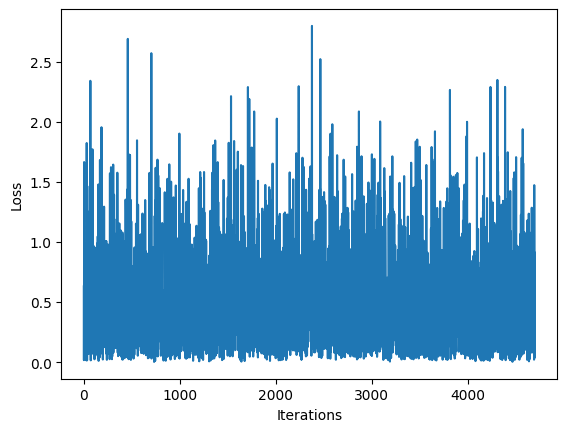

  9%|▉         | 110/1174 [00:13<02:24,  7.37it/s, valid_loss=0.675]ERROR:root:Error processing image at index 445: Failed to read image from disk.
ERROR:root:Error processing image at index 447: Failed to read image from disk.
 27%|██▋       | 318/1174 [00:37<01:25, 10.07it/s, valid_loss=0.68] ERROR:root:Error processing image at index 1272: Failed to read image from disk.
ERROR:root:Error processing image at index 1273: Failed to read image from disk.
ERROR:root:Error processing image at index 1273: Failed to read image from disk.
 34%|███▎      | 395/1174 [00:47<01:43,  7.53it/s, valid_loss=0.667]ERROR:root:Error processing image at index 1587: Failed to read image from disk.
ERROR:root:Error processing image at index 1588: Failed to read image from disk.
 35%|███▌      | 412/1174 [00:49<01:24,  9.01it/s, valid_loss=0.672]ERROR:root:Error processing image at index 1648: Failed to read image from disk.
ERROR:root:Error processing image at index 1650: Failed to read image from disk.
 

Saved Best Model!
Epoch: 13


  0%|          | 1/4697 [00:00<15:31,  5.04it/s, lr=0.0001, train_loss=0.211]ERROR:root:Error processing image at index 17597: Failed to read image from disk.
ERROR:root:Error processing image at index 12640: Failed to read image from disk.
  0%|          | 3/4697 [00:00<15:42,  4.98it/s, lr=0.0001, train_loss=0.694]ERROR:root:Error processing image at index 9222: Failed to read image from disk.
ERROR:root:Error processing image at index 17417: Failed to read image from disk.
  1%|          | 52/4697 [00:11<16:26,  4.71it/s, lr=0.0001, train_loss=0.419]ERROR:root:Error processing image at index 2300: Failed to read image from disk.
ERROR:root:Error processing image at index 3525: Failed to read image from disk.
  1%|▏         | 61/4697 [00:13<18:51,  4.10it/s, lr=0.0001, train_loss=0.419]ERROR:root:Error processing image at index 5280: Failed to read image from disk.
ERROR:root:Error processing image at index 14087: Failed to read image from disk.
  2%|▏         | 75/4697 [00:16<15:27,

KeyboardInterrupt: 

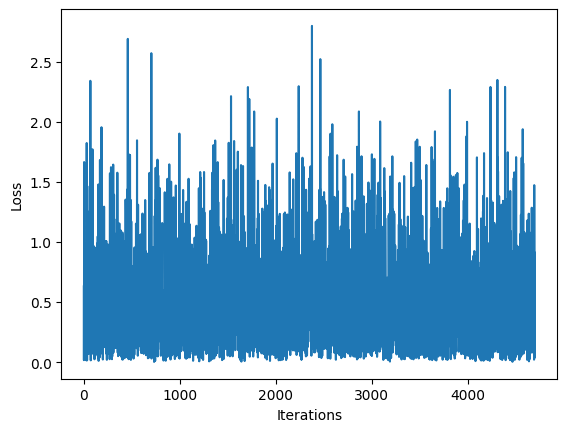

In [36]:
main()


In [ ]:
#swap t numbers
a = 10
b = 20 
c = a
a = b
a = c
print(a)
print(b)


SAVING MODEL

In [2]:
!cp -r './best.pt' C:/Users/haZAR/Desktop/model_ws2/modelbha23.pt 
# !cp -r './best.pt' C:/Users/haZAR/Desktop/model_ws2/modelbha21.pt 

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [41]:
import shutil

# copy the file
shutil.copy('./best.pt', 'C:/Users/haZAR/Desktop/model_ws2/modelbha204.pt')

'C:/Users/haZAR/Desktop/model_ws2/modelbha204.pt'

EVAlUATIONS STARTS


In [11]:
import torch

# Assuming your tensor is named 'tensor'
tensor = torch.randn(4, 64, 320)

# Slicing to extract the dimensions you want
sliced_tensor = tensor[:, 0, :]

# Reshaping to desired shape
reshaped_tensor = sliced_tensor.reshape(4, -1)

# Print the shape of the reshaped tensor
print(reshaped_tensor.shape)

torch.Size([4, 320])


1. FUNCTION FOR GETTING EMBEDDINGS

In [35]:
def get_image_embeddings(valid_df, model_path): #image embedding in list
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    # tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    valid_loader = build_loaders(testing_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            # cross = model.cross_img(image_features)
            image_embeddings = model.image_projection(image_features)
            
             
            # image_embeddings = image_embeddings + cross
            
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

def get_text_embeddings(valid_df, model_path): #text embedding in list
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    # tokenizer = AutoTokenizer.from_pretrained(CFG.clinical_encoder_model)
    valid_loader = build_loaders(testing_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            text_features = model.text_encoder(
                input_ids=batch["input_ids"].to(CFG.device), attention_mask=batch["attention_mask"].to(CFG.device)
            )
            # cross = model.cross_text(text_features)
            text_embeddings = model.text_projection(text_features)
            # text_embeddings = text_embeddings + cross
            valid_text_embeddings.append(text_embeddings)
    return model, torch.cat(valid_text_embeddings)

In [36]:
valid_df = testing_df

GETTING IMAGE EMBEDDINGS

In [37]:
model, image_embeddings = get_image_embeddings(valid_df, 'C:/Users/haZAR/Desktop/model_ws2/modelbha194.pt')


  5%|▍         | 58/1174 [00:07<01:19, 13.97it/s]ERROR:root:Error processing image at index 234: Failed to read image from disk.
ERROR:root:Error processing image at index 236: Failed to read image from disk.
  9%|▉         | 111/1174 [00:11<01:10, 15.04it/s]ERROR:root:Error processing image at index 445: Failed to read image from disk.
ERROR:root:Error processing image at index 447: Failed to read image from disk.
 27%|██▋       | 318/1174 [00:27<00:55, 15.39it/s]ERROR:root:Error processing image at index 1272: Failed to read image from disk.
ERROR:root:Error processing image at index 1273: Failed to read image from disk.
ERROR:root:Error processing image at index 1273: Failed to read image from disk.
 32%|███▏      | 373/1174 [00:31<01:01, 12.95it/s]ERROR:root:Error processing image at index 1494: Failed to read image from disk.
ERROR:root:Error processing image at index 1497: Failed to read image from disk.
 34%|███▎      | 395/1174 [00:34<01:17, 10.01it/s]ERROR:root:Error processin

GETTING TEXT EMBEDDINGS

In [38]:
model, text_embeddings = get_text_embeddings(valid_df, 'C:/Users/haZAR/Desktop/model_ws2/modelbha194.pt')


  4%|▎         | 44/1174 [00:03<01:33, 12.04it/s]ERROR:root:Error processing image at index 179: Failed to read image from disk.
ERROR:root:Error processing image at index 185: Failed to read image from disk.
  5%|▍         | 58/1174 [00:04<01:27, 12.72it/s]ERROR:root:Error processing image at index 234: Failed to read image from disk.
ERROR:root:Error processing image at index 236: Failed to read image from disk.
  9%|▉         | 111/1174 [00:08<01:14, 14.25it/s]ERROR:root:Error processing image at index 445: Failed to read image from disk.
ERROR:root:Error processing image at index 447: Failed to read image from disk.
 23%|██▎       | 272/1174 [00:21<00:59, 15.13it/s]ERROR:root:Error processing image at index 1090: Failed to read image from disk.
ERROR:root:Error processing image at index 1094: Failed to read image from disk.
 27%|██▋       | 318/1174 [00:23<00:55, 15.55it/s]ERROR:root:Error processing image at index 1272: Failed to read image from disk.
ERROR:root:Error processing i

FINDING MATCHES FROM IMAGE(TASK
)

In [39]:
def find_matches_from_image(model, text_embeddings, image_query, captions, n=9):
    
    image = cv2.imread(CFG.image_path+"/"+image_query+'.jpg')
    if image is None:
      print("GDRIVE DIDN'T READ AGAIN!")
      return 'NO_IMG_FOUND'

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)

    image = get_transforms("train")(image=image)['image']
    # plt.imshow(image)

    # Dymb loader
    tokenizer = AutoTokenizer.from_pretrained(CFG.text_tokenizer)
    dummy_df = pd.DataFrame.from_dict({"image": [image_query], "caption":[""]})
    dumb_loader = build_loaders(dummy_df, tokenizer, mode="train")

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dumb_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            # cross = model.cross_img(image_features)
            image_embeddings = model.image_projection(image_features) 
            # image_embeddings = image_embeddings + cross

    image_embeddings_n = F.normalize(image_embeddings[0], p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = image_embeddings_n @ text_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [captions[idx] for idx in indices[::5]]
    
    return matches

FINDING MATCHES FROM TEXT

In [40]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = BertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # cross = model.cross_text(text_features)
        text_embeddings = model.text_projection(text_features)
        # text_embeddings = text_embeddings + cross

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(CFG.image_path + "/" + match + ".jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

TRIAL(TEXT TO IMG)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


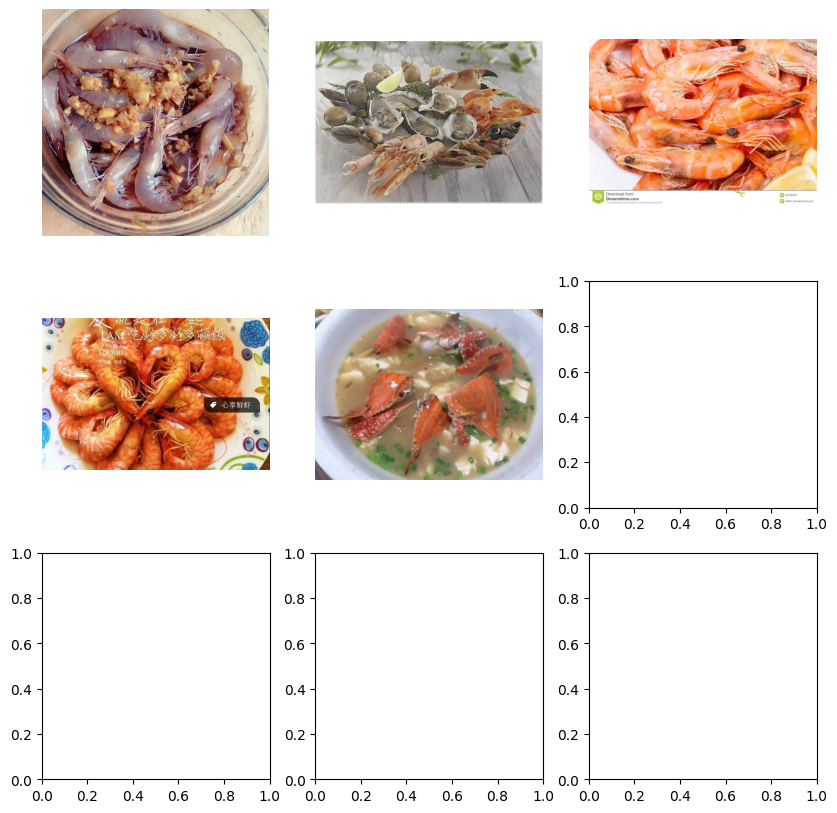

In [41]:
find_matches(model,
             image_embeddings,
             query="shrimps",
             image_filenames=valid_df['image'].values,
             n=9)

NLTK STUFF

In [42]:
import nltk
nltk.download('wordnet')
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu as BleuCoco
from pycocoevalcap.meteor.meteor import Meteor as MeteorCoco
from pycocoevalcap.rouge.rouge import Rouge as RougeCoco
from pycocoevalcap.cider.cider import Cider

import matplotlib.pyplot as plt
import pandas as pd

class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        scorers = [
            (BleuCoco(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (MeteorCoco(),"METEOR"),
            (RougeCoco(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

class EvaluationServer:
  def __init__(self):
    self.last_idx = 0
    self.groundtruths = dict()
    self.hypothesis = dict()

  def add(self, caption, matches):
    print(f'Adding caption: {self.last_idx}  to evaluator')
    start_idx = self.last_idx
    for i, match in enumerate(matches):
      idx = start_idx + i
      self.groundtruths[idx] = [{'image': idx, 'caption': caption}]
      self.hypothesis[idx] = [{'image': idx, 'caption': match}]
      self.last_idx += 1

  def present_metrics(self):
    print(f'Calculating scores for all {self.last_idx} captions:\n')
    rng = range(self.last_idx)
    evalObj = COCOEvalCap(rng,self.groundtruths,self.hypothesis)
    evalObj.evaluate()
    scores = evalObj.eval

    df = pd.DataFrame(scores, columns=scores.keys(), index=['one'])

    fig, ax = plt.subplots() 

    # Hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    print('Model scores using Microsofts Coco Evaluation Server:')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haZAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


EVALUATION METRICS DEFINED

In [43]:
from rouge import Rouge
from nltk.tokenize import TreebankWordTokenizer
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.cider.cider import Cider
import matplotlib.pyplot as plt
import pandas as pd
import cv2

plt.rcParams['figure.figsize'] = [20, 7]

def tokenize(s):
  return TreebankWordTokenizer().tokenize(s)

def get_bleu(query, groundtruth):
    reference = [tokenize(groundtruth)]
    candidate = tokenize(query)
    bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu_2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
    bleu_3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33))
    bleu_4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    return {"bleu_1": bleu_1, "bleu_2": bleu_2, "bleu_3": bleu_3, "bleu_4": bleu_4}

def get_rouge(query, groundtruth, variant="rouge-l", measure="f"):
    rouge = Rouge()
    rouge_scores = rouge.get_scores(query, groundtruth)
    return rouge_scores[0][variant][measure]


def get_meteor(query, groundtruth):
    hypothesis = [tokenize(query)]
    reference = tokenize(groundtruth)
    return meteor_score(hypothesis, reference)

# Somethings wrong:: https://gistgithub..com/kracwarlock/c979b10433fe4ac9fb97
# got 0.0
def get_cider(query, groundtruth):
    tokenizer = PTBTokenizer()
    gts  = tokenizer.tokenize({0: [{"image": 0, "caption": groundtruth}]})
    res = tokenizer.tokenize({0: [{"image": 0, "caption": query}]})
    cider = Cider()
    return cider.compute_score(gts,res)

def get_scores(query, groundtruth):
    scores = dict()
    for k, v in get_bleu(query, groundtruth).items():
        scores[k] = v
    scores["rouge-l"]  = get_rouge(query, groundtruth)
    scores["meteor"] = get_meteor(query, groundtruth)
    # vale, arr = get_cider(query, groundtruth)
    return scores

def present_scores(imagename, caption, matches):
    headers = []
    scores = []

    print('Recomended captions:\n')

    for match in matches:

      score = get_scores(match, caption)
      scores.append(score)
      headers = score.keys()

      print(f'\t- {match}')

    print('Scores for every recommended caption:\n')

    # Set scores dataframe
    df = pd.DataFrame(scores, columns=headers, index=matches)
    df.update(df.applymap('{:.4f}'.format))

    # Create table
    fig, ax = plt.subplots(2,1)

    # Hide axes
    fig.patch.set_visible(False)
    ax[1].axis('off')
    ax[1].axis('tight')
    # ax[2].axis('off')
    # ax[2].axis('tight')

    # mdf = pd.DataFrame(df.index, columns=["Matches"])

    # Create table
    # table = ax[1].table(cellText=mdf.values, colLabels=mdf.columns, loc='center')
    table = ax[1].table(cellText=df.values, colLabels=df.columns, loc='center')

    # Create image
    # image = cv2.imread(CFG.image_path /{imagename}")
    image = cv2.imread(CFG.image_path+"/"+imagename+'.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    ax[0].axis('off')
    plt.show()

RESULTS

Image inserted: Botifarra_0024
Real caption: one fried botifarra and white beams sprinkled with some green herbs



100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


Recomended captions:

	- pot roast with reddish brown skin and green beans soaked in browned broth
	- baingan bharta with chopped green onion on the top and some steamed white rice topped with chopped onion next to it on a white plate
	- as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 
Scores for every recommended caption:



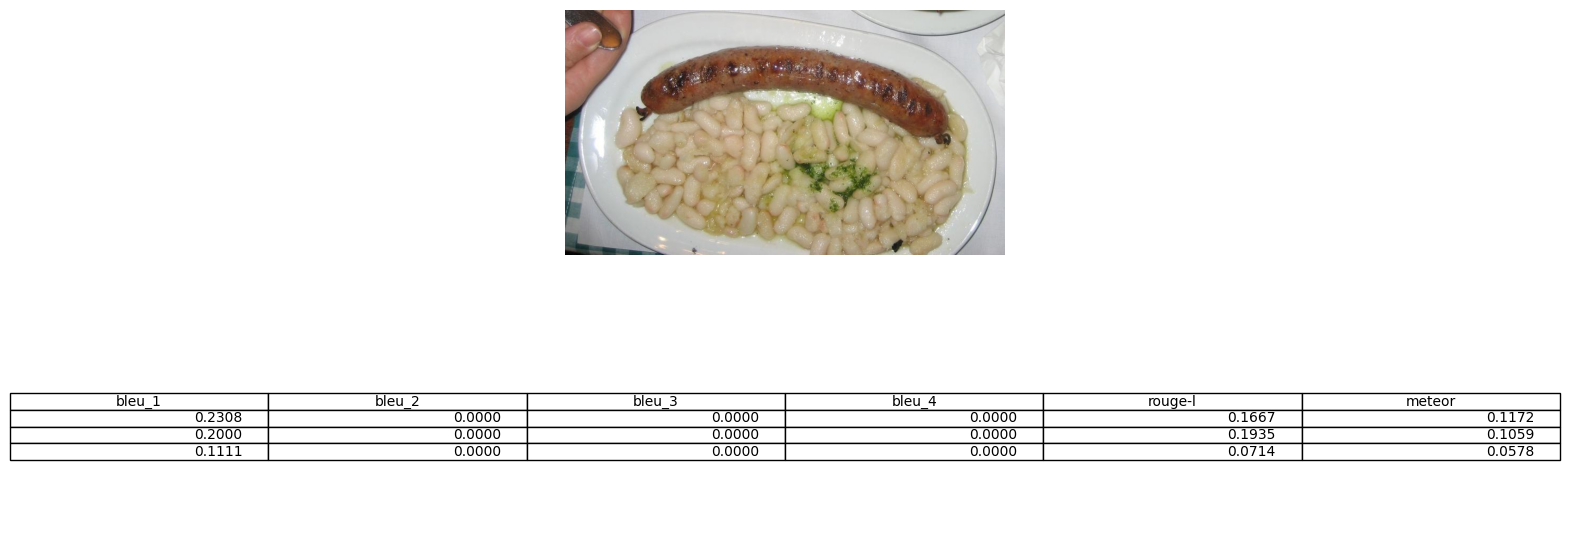

Botifarra_0024
Matches: ['pot roast with reddish brown skin and green beans soaked in browned broth', 'baingan bharta with chopped green onion on the top and some steamed white rice topped with chopped onion next to it on a white plate', 'as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy ']



In [46]:
import warnings #ignore specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
imagesdf = training_df.sample(n=1)
refrences =[]
candidates = []
  # print(imagesdf)
for index, row in imagesdf.iterrows():
    print(f"Image inserted: {row['image']}\nReal caption: {row['caption']}\n")
    # print((row['caption']).astype(str))

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=3)
    present_scores(row.image, row['caption'], matches)
    print(row.image)
    print(f"Matches: {matches}\n")
    for i in matches:
      if row['caption'] == 'NO_IMG_FOUND':
        continue
      refrences.append(row['caption'])
      if i == 'NO_IMG_FOUND':
        continue
      candidates.append(i)
warnings.resetwarnings()






    # get_bleu(row['caption'], matches[0])
    
    

BLUE SCORE CALCULATIONS

In [47]:
refrences = []
candidates = []

def get_n_random_image_match(n):
  
  imagesdf = testing_df.sample(n=n)
  # print(imagesdf)
  for index, row in imagesdf.iterrows():
    # print(f"Image inserted: {row['image']}\nReal caption: {row['caption']}\n")

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=1)
    for i in matches:
      print("image number" , i)
      if row['caption'] == 'NO_IMG_FOUND':
        continue
      refrences.append(row['caption'])
      if i == 'NO_IMG_FOUND':
        continue
      candidates.append(i)

def evaluate_model(nsamples=40):
  imagesdf = testing_df.sample(n=nsamples)
  eval = EvaluationServer()
  # print(imagesdf)
  for index, row in imagesdf.iterrows():

    # Top 3 matches from model.
    matches = find_matches_from_image(model, 
                            text_embeddings,
                            image_query=row.image,
                            captions=testing_df['caption'].values,
                            n=3)
    if matches != 'NO_IMG_IN_GDRIVE':
      eval.add(row['caption'], matches)

  eval.present_metrics()


In [48]:
refrences,candidates

([], [])

N = VALIDATION IMAGES

In [49]:
get_n_random_image_match(3000)


c:\Users\haZAR\anaconda3\envs\pytorchgpu\Lib\site-packages\tqdm\std.py:465: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  if rate and total else datetime.utcfromtimestamp(0))
100%|██████████| 1/1 [00:00<00:00, 31.49it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 45.40it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 31.74it/s]


image number the golden-yellow paella with shrimp is sprinkled with green onions and coriander


100%|██████████| 1/1 [00:00<00:00, 45.05it/s]


image number the patterned dinner plate holds a rich pasta dish with ingredients such as corn segmentsmeat and potatoes 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 40.35it/s]


image number the bun bo hue with clear soup contains rice vermicellibeef and some black pepper on the top 


100%|██████████| 1/1 [00:00<00:00, 32.96it/s]


image number this is a bowl of dandan noodles seasoned with chili oilwith some chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


image number a piece of square applesauce cake topped with white chocolate served with two sliced apples and mint leaves 


100%|██████████| 1/1 [00:00<00:00, 51.39it/s]


image number arròs negre with four musselswith a prawnhalf a lemon and a little parsley leaves on it 


100%|██████████| 1/1 [00:00<00:00, 43.97it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 52.17it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 47.52it/s]


image number several golden-brown aburaage shaped in regular triangle in a dark plate 


100%|██████████| 1/1 [00:00<00:00, 41.21it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 30.27it/s]


image number fuqi feipian soaked in red oil with chopped celery and sprinkled with white sesame seeds


100%|██████████| 1/1 [00:00<00:00, 41.60it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number in the large baking traythere are rows and rows of peanut butter cookies that will be baked 


100%|██████████| 1/1 [00:00<00:00, 45.26it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 47.32it/s]


image number a pot of milky white fish soup with some shavings of chives floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number a loaf of paupiette skinned with raw salmon and filled with a meat stuffingdecorated with dill on topand served with lemon wedges and vegetable greens


100%|██████████| 1/1 [00:00<00:00, 33.81it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


image number a whole golden red ayam goreng flavored chicken thigh on a white plate


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 38.60it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number cold but fresh coleslaw consists of shredded cabbage and carrot stripscoated with thick salad dressing


100%|██████████| 1/1 [00:00<00:00, 44.44it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 43.03it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 41.55it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number yellow peanut soup made with peanut buttersweet potatoes and other ingredients


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number brown smoothie coffee with ice cream and chocolate saucein a clear cup 


100%|██████████| 1/1 [00:00<00:00, 28.13it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 25.20it/s]


image number three pieces of chicken parmigiana on a white plate topped with tomato sauce and cheese and sprinkled with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 25.44it/s]


image number a serve of sambar cooked with pigeon pea and tamarind brothserved in the bowl


100%|██████████| 1/1 [00:00<00:00, 27.01it/s]


image number corn pudding topped with corn kernels in a square clear bowl 


100%|██████████| 1/1 [00:00<00:00, 31.70it/s]


image number a plate of coda alla vaccinara within stewed oxtailonionsand tomatoes in the thick soup alongside cutlery on the table


100%|██████████| 1/1 [00:00<00:00, 29.01it/s]


image number a dark plate of well baked cake with applesauce and a fork on the side


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 41.26it/s]


image number es pisang ijo dessert with main ingredients of icepink sugar syrup and green-skinned banana underneath


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


image number a round plate of tafelspitz with sliced beefpotatoessliced radishcarrotsleekand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number this key lime pie features a homemade graham cracker crusta creamy tart fillinghomemade whipped cream and two slices of lime on top 


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


image number a tuna fish sandwich consists of some lettucesome pinkish mashed tuna fish and slices of tomatoes and cucumbers sandwiched between two slices of toast 


100%|██████████| 1/1 [00:00<00:00, 32.98it/s]


image number steak tartare on a large plate with some french friesa few lettuce leavestwo plates of dipping saucea knife and a fork


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 45.31it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 36.75it/s]


image number onigiris are available in five flavors and put in a metal lunch box 


100%|██████████| 1/1 [00:00<00:00, 25.37it/s]


image number roasted racks of lamb with pink meat inside and golden skin outsidetopped with dried rosemaryserved with sliced roasted potatoes and a green dipping sauce 


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 46.52it/s]


image number bowls of yellow lettuce soup sprinkled with green spicesserved with spoons on the side


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 28.07it/s]


image number a large bowl of naengmyeon with many noodlescucumber slicesradish sliceseggs and red soup 


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number filet mignon with lattice on the surface covered with oily skin in a baking oven


100%|██████████| 1/1 [00:00<00:00, 43.13it/s]


image number a box of ice cream balls with cherries next to a box of cherries 


100%|██████████| 1/1 [00:00<00:00, 31.08it/s]


image number a goblet of strawberry sundae consists of white ice cream with a swirling top doused with rose-colour strawberry jam topped with some colourful chocolate sprinkles 


100%|██████████| 1/1 [00:00<00:00, 33.31it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 52.16it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


image number a man cutting a large share of porchetta with beef into thin slices


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


image number half stuffed peppers on a green round-rimmed platefilled with rice mixed with red beansminced meatand sprinkled with some chopped cilantro leaves


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 47.41it/s]


image number hokkien mee consisted of round wheat noodles and rice noodlesstir-fried with prawns and bean sprouts 


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


image number the golden white cut chicken is neatly slicedwith some coriander scattered on the white cut chicken 


100%|██████████| 1/1 [00:00<00:00, 39.93it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 44.64it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 


100%|██████████| 1/1 [00:00<00:00, 37.65it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 45.21it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


image number the mirchi ka salan dish is made of two grilled mild green chilis simmered in a thick yellow mixturemixed with coriander and some white sesame seeds 


100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 53.83it/s]


image number the white tray had a strawberry tart full of strawberries on itwith some lemons and strawberries on the side 


100%|██████████| 1/1 [00:00<00:00, 49.26it/s]


image number a red plaid tablecloth is topped with a silver fork and a plate of coffee-colored pig's trottersalongside two small bottles of spices and halved tomatoes


100%|██████████| 1/1 [00:00<00:00, 27.45it/s]


image number five oval pommes dauphines with coriander on top as garnish and a plate of garlic sauce aside


100%|██████████| 1/1 [00:00<00:00, 35.85it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number mirchi ka salan with fried mild green chilis in a piquant mixture of yellow sauce with a variety of spices 


100%|██████████| 1/1 [00:00<00:00, 45.37it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00,  7.39it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 30.15it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number a black and a white konnyaku chunk next to shredded black konnyaku


100%|██████████| 1/1 [00:00<00:00, 24.56it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number reddish-orange colored crab in padang sauce prepared using crab halves and spicy padang sauce 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 52.47it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number the blueberry pie is made of pastry on the outside and numbers of fresh blueberry with icing on its surface 


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 47.48it/s]


image number on yellow blotting paper is a silver foil plate with a strawberry pie with a corner missingand a silver spatula beside it


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 40.77it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 30.95it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 40.76it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 47.72it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number some lacy glutinous rice balls are placed in a leaf-shaped plate 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number there are three rice balls with black sesame seeds and a wooden spoon on the board 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 34.21it/s]


image number a coconut cake covered with brown chocolate sauce and peanut buttersprinkled with some white chocolate chipsand placed on a transparent round glass plate 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 51.04it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 33.71it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number caprese salad consists of chopped tomatoes surrounded by chunks of cheese with basil on the top on a plate painted with red flowers 


100%|██████████| 1/1 [00:00<00:00, 39.51it/s]


image number a bowl of soft apple sauce with a juicy surface mixed by a wooden stick near a basket of apples 


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number several golden-fried and crispy mozzarella sticksfilled with cheeseand a plate of tomato sauce next to themare placed on a red and white checkered wrapping paper 


100%|██████████| 1/1 [00:00<00:00, 52.44it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a small white bowl filled with strawberry ice creamnext to a small bowl decorated with some mint leaves of strawberriesand two spoons placed next to it


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 17.55it/s]


image number a serve of salmon pie with a nice crispy surface on a metal plateand a corner of the pie is already finished


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


image number a black flatter of orange-colored tobiko made with flying fish roe 


100%|██████████| 1/1 [00:00<00:00, 55.45it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 33.65it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


image number the blueberry pie is made of pastry on the outside and numbers of fresh blueberry with icing on its surface 


100%|██████████| 1/1 [00:00<00:00, 42.98it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 49.88it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 45.16it/s]


image number several neatly arranged small white bowls with creamy white vichyssoise studded with some green herbs


100%|██████████| 1/1 [00:00<00:00, 18.97it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 49.89it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


image number arròs negre with four musselswith a prawnhalf a lemon and a little parsley leaves on it 


100%|██████████| 1/1 [00:00<00:00, 47.31it/s]


image number porchetta with a grid-like surface and a little charredcut off a few slices 


100%|██████████| 1/1 [00:00<00:00, 48.67it/s]


image number large chunks of svíčková drizzled with a sticky orange saucegarnished with a slice of lemon and some red jam


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a round cake surrounded by chocolate chips with cherries and chocolate on the surface


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number oily chicken kebabs are threaded on bamboo skewers and baked to a bright reddish-brown exterior 


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a carrot cake cookie missing a part covered with crispy skin sandwiched with a layer of cream 


100%|██████████| 1/1 [00:00<00:00, 58.69it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 49.90it/s]


image number ten pieces of pink nuomici underneath are padded with yellow paper 


100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 38.55it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 54.94it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


image number on the plate is a piece of chocolate marshmallow pie with chocolate pie at the bottom and marshmallow on top


100%|██████████| 1/1 [00:00<00:00, 34.82it/s]


image number a top view of mousse topped with red berry and white cream


100%|██████████| 1/1 [00:00<00:00, 48.75it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


image number two large pieces of spiced beef with a rich sauceserved on a white dinner plate 


100%|██████████| 1/1 [00:00<00:00, 38.18it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 37.92it/s]


image number japchae is actually a mixed vegetable with leekscarrotsonionsfungus and cellophane noodles that can be eaten with rice 


100%|██████████| 1/1 [00:00<00:00, 49.62it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


image number three ball-shaped nuomici wrapped with shredded coconut accompanying mango pomelo sago 


100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


image number a white bowl of whitedriedand chewy steamed rice with parsley on top served with an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


image number a goblet of café liégeois with coffeecoffee flavoured ice cream and cream
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.53it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 36.79it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number on a white plate with a heart-shaped cutout patternthere is a silver fork and a plate of pasta al pomodoronext to which there is a bear toy


100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


image number a round lemon ice box pie that has been cut in the middle is placed on a dessert plate with a knife at the side


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 55.41it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 41.09it/s]


image number crunch rectangle reddish-brown bugnes sprinkled with white powdered sugar on top


100%|██████████| 1/1 [00:00<00:00, 48.61it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 46.23it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number nasi goreng consisted of fried rice with green peastopped with a poached eggand accompanied with a drumstick and crispy fries on the side


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 47.11it/s]


image number bandeja paisa consists of riceroast sausagefried banana slicesfried eggsavocadosteak and fried pork 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 52.46it/s]


image number carpaccio consists of slices of raw meat served with olive oiland lemon juice and garnished with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 27.99it/s]


image number there is a dish of lemon ice box piesome lemonsand a teapot on the table 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 32.09it/s]


image number brown smoothie coffee with ice cream and chocolate saucein a clear cup 


100%|██████████| 1/1 [00:00<00:00, 47.43it/s]


image number a bowl of minestrone with ricesliced cucumbersdiced carrotskidney beansgreen beansand peeled tomatoes 


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


image number a portion of gulai ayam in a white jar a bowl of rice next to it 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 27.78it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number a dark green lettuce soup with a scoop of white buttercream and some basil leaves on the surface 


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 49.36it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 53.90it/s]


image number three bowls of black stinky tofu with lettucecrushed corianderand spicy oil on top 


100%|██████████| 1/1 [00:00<00:00, 31.02it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number on the plate is a piece of chocolate marshmallow pie with chocolate pie at the bottom and marshmallow on top


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 55.53it/s]


image number three slices of butter cakes cut from a large loop-shaped golden butter cake with tender interior and crispy exterior


100%|██████████| 1/1 [00:00<00:00, 46.27it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 29.60it/s]


image number a delicious and savory italian tomato pie baked with tomato slicesbacon and cheese on topand serve with a knife and fork on the side


100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 43.39it/s]


image number two golden suckling pigs lie on a wooden cutting board with three small plates of side dishes


100%|██████████| 1/1 [00:00<00:00, 27.06it/s]


image number some clams with brown shells steamed in water in a deep metal container 


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


image number on an oval plate were slightly burnt pork ribssprinkled with spices 


100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 38.64it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


image number a princess cake with whitefresh creamgreen matcha ice creampink petals and green leaves made of cream 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a delicate serving of sliced fish soup made with fishbok choy and seaweed in a clear broth


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 34.93it/s]


image number coconut cream on top of baked cakegarnished with toast coconut flakeswith a cup of coffee next to it 


100%|██████████| 1/1 [00:00<00:00, 23.81it/s]


image number five oval pommes dauphines with coriander on top as garnish and a plate of garlic sauce aside


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 37.73it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 44.65it/s]


image number a simple dish of rice and peas contains white ricemung beans and succulent chicken wings


100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


image number a portion of gulai ayam in a white jar a bowl of rice next to it 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number a top view of colcannon with mashed potatoes and chopped cabbagetopped with chopped green onions


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 35.13it/s]


image number golden brown baingan bharta garnished with chillimustard and a coriander leaf on top


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number two blt sandwiches made out of burger bunsbrown sauced grilled beef pattiestomato sliceslettuceand melted cheese 


100%|██████████| 1/1 [00:00<00:00, 44.22it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 45.23it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number clear soup made out of stewed fish blocks and ginseng cuts is served in a bowl


100%|██████████| 1/1 [00:00<00:00, 36.54it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 43.35it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 39.29it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 43.44it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 48.46it/s]


image number oily chicken kebabs are threaded on bamboo skewers and baked to a bright reddish-brown exterior 


100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


image number a plate of crispy deep-fried coconut shrimps with coconut flakes served with a small bowl of salad dressing 


100%|██████████| 1/1 [00:00<00:00, 37.68it/s]


image number cut onions and carrots that have been stewed in lentil soup are contained in a bowl with minced coriander on the top


100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


image number the whitepatterned paper was covered with a large piece of pizza carbonara sprinkled with chopped cheese and red bacon


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 53.55it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.54it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 35.35it/s]


image number underneath the white casserole is a layer of white garlictopped with pink fish headsand the middle of the fish heads is dotted with shallotscoriander and peppers


100%|██████████| 1/1 [00:00<00:00, 48.52it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 54.86it/s]


image number a beautiful cherry cake pasted with heavy cream in white or pinkcovered with many red cherries on top


100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


image number three pieces of chicken parmigiana on a white plate topped with tomato sauce and cheese and sprinkled with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 43.00it/s]


image number sapo tahu consisted of sliced carrotsmall pieces of cabbageminced porkand fried tofucooked in a deep pan with a spatula 


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number red pappa al pomodoro covered with a thick layer of tomatoes and sauce


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a small bowl of sliced fish soup consisted of fish and coriander in a clear brothserved with soy sauce with chopped chili on the side


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 35.41it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 49.83it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number a long sausage sandwich made with baguette cut in half filled with sausagesonions and coriander


100%|██████████| 1/1 [00:00<00:00, 42.44it/s]


image number mutton korma made of mutton with bones full of marrow with oily sauce 


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number this is a bowl of dandan noodles seasoned with chili oilwith some chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a tuna fish sandwich consists of some lettucesome pinkish mashed tuna fish and slices of tomatoes and cucumbers sandwiched between two slices of toast 


100%|██████████| 1/1 [00:00<00:00, 35.51it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 57.15it/s]


image number sauerbratendrenched with red saucewas placed on a round white plate with carrot pieces and celery stemsand a set of cutlery was placed next to it 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


image number a heap of golden plain doughnuts with sugar powder on top


100%|██████████| 1/1 [00:00<00:00, 53.81it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number the blueberry pie is made of pastry on the outside and numbers of fresh blueberry with icing on its surface 


100%|██████████| 1/1 [00:00<00:00, 54.07it/s]


image number three bibingkas on a big dark green banana leaf with brown colored burnt skin


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number classic chicken marsala cooked with chicken and mushroom slicescovered in thick creamy sauce and sprinkled with parsleyaccompanied with two lemon slices on the side


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number a piece of garlic cheese bread was torn in halves by hand over the rest pieces 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number with a pinch of celery on the topan olivier salad mixed with mayonnaise consists of chopped hampotatoes and picklesand some peas 


100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a full bowl of drunken shrimps immersed in wine with black fungusand topped with red chiliesgarlic and spring onions


100%|██████████| 1/1 [00:00<00:00, 39.22it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 43.29it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 30.29it/s]


image number the large transparent bowl contains some ceviche soaked in lime juice 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number drunken shrimp soaked in highly spiced alcohol-based sauceserved in a glass bowl 


100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


image number the golden tacos are brushed with orange-red saucewith a layer of green sauce on the sideand garnished with some chopped onions


100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


image number sponge-like dhokla with holes on the surface with corianderblack beansand coconuts on the top 


100%|██████████| 1/1 [00:00<00:00, 55.18it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number a small white bowl contained a bowl of green edamame sprinkled with some salt grains on topfollowed by an empty bowl


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a pot of milky white fish soup with some shavings of chives floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a pizza carbonara covered with cheese and a hot spring egg in the middle 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number well-sired white buttercream with a creamy surface in a blue bowl 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number the small silver pot with golden handles holds a pale yellow kadhi with a few pieces of coffee-colored chicken on top and a silver spoon on the back


100%|██████████| 1/1 [00:00<00:00, 21.27it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 30.80it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


image number bowls of yellow lettuce soup sprinkled with green spicesserved with spoons on the side


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number a plate of roasted ayam bakar with oily deep brown chicken sprinkled with chopped spring onions 


100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 41.59it/s]


image number the soup bowl holds a serving of braised pig's trotters with sliced lotus rootshiitake mushrooms and wolfberries in a rich soup 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.88it/s]


image number chocolate fillings wrapped in soft pączk dusted with powdered sugar 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number brown lebkuchen cookies are shaped into smiling snowmen with snowflakes in the middle 


100%|██████████| 1/1 [00:00<00:00, 42.21it/s]


image number a plate of fried calamari rings with a small bottle of the sauce aside accompanying a bowl of stir-fried beans on the table


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 38.90it/s]


image number some raw sheep's trotters with skin are stacked up on top of each other 


100%|██████████| 1/1 [00:00<00:00, 55.27it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 35.50it/s]


image number two flaky and crunchy yellow corn dogs accompanying a dish of mayonnaise 


100%|██████████| 1/1 [00:00<00:00, 53.65it/s]


image number corianderpork slices and pork blood curds in one bowl of pork blood soup


100%|██████████| 1/1 [00:00<00:00, 50.25it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 


100%|██████████| 1/1 [00:00<00:00, 24.36it/s]


image number oily chicken kebabs are threaded on bamboo skewers and baked to a bright reddish-brown exterior 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 42.52it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 47.38it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a white plate of ham salad prepared using sliced hamgreen vegetables and cheesewith a fork on the side


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number some white boiled shrimps in orange colour are attached up on top of each other on a square plate 


100%|██████████| 1/1 [00:00<00:00, 42.60it/s]


image number yellow pudding corn made with stewed cornwater and thickening agents


100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 52.49it/s]


image number the round edges are golden strawberry tarts covered with white cream and dotted with red strawberries


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 39.22it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number three slightly seared smooth oiled botifarras on a yellow sauce


100%|██████████| 1/1 [00:00<00:00,  7.67it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 36.88it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 31.23it/s]


image number oily chicken kebabs are threaded on bamboo skewers and baked to a bright reddish-brown exterior 


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


image number three slices of butter cakes cut from a large loop-shaped golden butter cake with tender interior and crispy exterior
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 33.93it/s]


image number mirchi ka salan with fried mild green chilis in a piquant mixture of yellow sauce with a variety of spices 


100%|██████████| 1/1 [00:00<00:00, 24.33it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a plate of diced wenchang chicken with golden skin garnished with some parsley and two redbuds 


100%|██████████| 1/1 [00:00<00:00, 34.30it/s]


image number a black flatter of orange-colored tobiko made with flying fish roe 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number in a blue metal pot with handlesjambalaya is made of chickensausagegreen beansand ricewith a celery leaf on top 


100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


image number a large plateau de fruits de mer is surrounded by lemon slices with prawnssnailsflower clams and bread crab pliers


100%|██████████| 1/1 [00:00<00:00, 22.46it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


image number cut onions and carrots that have been stewed in lentil soup are contained in a bowl with minced coriander on the top


100%|██████████| 1/1 [00:00<00:00, 58.02it/s]


image number two shrimpsliced vegetables and sliced fruit make up a cool and delicious prawn cocktail served in a glass salad bowl 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 36.73it/s]


image number a princess cake with whitefresh creamgreen matcha ice creampink petals and green leaves made of cream 


100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


image number a carrot cake cookie missing a part covered with crispy skin sandwiched with a layer of cream 


100%|██████████| 1/1 [00:00<00:00, 39.73it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


image number botan ebis sashimi piled up on a small wooden plate


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number five oval pommes dauphines with coriander on top as garnish and a plate of garlic sauce aside


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number lots of lemon tarts that are decorated with daisies and various fresh fruits such as mangoskiwisand strawberries


100%|██████████| 1/1 [00:00<00:00, 24.90it/s]


image number two melt sandwiches of melted cheese slices and beef patties are stacked on top of each othertopped with a skewer of pickled cucumbers 


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number on the banana leaf is golden kwetiau goreng mixing flat rice noodlesbean sproutsshrimpsfried shrimp headsblack pepper and shallots


100%|██████████| 1/1 [00:00<00:00, 47.39it/s]


image number several golden-brown aburaage shaped in regular triangle in a dark plate 


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number a plate of crispy deep-fried coconut shrimps with coconut flakes served with a small bowl of salad dressing 


100%|██████████| 1/1 [00:00<00:00, 33.12it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number a large black forest gateau consisted of dark chocolate cake and whipped creamtopped with cherries and mixed berriessprinkled with powdered sugar 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number the white bowl with brown edges contains a thick green pea soup with three green pods and a wooden spoon next to it
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a small square bowl contains many spherical kachorisnext to which there is a bowl of red saucea bowl of green sauceand a cup of milk tea
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number three glasses of lemonade with ice cubes garnished with minta lemon slice and sugar on the glass edge


100%|██████████| 1/1 [00:00<00:00, 32.71it/s]


image number underneath the white casserole is a layer of white garlictopped with pink fish headsand the middle of the fish heads is dotted with shallotscoriander and peppers


100%|██████████| 1/1 [00:00<00:00, 32.21it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number many kebabs strung with bamboo skewers are neatly stacked togethersprinkled with white sesame seeds


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a pan of bourbon chicken within diced chicken breast garnished with chopped scallions in the thick soup along with a wooden spoon in it


100%|██████████| 1/1 [00:00<00:00, 35.01it/s]


image number simple peanut soup made of mashed peanut and sprinkled with grated peanuts on topaccompanied with a lemon slice and peanuts with husks


100%|██████████| 1/1 [00:00<00:00, 51.78it/s]


image number a large piece of grey tafelspitz simmered in a clear soup with some red radishes and white yams


100%|██████████| 1/1 [00:00<00:00, 34.33it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number seven round macarons with seven different colors stacked one by one 


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 51.95it/s]


image number some washed clean abalones with dark grey stone-color shell and dark yellow flesh 


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 53.77it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number the golden-yellow paella with shrimp is sprinkled with green onions and coriander


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 31.09it/s]


image number a bowl of red beans and rice with cooked red beanswhite riceand some soup in a white bowl 


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 43.32it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 21.53it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


image number a bowl of light-red suanmeitang with five yangmei and an orange straw in it 


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


image number a white bowl of bubur kacang hijau full of mung beans with a spoon filled in the bowl


100%|██████████| 1/1 [00:00<00:00, 49.56it/s]


image number in the metal pot are pork knuckles and ginger stew with lotus root slicesred datesand medlar 


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number bowls of yellow lettuce soup sprinkled with green spicesserved with spoons on the side


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number six golden-crusted samosas enclose a small bowl of brownish-red sauce


100%|██████████| 1/1 [00:00<00:00, 37.65it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 51.87it/s]


image number there is a rou jia mo filled with chopped cooked meat 


100%|██████████| 1/1 [00:00<00:00, 47.28it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number golden brown baingan bharta garnished with chillimustard and a coriander leaf on top


100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


image number rich and hot fried rice served in a pan with the ingredients of riceshrimpseggscarrotsgreen peasand a sprinkling of spring onions on top


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 43.00it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


image number bandeja paisa consists of riceroast sausagefried banana slicesfried eggsavocadosteak and fried pork 


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number on the plate is dark brown eisbein with a charred skin and tender inside served with vegetable salad as well as mashed potatoes topped with parsley


100%|██████████| 1/1 [00:00<00:00, 28.02it/s]


image number three ciambelle covered with a layer of syrup and decorated with white sprinkles on the surface
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 30.15it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 31.21it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 37.98it/s]


image number ginger beef consists of juicy beef slicesginger sauce and green broccoli 


100%|██████████| 1/1 [00:00<00:00, 43.70it/s]


image number two slices of french toastsliced diagonallyfried with a slightly browned crustwith a slice of lemon on the side 


100%|██████████| 1/1 [00:00<00:00, 32.13it/s]


image number oily chunks of hongshao rou with star anise is simmered to brownish red 


100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


image number a dish of hainanese chicken rice consisted of poached chicken slices and riceaccompanied with tomato wedgesand decorated with coriander


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


image number on the plate is a piece of chocolate marshmallow pie with chocolate pie at the bottom and marshmallow on top


100%|██████████| 1/1 [00:00<00:00, 43.90it/s]


image number brown smoothie coffee with ice cream and chocolate saucein a clear cup 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 30.94it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 24.04it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 27.30it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 26.41it/s]


image number charcoal-grilled ayam bakar with crispy outside served on a leaf 


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


image number seven round macarons with seven different colors stacked one by one 


100%|██████████| 1/1 [00:00<00:00, 34.95it/s]


image number some cute small bread rolls with a smooth golden brown surface in a silver baking tray 


100%|██████████| 1/1 [00:00<00:00, 44.92it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 30.08it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00,  7.72it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 25.81it/s]


image number two shrimpsliced vegetables and sliced fruit make up a cool and delicious prawn cocktail served in a glass salad bowl 


100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 42.63it/s]


image number a slice of a fully-baked salmon pie with a succulent and crispy crust in brown and orange colourfilled with cooked salmon and mashed potatoes 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 45.88it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 43.21it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a delicious and savory italian tomato pie baked with tomato slicesbacon and cheese on topand serve with a knife and fork on the side


100%|██████████| 1/1 [00:00<00:00, 36.50it/s]


image number a small pot of hot and sour soup with several pieces of mushroomsand some chopped scallions sprinkled on it 


100%|██████████| 1/1 [00:00<00:00, 38.18it/s]


image number the round edges are golden strawberry tarts covered with white cream and dotted with red strawberries


100%|██████████| 1/1 [00:00<00:00, 43.14it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 51.31it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 29.86it/s]


image number succulent steaks of bone-in galbi grilled with black brown skinwith a sprinkling of chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 20.89it/s]


image number an iceberg-shaped plateau de fruits de mer filled with all kinds of seafoodsuch as shrimpabalonescrabsoystersetc which looks very fresh and delicious


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 27.27it/s]


image number the golden tacos are brushed with orange-red saucewith a layer of green sauce on the sideand garnished with some chopped onions


100%|██████████| 1/1 [00:00<00:00, 32.10it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 45.09it/s]


image number some sliced pork tenderloin and grapefruit on a cutting board with a dish of red sauce and some rosemary on the side 


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number brown babi panggang accompanied with a bowl of white rice and grilled baby bok choy 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 57.10it/s]


image number small light blue bowl holds tonkotsu ramenthe soup is creamy whiteand with two slices of char siew and some chopped green onion


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 35.66it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 33.87it/s]


image number small cups of prawn cocktail consisted of prawnsarugulacucumberstomatoes and lemon wedges


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number a christmas cake with white ice cream cakered fruitsome decorationssuch as santa clauschristmas treeelkhazelnutetc 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a piece of small round chocolate marshmallow pie cut in half with crispy chocolate coating and marshmallow in the middle
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 31.72it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 43.40it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 40.74it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 44.14it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 46.50it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 55.20it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 54.92it/s]


image number a round lemon ice box pie that has been cut in the middle is placed on a dessert plate with a knife at the side


100%|██████████| 1/1 [00:00<00:00, 49.72it/s]


image number char kway teow with bean sproutsprawnssausage in a light brown disc lined with banana leaves 


100%|██████████| 1/1 [00:00<00:00, 46.48it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 55.36it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a portion of fried rice with some mung beansdiced carrots and scrambled eggssprinkled with some chopped scallionsand placed on a dark gray round plate 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number six pork balls with chopped shallot and red pepper on top and three fried dumplings and soy sauce aside


100%|██████████| 1/1 [00:00<00:00, 46.43it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number eggplant is cut into two halvesstuffed with a light-brown mixture made of cheeseminced garlic and finely chopped beansand then baked 


100%|██████████| 1/1 [00:00<00:00, 34.51it/s]


image number a lemon tart with a crispy surface surrounding soft sponge accompanied with mature lemons 


100%|██████████| 1/1 [00:00<00:00, 49.48it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 24.68it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number baked beans smeared with red saucefully into the brim in a white jug


100%|██████████| 1/1 [00:00<00:00, 31.60it/s]


image number three bibingkas on a big dark green banana leaf with brown colored burnt skin


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a large pot of pot roast with chopped cilantro sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 27.34it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 40.79it/s]


image number the golden-yellow paella with shrimp is sprinkled with green onions and coriander


100%|██████████| 1/1 [00:00<00:00, 42.52it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a beautiful cherry cake pasted with heavy cream in white or pinkcovered with many red cherries on top


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


image number several golden coconut shrimps sprinkled with chopped coriander and placed on a round white plate 


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a glass of brown soft coffee jelly is served in coffee and accompanied by some coffee beans in two spoons 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a plate of green papaya saladthat is made of some papaya shredscarrot shredscucumber shredschopped celeryand some fried peanuts


100%|██████████| 1/1 [00:00<00:00, 52.43it/s]


image number three bibingkas on a big dark green banana leaf with brown colored burnt skin


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number some pooris with crispy texture and an appealing golden color lying on a white plate
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number a green spinach soup made of coarsely chopped spinach boiled in an egg drops soup 


100%|██████████| 1/1 [00:00<00:00, 55.32it/s]


image number a large jar of strawberry sundaes consisting of many ice cream balls is placed on the table with different drinks 


100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 44.26it/s]


image number a bowl of steamed rice mixed with some black sesame seeds and crushed pecans is white in colour and topped with a sprig of coriander 


100%|██████████| 1/1 [00:00<00:00, 44.40it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 46.91it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 54.06it/s]


image number dark brown milk shake with two black straws in an irish coffee glass 


100%|██████████| 1/1 [00:00<00:00, 38.32it/s]


image number a large bowl of naengmyeon with many noodlescucumber slicesradish sliceseggs and red soup 


100%|██████████| 1/1 [00:00<00:00, 45.08it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 55.52it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 47.39it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 22.03it/s]


image number several golden coconut shrimps sprinkled with chopped coriander and placed on a round white plate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 45.30it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.38it/s]


image number there are some crispy chakli placed on a beautiful plate 


100%|██████████| 1/1 [00:00<00:00, 51.91it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number a large round banh bo baked to honeycomb-shaped with golden surfaceplaced on the grill 


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


image number tomato chunksfried tofupasty shrimp and crab in bún riêu with chopped lettuce and shallot and mint leaves on top


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a ciambelle with a golden brown surfaceglazed with royal icing the surface 


100%|██████████| 1/1 [00:00<00:00, 42.30it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number the golden-yellow paella with shrimp is sprinkled with green onions and coriander


100%|██████████| 1/1 [00:00<00:00, 36.53it/s]


image number a white square bowl with spanish rice sprinkled with chopped coriander and a wooden spoon next to it on a green tablecloth


100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 49.94it/s]


image number the crispy golden whitebaits are even in size and neatly arranged 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a large rack of lambcut off two slices and served with rosemaryon a white oval plate with a set of knives and forks beside it 


100%|██████████| 1/1 [00:00<00:00, 53.54it/s]


image number botan ebi without head and shell showing the freshmeaty and jelly-like body 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number dark brown suanmeitang with osmanthus fragrant on top in a blue bowl 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number mie goreng with shrimpbeefcucumbertomatolimeand greens 


100%|██████████| 1/1 [00:00<00:00, 55.08it/s]


image number dandan noodles is served with coriander and sesame seedsas well as a cut cooked egg 


100%|██████████| 1/1 [00:00<00:00, 47.45it/s]


image number two sandwiches with crunchy toast with red corned beef stuck on a wooden stick in the middlenext to some fries on a square plate 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number six fluffy slices of golden yellow buttery bread on a round white plate


100%|██████████| 1/1 [00:00<00:00, 31.13it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 57.01it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


image number seven round macarons with seven different colors stacked one by one 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number sandwiches consist of two pieces of white toastred tomato slicesfat bacon slices and chopped lettuce for each 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a metal bowl is filled with bean saladand two spoons are placed next to the bowl 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a white bowl with yellow and orange dots is filled with refried beanscorn kernels and white condensed milkand the top is dotted with some green chopped scallions 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.45it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number fuqi feipian soaked in red oil with chopped celery and sprinkled with white sesame seeds


100%|██████████| 1/1 [00:00<00:00, 34.16it/s]


image number deep fried peanuts piled up like hill frosted with salt on a plate 


100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 48.60it/s]


image number char kway teow with bean sproutsprawnssausage in a light brown disc lined with banana leaves 


100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


image number a pot of creamy white clam chowder with mushroompotatoand clam drizzled with thyme and assisted with a stack of bowls 


100%|██████████| 1/1 [00:00<00:00, 28.00it/s]


image number five egg tarts with a soft grilled egg and a piece of bacon on top by each garnished with cracked black pepper


100%|██████████| 1/1 [00:00<00:00, 51.45it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 55.34it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 43.17it/s]


image number a lemon tart with a crispy surface surrounding soft sponge accompanied with mature lemons 


100%|██████████| 1/1 [00:00<00:00, 29.67it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 


100%|██████████| 1/1 [00:00<00:00, 44.52it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number the fried bourbon chicken is put on a plate of fried ricedwith a fork on the brim of plate 


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number a christmas cake with white ice cream cakered fruitsome decorationssuch as santa clauschristmas treeelkhazelnutetc 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 36.77it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 51.20it/s]


image number the brown double blueberry pie is packed with white cream and topped with fresh blueberries 


100%|██████████| 1/1 [00:00<00:00, 47.28it/s]


image number classic lemon meringue pie has a fluffy meringue on top of the lemon filling 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 40.63it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 46.32it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 36.70it/s]


image number a piece of steak tartare in the middle of a white platenext to a knife and forka few plates of condimentsa glass of red wine


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 32.78it/s]


image number some cream of mushroom soup with noodles and mushroom piecessprinkled with chopped scallionsplaced in a white bowl with wavy edgesand a spoon inserted into the soup 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number a halved melt sandwich is placed on a white plate with thick brown pattiesred bacon and yellow cheese


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number four golden and tempting pasteis de bacalhauss served with vegetables and fried rice on a dinner plate 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number bandeja paisa consists of riceroast sausagefried banana slicesfried eggsavocadosteak and fried pork 


100%|██████████| 1/1 [00:00<00:00, 33.89it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


image number the bouillabaisse consists of musselsprawns and fish cooked in a pot with two slices of bread on the side 


100%|██████████| 1/1 [00:00<00:00, 46.48it/s]


image number a delicious and savory italian tomato pie baked with tomato slicesbacon and cheese on topand serve with a knife and fork on the side


100%|██████████| 1/1 [00:00<00:00, 39.54it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a delicate serving of lobster bisque consisted of lobster and creamy orange soupdecorated with thyme


100%|██████████| 1/1 [00:00<00:00, 40.67it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 25.23it/s]


image number the round edges are golden strawberry tarts covered with white cream and dotted with red strawberries


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 44.27it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 29.37it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 10.84it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number a piece of apple pie full of fruit with honey next to it


100%|██████████| 1/1 [00:00<00:00, 54.07it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 47.53it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 37.44it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 11.52it/s]


image number oysters rockefellers with spinach mixtureand oysters on shells served with half a lemon and parsley on a piece of tin foil 


100%|██████████| 1/1 [00:00<00:00, 37.20it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 46.52it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 41.02it/s]


image number a plate of diced wenchang chicken with golden skin garnished with some parsley and two redbuds 


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


image number two roasted pork knuckles surrounded by a pile of baked potato wedges on a rectangular wooden tray alongside a dish of sauce on the table


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number inside the white raised plate were two pieces of mission burrito sandwiched between green avocados and reddish-brown beefdipped in an orange-red sauce


100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 53.95it/s]


image number a dish of mirchi ka salan with green chilis soaked in yellow sauce full of foams and bubbles 


100%|██████████| 1/1 [00:00<00:00, 27.43it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 35.69it/s]


image number nasi goreng stir-fried with green beans topped with a fried medium rare egg 


100%|██████████| 1/1 [00:00<00:00, 51.59it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 24.92it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number sauerbratendrenched with red saucewas placed on a round white plate with carrot pieces and celery stemsand a set of cutlery was placed next to it 


100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 41.59it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 42.25it/s]


image number on top of some noodles is a piece of chicken sprinkled with ketchupcheese and some chopped scallionsand a fork on a white round plate 


100%|██████████| 1/1 [00:00<00:00, 29.79it/s]


image number in an aluminum pot is a jambalaya with red diced sausagesdiced white chickengreen peppers and red peppersand the rice is orange-red


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 52.10it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a cheese roll with a lot of bacon crumbs has a shiny surface 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number tomato chunksfried tofupasty shrimp and crab in bún riêu with chopped lettuce and shallot and mint leaves on top


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 18.95it/s]


image number on top of a glass jar of fruitthe curd is a wooden spoon with some yellow fruit curd inside


100%|██████████| 1/1 [00:00<00:00,  8.16it/s]


image number a small pot of hot and sour soup with several pieces of mushroomsand some chopped scallions sprinkled on it 


100%|██████████| 1/1 [00:00<00:00, 50.83it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a whole sausage is held in a cut bun and topped with bologneseketchup and yellow mustard sauce


100%|██████████| 1/1 [00:00<00:00, 30.70it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 37.69it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a white plate of ham salad prepared using sliced hamgreen vegetables and cheesewith a fork on the side


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


image number a plate of sauerbraten consisted of a chunky slice of braised beefcooked in thick and brown gravyalongside a dollop of mashed potatoes and boiled red cabbage 


100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 46.20it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number the golden orange chicken in an orange sauce is set on a black plate with green onions sprinkled on the surface


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 30.30it/s]


image number a pot of nachos with yellow dry fried cornflakessmall corn cake coresyellow melted cheesegreen chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a christmas cake with white ice cream cakered fruitsome decorationssuch as santa clauschristmas treeelkhazelnutetc 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.56it/s]


image number the green table mat has a small square bowl and a pair of chopsticks on itand the bowl is filled with some shredded wakame 


100%|██████████| 1/1 [00:00<00:00, 41.38it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 23.64it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 32.75it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 47.49it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number six golden oyster omelettes with shells are neatly arranged on white plateswith a slice of green parsley and a small tomato cut in half in the middle


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 40.41it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 58.81it/s]


image number an enamel pot of red slaw consisted of fresh red cabbage strips


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 44.45it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 25.94it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 44.32it/s]


image number there is a spoon on a bowl of cream of mushroom soupwith broken mushrooms and some soup 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a plate of shallow soup made out of chili con carnekidney beanswith some cream and mango shreds at the topand garnished with chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 29.83it/s]


image number a share of pasta al pomodoro made with pasta and sausagestopped with white sauce


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a piece of yellow shaker lemon pie made with pie crust and lemon filling


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 40.36it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


image number a lemon tart with a crispy surface surrounding soft sponge accompanied with mature lemons 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 29.09it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


image number the large transparent bowl contains some ceviche soaked in lime juice 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number brown lebkuchen cookies are shaped into smiling snowmen with snowflakes in the middle 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 48.94it/s]


image number a piece of golden soft waxy apple pie with chunky filling


100%|██████████| 1/1 [00:00<00:00, 40.73it/s]


image number a plate of cheese fries with salad and scallions on a tray with a forka cup of cola with straw and two pieces of napkin


100%|██████████| 1/1 [00:00<00:00, 33.69it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number israeli salad made of couscous with diced tomatoesdiced yellow bell peppersand mint leaves 


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


image number over-baked french toasts are piled in multi-layers with a lump of spiced cream on the top


100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 52.05it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 37.89it/s]


image number a coconut cake covered with brown chocolate sauce and peanut buttersprinkled with some white chocolate chipsand placed on a transparent round glass plate 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number the bun bo hue with clear soup contains rice vermicellibeef and some black pepper on the top 


100%|██████████| 1/1 [00:00<00:00, 40.99it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number two shrimpsliced vegetables and sliced fruit make up a cool and delicious prawn cocktail served in a glass salad bowl 


100%|██████████| 1/1 [00:00<00:00, 28.95it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number on a white plate was an olivier salad wrapped in salad dressingwith stewed potatoes and chopped parsley


100%|██████████| 1/1 [00:00<00:00, 40.77it/s]


image number two schweinshaxes stacked together and placed on a round stone plate 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number baconhamand green peppers wrapped in the denver omelette with cream and parsley on the top 


100%|██████████| 1/1 [00:00<00:00, 29.62it/s]


image number rectangular pizza carbonara covered with tomato and cheese in a pizza box 


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number some juicy chicken wings with charred pieces on top of them 


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 36.86it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


image number on the wooden table was a bowl of sesame chicken with riceand served with two small plastic bowls of sesame seeds and scallions 


100%|██████████| 1/1 [00:00<00:00, 42.06it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


image number a pot of sheep's trotters with golden thick soupserved with two sheep's trotters on the top


100%|██████████| 1/1 [00:00<00:00, 31.96it/s]


image number whitebrownand pink strawberry ice cream in a round and white bowl 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 37.65it/s]


image number dozens of white boiled shrimps with red-colored shellsserved with lemon wedges on the side 


100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number fuqi feipian consisted of beef and sliced cow's stomachgarnished with coriander on top and sprinkled with sesame


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number two beautiful slices of toast with slices of bacon coated with tomato sauce in the middlenext to a glass bottle of tomato sauce 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 35.68it/s]


image number bowls of yellow lettuce soup sprinkled with green spicesserved with spoons on the side


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number two small white bowls of freshly cooked caldo verde with a piece of red sausage on the surface by each


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


image number on the wooden spatula was a seafood pizza with scallopsshrimpand seaweedwith a small bowl of chili crumbles and a piece of cheese on the side 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a savory serving of crab soup consisted of crabs and tofu dices in a brown brothgarnished with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number ten pieces of pink nuomici underneath are padded with yellow paper 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number there are three rice balls with black sesame seeds and a wooden spoon on the board 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


image number six golden oyster omelettes with shells are neatly arranged on white plateswith a slice of green parsley and a small tomato cut in half in the middle


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a blancmange in round shapetopped with some fresh red cherrieson a brown plate 


100%|██████████| 1/1 [00:00<00:00, 49.65it/s]


image number the red shuizhu contains white meat slicesgreen scallions and red pepper granulesand the soup is also floating with a layer of red oil


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


image number two glasses of pink strawberry ice cream were served with some trash ice on the table 


100%|██████████| 1/1 [00:00<00:00, 51.14it/s]


image number eight whole big abalones with blue shells neatly placed on a square white plate 


100%|██████████| 1/1 [00:00<00:00, 52.21it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 37.57it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number a princess cake with whitefresh creamgreen matcha ice creampink petals and green leaves made of cream 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 49.71it/s]


image number a set of sauerbraten made out of thick slices of braised beef cooked in brown gravyserved with braised red cabbage and boiled petit potatoes 


100%|██████████| 1/1 [00:00<00:00, 52.25it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 41.58it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 26.83it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number a plate of fried calamari rings with a small bottle of the sauce aside accompanying a bowl of stir-fried beans on the table


100%|██████████| 1/1 [00:00<00:00, 47.25it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number two cups of rice pudding sprinkled with chocolate crumbs and two plates of chocolate crumbs on the side 


100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number there was a thick cebolada on a black iron plate and a wooden spoon with sauce on it 


100%|██████████| 1/1 [00:00<00:00, 49.90it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 38.81it/s]


image number three glasses of lemonade with ice cubes garnished with minta lemon slice and sugar on the glass edge


100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


image number small white bowl with some refried beans and some orange and white cheese on top 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number in a blue metal pot with handlesjambalaya is made of chickensausagegreen beansand ricewith a celery leaf on top 


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number two brown tafelspitz and some red carrots on a white plate with black rimnext to two silver knives and forks


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number this bowl of es pisang ijo looks attractive in a transparent glass bowl with yellow shaved ice and pink syrup 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 46.24it/s]


image number ikan bakar is a fish dish that combines crispy grilled fish with yellow curry riceserved with cowpeaspeanuts and deep-fried prawn chips 


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


image number baked beans smeared with red saucefully into the brim in a white jug


100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 55.53it/s]


image number some light brown almond biscuits with three brown almonds on the surface
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number on the wooden spatula was a seafood pizza with scallopsshrimpand seaweedwith a small bowl of chili crumbles and a piece of cheese on the side 


100%|██████████| 1/1 [00:00<00:00, 23.77it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 52.50it/s]


image number three small bowls with pale pink strawberry ice cream and some sugar scattered around


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 46.80it/s]


image number two small red pots on a metal grill hold milky fondue next to themalongside a glass of beer and a basket of bread pieces


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


image number a pot of thick mushy peas was placed in a large silver pot 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 42.46it/s]


image number in the large baking traythere are rows and rows of peanut butter cookies that will be baked 


100%|██████████| 1/1 [00:00<00:00, 32.07it/s]


image number on top of the wooden placemat with holes is a green bowl with white jiuniang in itand a rectangular white container next to it also contains jiuniang


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a small white bowl contained a bowl of green edamame sprinkled with some salt grains on topfollowed by an empty bowl


100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


image number on the plate is a piece of chocolate marshmallow pie with chocolate pie at the bottom and marshmallow on top


100%|██████████| 1/1 [00:00<00:00, 21.23it/s]


image number a pan of fried rice consisted of rice coated with soy saucechopped bell peppersonions and a sprinkling of spring onions


100%|██████████| 1/1 [00:00<00:00, 57.03it/s]


image number a bowl of light-red suanmeitang with five yangmei and an orange straw in it 


100%|██████████| 1/1 [00:00<00:00, 34.44it/s]


image number chili tuna salad contains minced tuna fish and green fruit on apple slices


100%|██████████| 1/1 [00:00<00:00, 47.47it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 42.23it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


image number spicy boiled ground pork and glass noodles seasoned with saucecrushed chilli and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


image number a plate of soused herring served with dillonion on topand lettuce on the side 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number denver sandwich with tomatoes and cream in the middle wrapped in white paper 


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 31.61it/s]


image number five oval pommes dauphines with coriander on top as garnish and a plate of garlic sauce aside


100%|██████████| 1/1 [00:00<00:00, 41.47it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number topped with some black and grey pickled olivesthree oval pasteis de bacalhau fritters consist of salted cod mixed with chopped parsleywith a crispy crust 


100%|██████████| 1/1 [00:00<00:00, 48.42it/s]


image number sandwiches consist of two pieces of white toastred tomato slicesfat bacon slices and chopped lettuce for each 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a share of orange smoked salmon with a glossy sheen


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number this is a bowl of dandan noodles seasoned with chili oilwith some chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 44.40it/s]


image number in a big blue-and-white platea jiuniang consists of peaspeanutscorn kernelssome small unfilled tangyuan and white rice in a white and thick soup 


100%|██████████| 1/1 [00:00<00:00, 20.31it/s]


image number two clear glasses with pale yellow vichyssoise covered with a white cream


100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


image number two large white plates were piled high with golden friesa francesinha in the middle and two coca-colas and knife and forks in the middle of the two plates


100%|██████████| 1/1 [00:00<00:00, 27.89it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number on the wooden table there was a white plate with a silver fork and a parmigiana drizzled with white saucenext to which were placed green broccoli


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 42.44it/s]


image number steak tartare on a large plate with some french friesa few lettuce leavestwo plates of dipping saucea knife and a fork


100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


image number lots of lemon tarts that are decorated with daisies and various fresh fruits such as mangoskiwisand strawberries


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 57.08it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 19.23it/s]


image number cut onions and carrots that have been stewed in lentil soup are contained in a bowl with minced coriander on the top


100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


image number there are so many bright orange-colored tobiko wrapped in toasted seaweed


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a jug of brown suanmeitang with some golden osmanthus floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 45.04it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number many plates are placed on the table with a wide variety of products such as pipikaulakimchi and rice paste 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number some brown gyutan made out of thin slices of beef tongue cooking on a stainless steel grill 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 44.37it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number two roasted pork knuckles surrounded by a pile of baked potato wedges on a rectangular wooden tray alongside a dish of sauce on the table


100%|██████████| 1/1 [00:00<00:00, 57.16it/s]


image number the big white plate has a dish of di san xian with a lot of oil and some chinese liquor on the side 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number a small pot of hot and sour soup with several pieces of mushroomsand some chopped scallions sprinkled on it 


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number three glasses of lemonade with ice cubes garnished with minta lemon slice and sugar on the glass edge


100%|██████████| 1/1 [00:00<00:00, 42.48it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number there are some crispy chakli placed on a beautiful plate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a plate of roasted ayam bakar with oily deep brown chicken sprinkled with chopped spring onions 


100%|██████████| 1/1 [00:00<00:00, 47.34it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 52.69it/s]


image number two roasted pork knuckles surrounded by a pile of baked potato wedges on a rectangular wooden tray alongside a dish of sauce on the table


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 30.29it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 18.01it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 46.18it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 46.43it/s]


image number yellowish-brown peanut soup with mashed and grated peanut inside


100%|██████████| 1/1 [00:00<00:00, 40.73it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number fine vermicelli and minced pork put together sprinkled with chopped spring onion 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 52.04it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 41.65it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 34.52it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 46.80it/s]


image number there are many doughnuts on the wallsome are topped with white frosting and decorated with peanuts or pink sugarsome are topped with chocolate and decorated with white sugar


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 45.89it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00, 31.28it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a brown mongolian beef is being stir-fried in a black wok with red peppers and green onions


100%|██████████| 1/1 [00:00<00:00, 51.76it/s]


image number the patterned dinner plate holds a rich pasta dish with ingredients such as corn segmentsmeat and potatoes 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 44.91it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a small bowl of blue and white porcelain holds a small bowl of dark red suanmeitang with some yellow osmanthus floating on it


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number a clear glass dinner plate holds a rich triangular-shaped shaker lemon pie cut for idle chatter and served with a fork 


100%|██████████| 1/1 [00:00<00:00, 14.03it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a bowl of fried noodles with slices of meatshallotsand bean sprouts is packed in a small white bowl with a pair of chopsticks


100%|██████████| 1/1 [00:00<00:00, 36.68it/s]


image number two bowls of bubur ayam garnished with sliced scallions on the surface along with a pot of the same bubur ayam on the table


100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 34.11it/s]


image number on top of some noodles is a piece of chicken sprinkled with ketchupcheese and some chopped scallionsand a fork on a white round plate 


100%|██████████| 1/1 [00:00<00:00, 43.39it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 37.74it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


image number two small red pots on a metal grill hold milky fondue next to themalongside a glass of beer and a basket of bread pieces


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 45.40it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 48.75it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 42.72it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number the tuna fish sandwich consists of yellow baguette slices sandwiched with red tomatogreen cilantro and white tuna meat


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number a round cheesecake with thick chocolate sauce on the surface 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number bandeja paisa consists of riceroast sausagefried banana slicesfried eggsavocadosteak and fried pork 


100%|██████████| 1/1 [00:00<00:00, 42.75it/s]


image number eight chocolate marshmallow pies on a white dessert stand accompanying some on a piece of paper


100%|██████████| 1/1 [00:00<00:00, 36.22it/s]


image number a large jar of strawberry sundaes consisting of many ice cream balls is placed on the table with different drinks 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number a bowl of israeli salad consists of diced cucumbersdiced tomatoes and red bell pepperschopped onions and parsley mixed up together with lemon juice 


100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 32.91it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number three oval-shaped bread rolls in the middle of the four triangular bread rolls 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number pappa al pomodoro in a steel pot with mint leaves on top and aside as decoration


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number several neatly arranged small white bowls with creamy white vichyssoise studded with some green herbs


100%|██████████| 1/1 [00:00<00:00, 44.47it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number banh bo in the colors buff and light pink on a white square plate


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


image number mirchi ka salan with fried mild green chilis in a piquant mixture of yellow sauce with a variety of spices 


100%|██████████| 1/1 [00:00<00:00, 43.10it/s]


image number a plate of golden pooris next to a small pile of bhaji


100%|██████████| 1/1 [00:00<00:00, 55.25it/s]


image number a white bowl of bubur kacang hijau full of mung beans with a spoon filled in the bowl


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number a bowl of smooth corn crab soup with corncrab meatand an iron spoon in it 


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


image number two large white plates were piled high with golden friesa francesinha in the middle and two coca-colas and knife and forks in the middle of the two plates


100%|██████████| 1/1 [00:00<00:00, 47.96it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 38.33it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number suanmeitang in dark-red colours on two small transparent cups with some osmanthus flowers floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number with a pinch of celery on the topan olivier salad mixed with mayonnaise consists of chopped hampotatoes and picklesand some peas 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 32.17it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number soft slices of kakuni consisted of square pork slices stewed in a savory brown sauceserved with kelp and a white radish slice


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a goblet of strawberry sundae consists of white ice cream with a swirling top doused with rose-colour strawberry jam topped with some colourful chocolate sprinkles 


100%|██████████| 1/1 [00:00<00:00, 22.91it/s]


image number there is a plate of poutine sprinkled with parsley drizzled with sauce 


100%|██████████| 1/1 [00:00<00:00, 21.10it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 31.11it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number the mirchi ka salan dish is made of two grilled mild green chilis simmered in a thick yellow mixturemixed with coriander and some white sesame seeds 


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a loaf of reddish-brown pumpkin bread with a very crisp texturecovered with small white melon seeds and large black melon seeds 


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


image number a large pot of pot roast with chopped cilantro sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number two bowls of shanghai fried noodles made of noodles stir-fried with chopped choy sumsome long sticks of beef and sliced mushroom with soy sauce 


100%|██████████| 1/1 [00:00<00:00, 39.53it/s]


image number white bowl with a silver spoon and a yellow squash soup sprinkled with nuts


100%|██████████| 1/1 [00:00<00:00, 33.22it/s]


image number on top of the yellow tablecloth is a blue bowl with a jammalaya of diced sausagesyellow pepperstomatoesgreen onionsand riceand a silver fork next to it


100%|██████████| 1/1 [00:00<00:00, 30.75it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 33.08it/s]


image number on an oval plate were slightly burnt pork ribssprinkled with spices 


100%|██████████| 1/1 [00:00<00:00, 45.35it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


image number on top of some noodles is a piece of chicken sprinkled with ketchupcheese and some chopped scallionsand a fork on a white round plate 


100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


image number a beautiful cherry cake pasted with heavy cream in white or pinkcovered with many red cherries on top


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 41.59it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00,  7.35it/s]


image number a chunky toasted melt sandwich with meat stuffingand melted cheese in between served with two cups of sauce next to it 


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number a hot serve of chicken noodles cooked in chicken soup with flat yellow noodlescarrotsonions and chicken


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 47.35it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 30.57it/s]


image number the whitepatterned paper was covered with a large piece of pizza carbonara sprinkled with chopped cheese and red bacon


100%|██████████| 1/1 [00:00<00:00, 23.56it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a dish of mirchi ka salan with green chilis soaked in yellow sauce full of foams and bubbles 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 30.17it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.48it/s]


image number café liégeois is mixed alternately with iced coffee and white whipped creamin a cup with a conical top and a cylindrical bottom 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 32.20it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


image number three ciambelle covered with a layer of syrup and decorated with white sprinkles on the surface
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 28.01it/s]


image number two bowls full of dark delicious apple sauce with two iron spoons beside them 


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 33.73it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 38.75it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 48.54it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


image number steak tartare on a large plate with some french friesa few lettuce leavestwo plates of dipping saucea knife and a fork


100%|██████████| 1/1 [00:00<00:00, 37.63it/s]


image number on top of the wooden tray was a black iron plate containing a roundly fried oyster omelette with a slice of green parsley on it


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 49.49it/s]


image number a sandwich with chicken salad and lettuce in between is served on a dinner plate with pickled cucumber on the side


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number the white tray had a strawberry tart full of strawberries on itwith some lemons and strawberries on the side 


100%|██████████| 1/1 [00:00<00:00, 43.86it/s]


image number the corn stew consisted of tomatoespotatoes and avocados cut into cubes and niblets


100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 46.43it/s]


image number in the glass jarthere is some yellow fruit curda spoonand some mint


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a plate of sauerbraten consisted of a chunky slice of braised beefcooked in thick and brown gravyalongside a dollop of mashed potatoes and boiled red cabbage 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number several golden coconut shrimps sprinkled with chopped coriander and placed on a round white plate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a princess cake with whitefresh creamgreen matcha ice creampink petals and green leaves made of cream 


100%|██████████| 1/1 [00:00<00:00, 26.64it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 31.92it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number a round cake surrounded by chocolate chips with cherries and chocolate on the surface


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number an iceberg-shaped plateau de fruits de mer filled with all kinds of seafoodsuch as shrimpabalonescrabsoystersetc which looks very fresh and delicious


100%|██████████| 1/1 [00:00<00:00, 49.89it/s]


image number mango pomelo sago from hong kong is a dessert made with diced mangosagomilkand coconut milk 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number oysters rockefellers with spinach mixtureand oysters on shells served with half a lemon and parsley on a piece of tin foil 


100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


image number a pot of creamy white clam chowder with mushroompotatoand clam drizzled with thyme and assisted with a stack of bowls 


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.25it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


image number hokkien mee consisted of round wheat noodles and rice noodlesstir-fried with prawns and bean sprouts 


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number israeli salad made of couscous with diced tomatoesdiced yellow bell peppersand mint leaves 


100%|██████████| 1/1 [00:00<00:00, 25.60it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number golden brown baingan bharta garnished with chillimustard and a coriander leaf on top


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


image number the white ceramic frying pan with handles has a spoon with a white handleand the pot also holds a jambalaya with shrimpshredded shallotscorianderand rice


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 31.21it/s]


image number on yellow blotting paper is a silver foil plate with a strawberry pie with a corner missingand a silver spatula beside it


100%|██████████| 1/1 [00:00<00:00, 27.20it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 19.30it/s]


image number in the pot was a kung pao chicken made with chickensnow peasbell peppersand cashews 


100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


image number a big piece of gravlax salmon with dill shavings is getting cut into some slices 


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 33.87it/s]


image number a piece of steak tartare in the middle of a white platenext to a knife and forka few plates of condimentsa glass of red wine


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number there is a spoon on a bowl of cream of mushroom soupwith broken mushrooms and some soup 


100%|██████████| 1/1 [00:00<00:00, 39.58it/s]


image number large chunks of svíčková drizzled with a sticky orange saucegarnished with a slice of lemon and some red jam


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a black bowl of cucumber soup prepared using pureed cucumber and creamgarnished with cucumber slices and fresh thyme on top 


100%|██████████| 1/1 [00:00<00:00, 50.89it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 44.45it/s]


image number kung pao chicken is mainly made of chopped bell pepper and diced chicken wrapped with thick sauce 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number tomato chunksfried tofupasty shrimp and crab in bún riêu with chopped lettuce and shallot and mint leaves on top


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number the white tray had a strawberry tart full of strawberries on itwith some lemons and strawberries on the side 


100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


image number many kebabs strung with bamboo skewers are neatly stacked togethersprinkled with white sesame seeds


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number the white bowl with brown edges contains a thick green pea soup with three green pods and a wooden spoon next to it


100%|██████████| 1/1 [00:00<00:00, 46.12it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number porchetta sprinkled with sugar served with a bowl of green sauce on the side 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 20.81it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number nasi goreng consisted of fried rice with green peastopped with a poached eggand accompanied with a drumstick and crispy fries on the side


100%|██████████| 1/1 [00:00<00:00, 52.51it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 54.05it/s]


image number white bowl with a silver spoon and a yellow squash soup sprinkled with nuts


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 32.75it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number chicken noodles soup with carrot pieceschicken piecesand flat noodlessprinkled with spices 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number kakuni served in thick white soup with some seaweed and coriander


100%|██████████| 1/1 [00:00<00:00, 39.98it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 38.00it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 50.59it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number many bone-in lamb chops are fried with chopped kalecooking oilchopped gingersliced pork belly and bay leaveswith a layer of mashed potatoes on the bottom 


100%|██████████| 1/1 [00:00<00:00,  8.44it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number ikan baka made of grilled fish served with parsleyflower-shaped carrot slicesand a bowl of sauce on the side 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number the white bowl with brown edges contains a thick green pea soup with three green pods and a wooden spoon next to it


100%|██████████| 1/1 [00:00<00:00, 35.07it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 41.55it/s]


image number a white bowl of chicken soup with minced parsley sprinkled on it and a silver spoon next to it


100%|██████████| 1/1 [00:00<00:00, 58.44it/s]


image number this bowl of es pisang ijo looks attractive in a transparent glass bowl with yellow shaved ice and pink syrup 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a big claypot of chicken rice with chicken coated with a thick sauce on topand sprinkled with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number princess cake in a white paper tray with pink cream with strawberry particles on top and yellow cake on the bottom


100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 30.99it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 52.44it/s]


image number on top of the wooden placemat with holes is a green bowl with white jiuniang in itand a rectangular white container next to it also contains jiuniang


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 54.07it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 35.36it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 38.37it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00,  6.71it/s]


image number a savory dish of pork blood soup contains pork bloodpork liver and other internal organsand vegetable greens


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a dish of stir-fry mie goreng with fried onion ringshelled shrimpspinachlettuceand noodles 


100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


image number two golden suckling pigs lie on a wooden cutting board with three small plates of side dishes


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number in the pot was a kung pao chicken made with chickensnow peasbell peppersand cashews 


100%|██████████| 1/1 [00:00<00:00, 40.82it/s]


image number eight whole big abalones with blue shells neatly placed on a square white plate 


100%|██████████| 1/1 [00:00<00:00, 30.93it/s]


image number arab salad with carrot stripeschopped lettucecucumberand cherry tomatoes 


100%|██████████| 1/1 [00:00<00:00, 33.38it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number the large transparent bowl contains some ceviche soaked in lime juice 


100%|██████████| 1/1 [00:00<00:00, 57.12it/s]


image number pho with green spices on the topserved with a pair of chopsticks on the side


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


image number one share of kwetiau goreng with flat rice noodlesfried eggminced pork and shallot


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number the tuna fish sandwich consists of yellow baguette slices sandwiched with red tomatogreen cilantro and white tuna meat


100%|██████████| 1/1 [00:00<00:00, 23.51it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number a pot of creamy white clam chowder with mushroompotatoand clam drizzled with thyme and assisted with a stack of bowls 


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


image number two small white bowls of freshly cooked caldo verde with a piece of red sausage on the surface by each


100%|██████████| 1/1 [00:00<00:00, 32.77it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number a sandwich with chicken salad and lettuce in between is served on a dinner plate with pickled cucumber on the side


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.13it/s]


image number three cheese pudding tarts with some green herbs next to them on a wooden board


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 32.78it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 41.58it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 44.76it/s]


image number rolls of pommes dauphine garnished with parsley leaves on an oval white plate alongside a fork on a grey placemat


100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 57.12it/s]


image number some washed clean abalones with dark grey stone-color shell and dark yellow flesh 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 55.48it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number on a grey-blue tablecloth lies a small bowl with a silver spoon beside itfrench onion soup with shredded transparent onions in the bowl


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number in the white bowl is a salad made of spinachavocadochicken breaststrawberriesonionsalmondsand cheese 


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


image number hearty seafood boil made with lobsterssnow crabsclamsmusselsshrimps and sweet corns


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number a black and a white konnyaku chunk next to shredded black konnyaku


100%|██████████| 1/1 [00:00<00:00, 48.74it/s]


image number mirchi ka salan with fried mild green chilis in a piquant mixture of yellow sauce with a variety of spices 


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number in a large metal basinshuizhu-fish is filled with a layer of chili and pepperfrom which a spoon scoops out a piece of fish 


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number the light yellow peanuts were being boiled in the potand a colander was scooping out some peanuts in one hand 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.46it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


image number three small butter pies with thick mashed cookies as bases filled with mixtures of oatssugarand flour 


100%|██████████| 1/1 [00:00<00:00, 48.71it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


image number the patterned dinner plate holds a rich pasta dish with ingredients such as corn segmentsmeat and potatoes 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 48.36it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 30.14it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


image number one sapo tahufilled with clear brothsliced mushroomstahugreens and chilli pieces


100%|██████████| 1/1 [00:00<00:00, 46.64it/s]


image number white bowl with a silver spoon and a yellow squash soup sprinkled with nuts


100%|██████████| 1/1 [00:00<00:00, 39.70it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


image number the golden orange chicken in an orange sauce is set on a black plate with green onions sprinkled on the surface


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a white bowl of whitedriedand chewy steamed rice with parsley on top served with an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 42.55it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 33.36it/s]


image number a large pot of pot roast with chopped cilantro sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 26.23it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 45.01it/s]


image number the corn stew consisted of tomatoespotatoes and avocados cut into cubes and niblets


100%|██████████| 1/1 [00:00<00:00, 37.47it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number yellow peanut soup made with peanut buttersweet potatoes and other ingredients


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 37.71it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 22.87it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 37.88it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number two glasses of pink strawberry ice cream were served with some trash ice on the table 


100%|██████████| 1/1 [00:00<00:00, 49.41it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 32.65it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


image number a plate of green papaya saladthat is made of some papaya shredscarrot shredscucumber shredschopped celeryand some fried peanuts


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 28.74it/s]


image number stewed bananas wrapped in green clothing accompanying shaved ice in es pisang ijo 


100%|██████████| 1/1 [00:00<00:00, 41.19it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00,  7.96it/s]


image number the large transparent bowl contains some ceviche soaked in lime juice 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a pan of bourbon chicken within diced chicken breast garnished with chopped scallions in the thick soup along with a wooden spoon in it


100%|██████████| 1/1 [00:00<00:00, 45.37it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 52.33it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 39.48it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number thick sheep's trotters broth with a layer of mutton fat on top drizzled with coriander


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


image number the chicken tinga dish consists of corn tortillashredded seasoned chickenchopped lettuce and cheddar placed on a blue-purple floral pattern plate


100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


image number a metal bowl is filled with bean saladand two spoons are placed next to the bowl 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 50.04it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number thick caldo verde simmered with collard leaves and topped with three slices of red sausage


100%|██████████| 1/1 [00:00<00:00, 39.16it/s]


image number a francesinha with yellow sauce and a lot of french fries placed on tomato sauce on a white round plate 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a large bowl of naengmyeon with many noodlescucumber slicesradish sliceseggs and red soup 


100%|██████████| 1/1 [00:00<00:00, 26.79it/s]


image number this is a bowl of dandan noodles seasoned with chili oilwith some chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 35.52it/s]


image number a ciambelle with a golden brown surfaceglazed with royal icing the surface 


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


image number on the green plate are sauteed whole mushrooms dressed with parsley


100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


image number the golden-yellow paella with shrimp is sprinkled with green onions and coriander


100%|██████████| 1/1 [00:00<00:00, 31.00it/s]


image number some cute small bread rolls with a smooth golden brown surface in a silver baking tray 


100%|██████████| 1/1 [00:00<00:00, 28.08it/s]


image number a set of sauerbraten made out of thick slices of braised beef cooked in brown gravyserved with braised red cabbage and boiled petit potatoes 


100%|██████████| 1/1 [00:00<00:00, 47.22it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 29.19it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 39.44it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 41.29it/s]


image number light brown ayam betutu seasoned with spice leavesaccompanied by carrot-carved flowers and strips of chilli


100%|██████████| 1/1 [00:00<00:00, 36.91it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number a small white bowl contained a bowl of green edamame sprinkled with some salt grains on topfollowed by an empty bowl


100%|██████████| 1/1 [00:00<00:00, 35.53it/s]


image number a plate of crispy deep-fried coconut shrimps with coconut flakes served with a small bowl of salad dressing 


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number a green spinach soup made of coarsely chopped spinach boiled in an egg drops soup 


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 41.78it/s]


image number a small bucket of sambar decorated with curry leavesand a plate of idlis aside


100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


image number banh bo in the colors buff and light pink on a white square plate


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 52.06it/s]


image number a piece of peanut butter cookie baked in brown with a crispy texture


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number dark brown milk shake with two black straws in an irish coffee glass 


100%|██████████| 1/1 [00:00<00:00, 42.70it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 40.25it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


image number a large bowl of naengmyeon with many noodlescucumber slicesradish sliceseggs and red soup 


100%|██████████| 1/1 [00:00<00:00, 34.95it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 42.80it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 38.12it/s]


image number denver sandwich on a white plate with some meat and mustardand with a small portion of macaroni on a stainless steel plate 


100%|██████████| 1/1 [00:00<00:00, 31.60it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 43.27it/s]


image number fuqi feipian consisted of beef and sliced cow's stomachgarnished with coriander on top and sprinkled with sesame


100%|██████████| 1/1 [00:00<00:00, 45.20it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


image number the white boiled shrimps are curlythe soup is thick and milky white with a lot of shrimpssome coriander sticks are scatteredthe white boiled shrimps are delicious and attractive 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


image number dandan noodles is served with coriander and sesame seedsas well as a cut cooked egg 


100%|██████████| 1/1 [00:00<00:00, 44.02it/s]


image number the white ceramic frying pan with handles has a spoon with a white handleand the pot also holds a jambalaya with shrimpshredded shallotscorianderand rice


100%|██████████| 1/1 [00:00<00:00, 27.00it/s]


image number two bowls of bubur ayam garnished with sliced scallions on the surface along with a pot of the same bubur ayam on the table


100%|██████████| 1/1 [00:00<00:00, 52.49it/s]


image number mie goreng with shrimpbeefcucumbertomatolimeand greens 


100%|██████████| 1/1 [00:00<00:00, 19.19it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number two clear glasses with pale yellow vichyssoise covered with a white cream


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


image number there are some crispy chakli placed on a beautiful plate 


100%|██████████| 1/1 [00:00<00:00, 36.98it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 46.50it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 33.70it/s]


image number seven round macarons with seven different colors stacked one by one 


100%|██████████| 1/1 [00:00<00:00, 42.03it/s]


image number an iron pot of juicy steamed meatballs with yellow sauce and sprinkled with parsley 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number on the wooden table was a bowl of sesame chicken with riceand served with two small plastic bowls of sesame seeds and scallions 


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 44.14it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number a pot of sheep's trotters with golden thick soupserved with two sheep's trotters on the top


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


image number on the platethere is a portion of eisbein within a golden brown pork hock and sauerkraut garnished with a piece of coriander leaf


100%|██████████| 1/1 [00:00<00:00, 41.47it/s]


image number a large bowl of clear noodles soup with white slender noodlesgreen spinach and transparent soup in a white bowl 


100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 32.76it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 23.04it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number nasi goreng consisted of fried rice with green peastopped with a poached eggand accompanied with a drumstick and crispy fries on the side


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number a black flatter of orange-colored tobiko made with flying fish roe 


100%|██████████| 1/1 [00:00<00:00, 26.47it/s]


image number a piece of garlic cheese bread was torn in halves by hand over the rest pieces 


100%|██████████| 1/1 [00:00<00:00, 53.87it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 55.30it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 31.75it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number steak tartare on a large plate with some french friesa few lettuce leavestwo plates of dipping saucea knife and a fork


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 53.96it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00, 46.50it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number two clear glasses with pale yellow vichyssoise covered with a white cream
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.23it/s]


image number there was a shaker lemon pie on a white plate with blue flowers and a lemon beside it 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number on the green plate is thin lo mien served with cabbage heartsonionseggsbean sproutsshallots and shrimps


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number this is a stack of bugnes in an irregular plateall dusted with flour 


100%|██████████| 1/1 [00:00<00:00, 29.35it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 49.53it/s]


image number red pappa al pomodoro covered with a thick layer of tomatoes and sauce


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number three mangos and mint leaves next to a glass of mango pudding with strawberry and mango wedges and mint leaves on top as garnish


100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 47.50it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a set of sauerbraten made out of thick slices of braised beef cooked in brown gravyserved with braised red cabbage and boiled petit potatoes 


100%|██████████| 1/1 [00:00<00:00, 43.43it/s]


image number the eisbein dish consists of a big deep-fried red pork knucklesome white yellowish sauerkraut and two balls of mashed potatoes with some parsley on the top 


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number the black serving bowl holds awhite broth of sliced fish soup with goji berries and vegetable leaves 


100%|██████████| 1/1 [00:00<00:00, 38.08it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number oily chicken kebabs are threaded on bamboo skewers and baked to a bright reddish-brown exterior 


100%|██████████| 1/1 [00:00<00:00, 37.02it/s]


image number a white bowl of bubur kacang hijau full of mung beans with a spoon filled in the bowl


100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


image number there was a shaker lemon pie on a white plate with blue flowers and a lemon beside it 


100%|██████████| 1/1 [00:00<00:00, 41.92it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 48.38it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 39.90it/s]


image number corn pudding topped with corn kernels in a square clear bowl 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number the pale yellow bubur kacang hijau in a lace bowl with a silver spoon inside 


100%|██████████| 1/1 [00:00<00:00, 37.96it/s]


image number fuqi feipian consisted of beef and sliced cow's stomachgarnished with coriander on top and sprinkled with sesame


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 33.28it/s]


image number sandwiches consist of two pieces of white toastred tomato slicesfat bacon slices and chopped lettuce for each 


100%|██████████| 1/1 [00:00<00:00, 25.49it/s]


image number a plate of cream of broccoli soup sprinkled with carrot sticksand a stainless steel spoon inserted into the soup 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number on the wooden spatula was a seafood pizza with scallopsshrimpand seaweedwith a small bowl of chili crumbles and a piece of cheese on the side 


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 37.24it/s]


image number there are so many bright orange-colored tobiko wrapped in toasted seaweed


100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


image number a bowl of chicken noodles soup with yellow round thin noodleswhite chicken piecesonion shredscucumber shredsred bell pepperand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 29.62it/s]


image number a red plaid tablecloth is topped with a silver fork and a plate of coffee-colored pig's trottersalongside two small bottles of spices and halved tomatoes


100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 39.92it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 


100%|██████████| 1/1 [00:00<00:00, 50.86it/s]


image number six pork balls with chopped shallot and red pepper on top and three fried dumplings and soy sauce aside
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number corn pudding topped with corn kernels in a square clear bowl 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 36.03it/s]


image number many bone-in lamb chops are fried with chopped kalecooking oilchopped gingersliced pork belly and bay leaveswith a layer of mashed potatoes on the bottom 


100%|██████████| 1/1 [00:00<00:00, 41.39it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 44.95it/s]


image number cold but fresh coleslaw consists of shredded cabbage and carrot stripscoated with thick salad dressing


100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


image number a white bowl of pappa al pomodoro garnished with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 34.78it/s]


image number six golden-crusted samosas enclose a small bowl of brownish-red sauce


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


image number a large bowl of cassoulet is on a pink napkin with white patternsand a bottle of wine and a goblet are beside it 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 32.72it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 40.84it/s]


image number bowls of thick carrot soup with a pattern of cream 


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 30.17it/s]


image number a plate of greek salad contains olivesfeta cheeseonion ringbell pepperstomatoes and cucumber slices on a lettuce bed


100%|██████████| 1/1 [00:00<00:00, 32.24it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 35.21it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 29.83it/s]


image number a plate of crispy deep-fried coconut shrimps with coconut flakes served with a small bowl of salad dressing 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 27.37it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


image number eleven golden onion rings were placed on a black grid baking sheet 


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 30.05it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 39.84it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 45.34it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 38.72it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 40.12it/s]


image number fried golden bánh chuốiwith some black sesame seedsput it in a paper bag 


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


image number a bowl of curry mee with wontonschar siu porkand canola segmentsplaced in a light blue round bowl with a spoon in it 


100%|██████████| 1/1 [00:00<00:00, 35.64it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 45.84it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number japchae is actually a mixed vegetable with leekscarrotsonionsfungus and cellophane noodles that can be eaten with rice 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 26.30it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 49.93it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 52.39it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 26.96it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 50.76it/s]


image number the black soup bowl contains a rich tonkotsu ramen soup with plenty of side dishes 


100%|██████████| 1/1 [00:00<00:00, 22.88it/s]


image number fuqi feipian consisted of beef and sliced cow's stomachgarnished with coriander on top and sprinkled with sesame


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a handful of boiled peanuts in a white round bowl 


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 33.50it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 49.35it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 30.07it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00,  7.47it/s]


image number a large plateau de fruits de mer is surrounded by lemon slices with prawnssnailsflower clams and bread crab pliers


100%|██████████| 1/1 [00:00<00:00, 36.80it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number a christmas cake with white ice cream cakered fruitsome decorationssuch as santa clauschristmas treeelkhazelnutetc 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 42.47it/s]


image number on top of the yellow tablecloth is a blue bowl with a jammalaya of diced sausagesyellow pepperstomatoesgreen onionsand riceand a silver fork next to it


100%|██████████| 1/1 [00:00<00:00, 24.66it/s]


image number a ciambelle with a golden brown surfaceglazed with royal icing the surface 


100%|██████████| 1/1 [00:00<00:00, 34.98it/s]


image number the tuna fish sandwich consists of yellow baguette slices sandwiched with red tomatogreen cilantro and white tuna meat


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number fuqi feipian consisted of beef and sliced cow's stomachgarnished with coriander on top and sprinkled with sesame


100%|██████████| 1/1 [00:00<00:00, 19.18it/s]


image number fuqi feipian comes with some green celery and sesame seeds and fried peanuts 


100%|██████████| 1/1 [00:00<00:00,  7.03it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number three fried golden eggplant omelettes are placed side by side on silver tin foil


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


image number the ingredients for mì quảng are flat yellow rice noodlesprawnpork bellyfried shrimp chipsroasted peanuts and coriander 


100%|██████████| 1/1 [00:00<00:00, 26.32it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 25.00it/s]


image number a white strawberry cake adorned with strawberries is placed on a wooden tray and two wooden trays are next to it
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.11it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number two clear glasses with pale yellow vichyssoise covered with a white cream


100%|██████████| 1/1 [00:00<00:00, 34.36it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 37.14it/s]


image number a fondue pot with white cheese is boiling on a heaterand there are some vegetables prepared on the sidesuch as sweet peppersbroccolicarrotsand so on


100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00,  8.94it/s]


image number the large transparent bowl contains some ceviche soaked in lime juice 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number the white bowl with brown edges contains a thick green pea soup with three green pods and a wooden spoon next to it


100%|██████████| 1/1 [00:00<00:00, 47.35it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 43.18it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 30.66it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number on the plate is a piece of chocolate marshmallow pie with chocolate pie at the bottom and marshmallow on top


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 47.09it/s]


image number an iceberg-shaped plateau de fruits de mer filled with all kinds of seafoodsuch as shrimpabalonescrabsoystersetc which looks very fresh and delicious


100%|██████████| 1/1 [00:00<00:00, 44.71it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.23it/s]


image number a black flatter of orange-colored tobiko made with flying fish roe 


100%|██████████| 1/1 [00:00<00:00, 34.33it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number several yellow corn dogs neatly placed on a grey rectangular plate 


100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


image number dozens of white boiled shrimps with red-colored shellsserved with lemon wedges on the side 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 47.26it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 40.58it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 44.85it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 36.22it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 39.27it/s]


image number sprinkled with chopped coriandersome large chunks of chicken simmered in cooking oil with some cut lemons 


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 33.30it/s]


image number pho with green spices on the topserved with a pair of chopsticks on the side


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 46.48it/s]


image number there is a smooth laddu in one handand there are many ingredients in the basin below 


100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


image number a pot of plateau de fruits de mer with yellow shrimpopen oysterscut crabswhite crab legsyellow cut lemongreen cut dill 


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a pot of crab soup with several crabstofu piecesenoki and yellow soup 


100%|██████████| 1/1 [00:00<00:00, 31.30it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 36.95it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 45.90it/s]


image number several golden-fried and crispy mozzarella sticksfilled with cheeseand a plate of tomato sauce next to themare placed on a red and white checkered wrapping paper 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number the black plate with red and yellow patterns contains many strings of kebabwhich are strung together by a metal spiral skewerand a wooden ball underneath


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number two roasted pork knuckles surrounded by a pile of baked potato wedges on a rectangular wooden tray alongside a dish of sauce on the table
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number several yellow scampi stacked together and placed on a round yellow plate with patterns 


100%|██████████| 1/1 [00:00<00:00, 28.59it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


image number baked beans smeared with red saucefully into the brim in a white jug


100%|██████████| 1/1 [00:00<00:00, 34.17it/s]


image number a wooden bowl of light yellow steamed rice with sesame seeds on top 


100%|██████████| 1/1 [00:00<00:00, 43.80it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a round cake surrounded by chocolate chips with cherries and chocolate on the surface


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number six roughly processed sheep's trotterstneatly arranged as ingredients to be set aside 


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


image number two brown slices of tafelspitz on a white plate with some yellow and red side dishes and two silver knives and forks on the side of the plate


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number a bowl of steamed rice mixed with some black sesame seeds and crushed pecans is white in colour and topped with a sprig of coriander 


100%|██████████| 1/1 [00:00<00:00, 44.92it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 45.31it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 40.81it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 28.80it/s]


image number two schweinshaxes stacked together and placed on a round stone plate 


100%|██████████| 1/1 [00:00<00:00, 35.58it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number the white tray had a strawberry tart full of strawberries on itwith some lemons and strawberries on the side 


100%|██████████| 1/1 [00:00<00:00, 35.68it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a full bowl of bún ốc with black roasted snailsred tomatoesa small amount of crab meat and a lot of vermicelli 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a piece of golden soft waxy apple pie with chunky filling


100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


image number a round lemon ice box pie that has been cut in the middle is placed on a dessert plate with a knife at the side


100%|██████████| 1/1 [00:00<00:00, 12.52it/s]


image number two bowls full of dark delicious apple sauce with two iron spoons beside them 


100%|██████████| 1/1 [00:00<00:00, 40.02it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 38.17it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


image number ikan gorengmade of fish with several incisions in the body before being fried to allow better flavor infused


100%|██████████| 1/1 [00:00<00:00, 42.29it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 15.97it/s]


image number a bowl of yellow cream of broccoli soup with some cream on top 


100%|██████████| 1/1 [00:00<00:00, 38.51it/s]


image number suanmeitang in dark-red colours on two small transparent cups with some osmanthus flowers floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 30.85it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 39.47it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 38.79it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 38.78it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 48.71it/s]


image number pappa al pomodoro in a steel pot with mint leaves on top and aside as decoration


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


image number on top of some noodles is a piece of chicken sprinkled with ketchupcheese and some chopped scallionsand a fork on a white round plate 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number there was a thick cebolada on a black iron plate and a wooden spoon with sauce on it 


100%|██████████| 1/1 [00:00<00:00, 44.66it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 26.22it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number a share of pasta al pomodoro made with pasta and sausagestopped with white sauce


100%|██████████| 1/1 [00:00<00:00, 49.96it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a white bowl of bubur kacang hijau full of mung beans with a spoon filled in the bowl


100%|██████████| 1/1 [00:00<00:00, 35.38it/s]


image number some small round flat shaped peanut butter cookies in a white round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.22it/s]


image number pho with green spices on the topserved with a pair of chopsticks on the side


100%|██████████| 1/1 [00:00<00:00, 54.94it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 45.35it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 41.26it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 49.63it/s]


image number the black soup bowl contains a rich tonkotsu ramen soup with plenty of side dishes 


100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


image number sandwiches consist of two pieces of white toastred tomato slicesfat bacon slices and chopped lettuce for each 


100%|██████████| 1/1 [00:00<00:00, 34.34it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 49.66it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 44.95it/s]


image number pink macarons and raspberries sprinkled with red powdered sugara sprig of fennel and a small piece of lemon next to them 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 45.37it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 43.23it/s]


image number a big claypot of chicken rice with chicken coated with a thick sauce on topand sprinkled with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 39.97it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 37.97it/s]


image number crunch rectangle reddish-brown bugnes sprinkled with white powdered sugar on top


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a large round banh bo baked to honeycomb-shaped with golden surfaceplaced on the grill 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number carpaccio consists of slices of raw meat served with olive oiland lemon juice and garnished with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 40.58it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 47.54it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 44.31it/s]


image number a row of dark brown tender spiced beef served with mushy potatoes and chopped parsley 


100%|██████████| 1/1 [00:00<00:00, 31.44it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 46.50it/s]


image number oily mirchi ka salan with large fried mild green chilis wrapped in green spices sauce 


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 21.49it/s]


image number on the white dining cloththere are two portions of thick pea soupone served in a soup bowl and the anther one in a cup 


100%|██████████| 1/1 [00:00<00:00, 33.45it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number a pot of crab soup with several crabstofu piecesenoki and yellow soup 


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 35.55it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 40.32it/s]


image number tomato chunksfried tofupasty shrimp and crab in bún riêu with chopped lettuce and shallot and mint leaves on top


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number there is a white spoon in the white bowlwhich contains a bowl of beige jiangin which there are red medlar and yellow broken eggs


100%|██████████| 1/1 [00:00<00:00, 34.40it/s]


image number white strawberry ice cream in a small red square lacy bowl with a strawberry cut in half on the side


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the green table mat has a small square bowl and a pair of chopsticks on itand the bowl is filled with some shredded wakame 


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number white tea cups with red jam topped with golden crumblesraspberriesand blueberries 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


image number a set of sauerbraten made out of thick slices of braised beef cooked in brown gravyserved with braised red cabbage and boiled petit potatoes 


100%|██████████| 1/1 [00:00<00:00, 47.20it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 25.64it/s]


image number a large round banh bo baked to honeycomb-shaped with golden surfaceplaced on the grill 


100%|██████████| 1/1 [00:00<00:00, 13.96it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number a steak and a portion of ricecovered with onions and green peppers and some tea sauceare served on a cherry blossom plate


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number two tightly arranged largeoilybone-in chicken thighs with leaves 


100%|██████████| 1/1 [00:00<00:00, 37.73it/s]


image number sprinkled with parsleyjambalaya in a discconsists of shrimpschickensausages and diced bell pepper 


100%|██████████| 1/1 [00:00<00:00, 54.12it/s]


image number brown babi panggang accompanied with a bowl of white rice and grilled baby bok choy 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 54.01it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 44.68it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 52.49it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 38.15it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


image number a white bowl of whitedriedand chewy steamed rice with parsley on top served with an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number pig's trotters boiling and saucing in a large pot together with fish balls


100%|██████████| 1/1 [00:00<00:00, 43.35it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a coconut cake covered with brown chocolate sauce and peanut buttersprinkled with some white chocolate chipsand placed on a transparent round glass plate 


100%|██████████| 1/1 [00:00<00:00, 51.03it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 52.66it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number two delicate slices of lemon ice box pie topped with raspberrieslemon wedges and mint


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a lemon tart with a crispy surface surrounding soft sponge accompanied with mature lemons 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the golden orange chicken in an orange sauce is set on a black plate with green onions sprinkled on the surface


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 37.91it/s]


image number a super long mission burrito consists of a big corn tortilla filled with shredded lettucesome chopped carrots and shredded beefand some black beansmixed with guacamole 


100%|██████████| 1/1 [00:00<00:00, 38.40it/s]


image number baked beans smeared with red saucefully into the brim in a white jug


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 22.82it/s]


image number hokkien mee consisted of round wheat noodles and rice noodlesstir-fried with prawns and bean sprouts 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the white bowl with brown edges contains a thick green pea soup with three green pods and a wooden spoon next to it


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


image number topped with some black and grey pickled olivesthree oval pasteis de bacalhau fritters consist of salted cod mixed with chopped parsleywith a crispy crust 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 27.76it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 24.45it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number a plate of peanut butter cookies with a black fork on the side and some peanut butter cookies on the baking sheet 


100%|██████████| 1/1 [00:00<00:00, 36.15it/s]


image number a small round butter pie with a crispy golden brown crust lying on the blue placemat


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 30.77it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number caprese salad consists of chopped tomatoes surrounded by chunks of cheese with basil on the top on a plate painted with red flowers 


100%|██████████| 1/1 [00:00<00:00, 39.90it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 31.70it/s]


image number a bowl of yellow cream of broccoli soup with some cream on top 


100%|██████████| 1/1 [00:00<00:00, 27.69it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number topped with chopped scallions and roughly chopped dried red peppersa plate of kung pao chicken made of chicken chunks stir-fried with peeled peanuts and soy sauce 


100%|██████████| 1/1 [00:00<00:00, 43.24it/s]


image number a cup of café liégeois with hot cocoa on the bottom added whipped cream on its top and was embellished with some cocoa powder 


100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


image number on the wooden tablethere is a payasam with nuts and dried fruitserved with a spoon and a glass of water 


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 38.34it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number cut onions and carrots that have been stewed in lentil soup are contained in a bowl with minced coriander on the top


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 31.22it/s]


image number the blueberry pie is made of pastry on the outside and numbers of fresh blueberry with icing on its surface 


100%|██████████| 1/1 [00:00<00:00, 32.75it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00,  8.65it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number nasi goreng stir-fried with green beans topped with a fried medium rare egg 


100%|██████████| 1/1 [00:00<00:00, 27.34it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 50.85it/s]


image number bowls of thick carrot soup with a pattern of cream 


100%|██████████| 1/1 [00:00<00:00, 35.35it/s]


image number fresh caprese salad consists of pieces of mozzarellatomato sliceslettucebasil leavesand drops of olive oil 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 29.63it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 42.47it/s]


image number a delicious and savory italian tomato pie baked with tomato slicesbacon and cheese on topand serve with a knife and fork on the side


100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


image number in the metal pot are pork knuckles and ginger stew with lotus root slicesred datesand medlar 


100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 52.40it/s]


image number the yellow bowl contains a yellow spoon and a thick mango pomelo sago sprinkled with yellow mango grains and transparent grapefruit flesh


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 39.93it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number a small piece of cheesecake full of surplus syrup and scatted walnut kernel at the top is placed on a small platewith a dessert fork at the side


100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 49.79it/s]


image number a white sucking pig with brown skin curled up on a black iron grill
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 48.72it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 30.62it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number two brown slices of tafelspitz on a white plate with some yellow and red side dishes and two silver knives and forks on the side of the plate


100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


image number steamed gołąbki wrapped with soft cabbage leaves immersed in tomato sauce


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number some washed clean abalones with dark grey stone-color shell and dark yellow flesh 


100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


image number two clear glasses with pale yellow vichyssoise covered with a white cream


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a large pot of pot roast with chopped cilantro sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 40.04it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 29.29it/s]


image number some pooris with crispy texture and an appealing golden color lying on a white plate


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


image number a bowl of brown sauced cabbage soup with diced potatoeschopped cabbagesand finely diced carrotsserved with a dollop of sour cream on the top 


100%|██████████| 1/1 [00:00<00:00, 41.53it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


image number with a lemon wedge on the surfacea bowl of pho made of rice noodles boiled with bean sproutschopped cilantro and some slices of beef in a brown soup 


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


image number two small red pots on a metal grill hold milky fondue next to themalongside a glass of beer and a basket of bread pieces


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number lots of lemon tarts that are decorated with daisies and various fresh fruits such as mangoskiwisand strawberries


100%|██████████| 1/1 [00:00<00:00, 20.00it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number three round beige-colored crispy huangqiao sesame cakes on the sheet


100%|██████████| 1/1 [00:00<00:00, 30.73it/s]


image number a super long mission burrito consists of a big corn tortilla filled with shredded lettucesome chopped carrots and shredded beefand some black beansmixed with guacamole 


100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 21.28it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 39.94it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number ten pieces of pink nuomici underneath are padded with yellow paper 


100%|██████████| 1/1 [00:00<00:00, 52.56it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


image number a wholeslightly charred pork knuckle on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 39.59it/s]


image number delicious bánh chuốiit is golden crisp outsideand the inside is golden yellowsoftand waxy 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number a savory serving of crab soup consisted of crabs and tofu dices in a brown brothgarnished with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 52.13it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 34.43it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 38.69it/s]


image number yellowfresh shrimp with yellow fennel powdergreen lettuce leaves in a transparent gobletnext to the cut lemon 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 55.35it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 38.32it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 54.00it/s]


image number nasi goreng stir-fried with green beans topped with a fried medium rare egg 


100%|██████████| 1/1 [00:00<00:00, 51.24it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number the white boiled shrimps are curlythe soup is thick and milky white with a lot of shrimpssome coriander sticks are scatteredthe white boiled shrimps are delicious and attractive 


100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number several yellow corn dogs neatly placed on a grey rectangular plate 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00,  7.53it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number brown babi panggang accompanied with a bowl of white rice and grilled baby bok choy 


100%|██████████| 1/1 [00:00<00:00, 55.14it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 29.79it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number some pooris with crispy texture and an appealing golden color lying on a white plate


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 41.16it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number refreshing israeli salad made with diced tomatoescucumbersonionsbell peppers seasoned with olive oil and lemon juice


100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the small silver pot with golden handles holds a pale yellow kadhi with a few pieces of coffee-colored chicken on top and a silver spoon on the back


100%|██████████| 1/1 [00:00<00:00, 42.74it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 28.54it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 33.12it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 44.78it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


image number the round edges are golden strawberry tarts covered with white cream and dotted with red strawberries


100%|██████████| 1/1 [00:00<00:00, 46.98it/s]


image number the mirchi ka salan dish is made of two grilled mild green chilis simmered in a thick yellow mixturemixed with coriander and some white sesame seeds 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 22.20it/s]


image number a small white bowl holding a corn pudding with a golden surface


100%|██████████| 1/1 [00:00<00:00, 39.82it/s]


image number japchae is actually a mixed vegetable with leekscarrotsonionsfungus and cellophane noodles that can be eaten with rice 


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number several golden-brown aburaage shaped in regular triangle in a dark plate 


100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


image number there are four mini cherry pies in different styles on two dark grey plates and a spoonful of jam in the distance 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 46.00it/s]


image number dandan noodles is served with coriander and sesame seedsas well as a cut cooked egg 


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number this is a rather thick bubur kacang hijau served in a round black bowl 


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 50.91it/s]


image number a large rack of lambcut off two slices and served with rosemaryon a white oval plate with a set of knives and forks beside it 


100%|██████████| 1/1 [00:00<00:00, 35.18it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 29.57it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 28.58it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


image number a share of orange smoked salmon with a glossy sheen


100%|██████████| 1/1 [00:00<00:00, 39.19it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 30.19it/s]


image number on top of the yellow tablecloth is a blue bowl with a jammalaya of diced sausagesyellow pepperstomatoesgreen onionsand riceand a silver fork next to it


100%|██████████| 1/1 [00:00<00:00, 58.84it/s]


image number a lot of tobiko wrapped in toasted seaweed on a floral white plate


100%|██████████| 1/1 [00:00<00:00, 48.01it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 43.06it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 45.36it/s]


image number a row of dark brown tender spiced beef served with mushy potatoes and chopped parsley 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


image number a golden omelette served with some cut cherry tomatoeson a round and white platewith two chunks of brown bread on the right 


100%|██████████| 1/1 [00:00<00:00, 41.63it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number fresh caprese salad consists of pieces of mozzarellatomato sliceslettucebasil leavesand drops of olive oil 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number there is a smooth laddu in one handand there are many ingredients in the basin below 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 30.46it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 46.50it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 45.36it/s]


image number a small glass bowl of white buttercream in hand with a red strawberry in another hand


100%|██████████| 1/1 [00:00<00:00, 42.23it/s]


image number two schweinshaxes stacked together and placed on a round stone plate 


100%|██████████| 1/1 [00:00<00:00, 27.36it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number topped with scallion rings and white sesame seedsa mongolian beef dish consists of some beef chunks stir-fried with chopped onions in soy saucewith some white rice underneath 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number several golden-brown aburaage shaped in regular triangle in a dark plate 


100%|██████████| 1/1 [00:00<00:00, 49.94it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 47.21it/s]


image number on an oval plate were slightly burnt pork ribssprinkled with spices 


100%|██████████| 1/1 [00:00<00:00, 33.31it/s]


image number a pot of milky white fish soup with some shavings of chives floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 58.66it/s]


image number there is a rou jia mo filled with chopped cooked meat 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 38.58it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 30.35it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number four round onigiri placed on a piece of brown rectangular napkin 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 55.38it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


image number pho with green spices on the topserved with a pair of chopsticks on the side


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 54.01it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 49.80it/s]


image number a pot with two handles is filled with sapo taho made from tahucarrotsbroccoli and prawns


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 33.89it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 52.02it/s]


image number lots of lemon tarts that are decorated with daisies and various fresh fruits such as mangoskiwisand strawberries


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number the silver container holds the dense orange red round tobiko
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 38.41it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 43.42it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 47.70it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number the small black bowl contained golden pudding corn with a spoon on top and two mint leaves next to it


100%|██████████| 1/1 [00:00<00:00, 52.24it/s]


image number filet mignon with lattice on the surface covered with oily skin in a baking oven


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number spicy boiled ground pork and glass noodles seasoned with saucecrushed chilli and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number three frosted yellow syrniki on a white plate with a few mulberries in the middle and two red strawberries on the side


100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


image number tasty scampi cooked with shrimps and served with ricegarnished with chopped parsley


100%|██████████| 1/1 [00:00<00:00, 49.78it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number a plate of sauerbraten consisted of a chunky slice of braised beefcooked in thick and brown gravyalongside a dollop of mashed potatoes and boiled red cabbage 


100%|██████████| 1/1 [00:00<00:00, 30.99it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


image number two yellow slices of garlic bread sprinkled with chopped coriander are placed side by side on a wooden table


100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 47.18it/s]


image number large flat almond biscuits decorated with a whole almond in the center 


100%|██████████| 1/1 [00:00<00:00, 30.06it/s]


image number a large plateau de fruits de mer is surrounded by lemon slices with prawnssnailsflower clams and bread crab pliers


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number three round beige-colored crispy huangqiao sesame cakes on the sheet


100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


image number a large bowl of curry mee with noodlesfried dough sticksfried eggs and red soupwith a spoon inserted in the soup and a pair of chopsticks on the bowl 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 36.88it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 35.99it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 49.67it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00,  8.09it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 50.18it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number five colorful princess cakes decorated with redyellowand blue flowersand green leaves


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


image number nice crab in padang sauce sprinkled with a lot of dark brown sauce


100%|██████████| 1/1 [00:00<00:00, 37.54it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 34.37it/s]


image number the fried bourbon chicken is put on a plate of fried ricedwith a fork on the brim of plate 


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number a plump crab absorbed great flavor from padang sauce on a round plate 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 10.92it/s]


image number large white salad bowl with a delicious greek salad of feta cheeselemonvegetablesolives and tomatoes 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00,  8.27it/s]


image number on the wooden table was a bowl of sesame chicken with riceand served with two small plastic bowls of sesame seeds and scallions 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 30.29it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


image number crunch rectangle reddish-brown bugnes sprinkled with white powdered sugar on top


100%|██████████| 1/1 [00:00<00:00, 48.64it/s]


image number cut pieces of succulent pipikaula roasted with a charred skin


100%|██████████| 1/1 [00:00<00:00, 28.68it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 35.59it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 57.09it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 29.76it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 48.70it/s]


image number there was a shaker lemon pie on a white plate with blue flowers and a lemon beside it 


100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number a bowl of vichyssoise with a smooth texture in light-yellow colourtopped with a pinch of parsley 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


image number a big claypot of chicken rice with chicken coated with a thick sauce on topand sprinkled with chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 45.16it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number five colorful princess cakes decorated with redyellowand blue flowersand green leaves


100%|██████████| 1/1 [00:00<00:00, 34.07it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 39.17it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a square black plate of baingan bharta mixed with green peas accompanying parsley leaf and red peppy on top


100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 36.35it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 36.31it/s]


image number heavily spiced chilli crab with pan-fried crabs and finely chopped gingergarlicas well as spring onions 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 18.48it/s]


image number there is a spoon on a bowl of cream of mushroom soupwith broken mushrooms and some soup 


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


image number the chicken tinga dish consists of corn tortillashredded seasoned chickenchopped lettuce and cheddar placed on a blue-purple floral pattern plate


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a pot of thick mushy peas was placed in a large silver pot 


100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


image number a small pot of cream of mushroom soup on a platepressed on a napkinwith a spoon and two seasoning bottles beside it 


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 21.12it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 31.74it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 44.44it/s]


image number denver sandwich on a white plate with some meat and mustardand with a small portion of macaroni on a stainless steel plate 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a bowl of rice and peas served with a pair of chopsticks on the side


100%|██████████| 1/1 [00:00<00:00, 28.93it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a goblet of café liégeois with coffeecoffee flavoured ice cream and cream


100%|██████████| 1/1 [00:00<00:00, 31.72it/s]


image number drunken shrimp soaked in highly spiced alcohol-based sauceserved in a glass bowl 


100%|██████████| 1/1 [00:00<00:00, 31.21it/s]


image number the round edges are golden strawberry tarts covered with white cream and dotted with red strawberries


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number a piece of peanut butter cookie baked in brown with a crispy texture


100%|██████████| 1/1 [00:00<00:00, 50.08it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number six golden oyster omelettes with shells are neatly arranged on white plateswith a slice of green parsley and a small tomato cut in half in the middle
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number oysters rockefeller with yellow olive oilgreen chopped cooked spinachchopped garlicred pepper sauce 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a golden omelette served with some cut cherry tomatoeson a round and white platewith two chunks of brown bread on the right 


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number numerous brown steamed meatballsvery firm and springy in texture placed on a baking sheet lined with silicone paper 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number thick carrot soup sprinkled with chopped green onions in a white bowl with a silver spoon in it


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number the blueberry pie is made of pastry on the outside and numbers of fresh blueberry with icing on its surface 


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 54.87it/s]


image number steamed gołąbki wrapped with soft cabbage leaves immersed in tomato sauce


100%|██████████| 1/1 [00:00<00:00, 46.39it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


image number several yellow corn dogs neatly placed on a grey rectangular plate 


100%|██████████| 1/1 [00:00<00:00, 33.20it/s]


image number on the black plate were four oyster rockefellers with a golden surfacea small bowl of red sauce and a few slices of lemon


100%|██████████| 1/1 [00:00<00:00, 42.90it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


image number some succulent pieces of pork ribs grilled till charred and caramelized
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.01it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 39.55it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 27.66it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 52.58it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 44.41it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 49.64it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 49.40it/s]


image number a pot of milky white fish soup with some shavings of chives floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number a succulent hamburger consisting of multiple layers of meat patties interspersed with slices of cheese 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number two tightly arranged largeoilybone-in chicken thighs with leaves 


100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a cup of café liégeois with hot cocoa on the bottom added whipped cream on its top and was embellished with some cocoa powder 


100%|██████████| 1/1 [00:00<00:00, 46.58it/s]


image number banh bo in the colors buff and light pink on a white square plate


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a large pot of pot roast with chopped cilantro sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


image number a plate of sauerbraten consisted of a chunky slice of braised beefcooked in thick and brown gravyalongside a dollop of mashed potatoes and boiled red cabbage 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


image number the golden tacos are brushed with orange-red saucewith a layer of green sauce on the sideand garnished with some chopped onions


100%|██████████| 1/1 [00:00<00:00, 23.78it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 41.54it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number seven round macarons with seven different colors stacked one by one 


100%|██████████| 1/1 [00:00<00:00, 36.97it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 58.82it/s]


image number eight chocolate marshmallow pies on a white dessert stand accompanying some on a piece of paper


100%|██████████| 1/1 [00:00<00:00, 38.98it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 22.12it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number bowls of yellow lettuce soup sprinkled with green spicesserved with spoons on the side


100%|██████████| 1/1 [00:00<00:00, 41.61it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number gold-colored strawberry lemonade is filled with an ice cubea slice of basil and several pieces of strawberries 


100%|██████████| 1/1 [00:00<00:00, 27.74it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 29.16it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


image number ten pieces of pink nuomici underneath are padded with yellow paper 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 33.67it/s]


image number the blueberry pie is made of pastry on the outside and numbers of fresh blueberry with icing on its surface 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number many bamboo skewers wore a few gray pork ballswhich they were grilled on black barbed wire


100%|██████████| 1/1 [00:00<00:00, 38.43it/s]


image number many pieces of ikan bakar with skin are casually stacked on white round plates


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a pot of thick mushy peas was placed in a large silver pot 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number small light blue bowl holds tonkotsu ramenthe soup is creamy whiteand with two slices of char siew and some chopped green onion


100%|██████████| 1/1 [00:00<00:00, 35.37it/s]


image number some crispydelicious ikan goreng is on some green leaves


100%|██████████| 1/1 [00:00<00:00, 46.12it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number on an oval plate were slightly burnt pork ribssprinkled with spices 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number spicy boiled ground pork and glass noodles seasoned with saucecrushed chilli and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


image number two golden tomato omelettes on a white plate with a plate of toast and a small bowl of tomato sauce behind


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


image number four round onigiri placed on a piece of brown rectangular napkin 


100%|██████████| 1/1 [00:00<00:00, 33.31it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 


100%|██████████| 1/1 [00:00<00:00, 27.70it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


image number in the large baking traythere are rows and rows of peanut butter cookies that will be baked 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 54.06it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 43.42it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 34.08it/s]


image number fuqi feipian soaked in red oil with chopped celery and sprinkled with white sesame seeds


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 26.68it/s]


image number fish chunks and celery in fish soup boiling in a black frying pan


100%|██████████| 1/1 [00:00<00:00, 43.34it/s]


image number cold but fresh coleslaw consists of shredded cabbage and carrot stripscoated with thick salad dressing


100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


image number six golden-crusted samosas enclose a small bowl of brownish-red sauce


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


image number succulent steaks of bone-in galbi grilled with black brown skinwith a sprinkling of chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 41.55it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number a dish of stir-fry mie goreng with fried onion ringshelled shrimpspinachlettuceand noodles 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number two blt sandwiches made out of burger bunsbrown sauced grilled beef pattiestomato sliceslettuceand melted cheese 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 52.26it/s]


image number a large plateau de fruits de mer is surrounded by lemon slices with prawnssnailsflower clams and bread crab pliers
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 38.38it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 30.20it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 19.05it/s]


image number some cream of mushroom soup with noodles and mushroom piecessprinkled with chopped scallionsplaced in a white bowl with wavy edgesand a spoon inserted into the soup 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 55.37it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 32.19it/s]


image number lots of crispy chicken fingers served on a light blue tray with a cup of creamy sauce at side


100%|██████████| 1/1 [00:00<00:00, 45.08it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 25.10it/s]


image number oily chicken kebabs are threaded on bamboo skewers and baked to a bright reddish-brown exterior 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a bowl of aburaage with a pocket in the middle with rough yellow skin adding soup in the bowl 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a pot of crab soup with several crabstofu piecesenoki and yellow soup 


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a dish of di san xian made of hunks of eggplants stir-fried with bell peppers 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a pot of crab soup with several crabstofu piecesenoki and yellow soup 


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


image number a golden omelette served with some cut cherry tomatoeson a round and white platewith two chunks of brown bread on the right 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 31.24it/s]


image number caesar salad includes romaine lettucecroutonslemon slices and two strips of grilled chicken


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


image number steamed gołąbki wrapped with soft cabbage leaves immersed in tomato sauce


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number brown babi panggang accompanied with a bowl of white rice and grilled baby bok choy 


100%|██████████| 1/1 [00:00<00:00, 58.61it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


image number on top of the wooden placemat with holes is a green bowl with white jiuniang in itand a rectangular white container next to it also contains jiuniang


100%|██████████| 1/1 [00:00<00:00, 33.87it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 38.44it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number a serve of golden pasteis de bacalhausserved on the plate


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number the chicken tinga dish consists of corn tortillashredded seasoned chickenchopped lettuce and cheddar placed on a blue-purple floral pattern plate


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 25.96it/s]


image number two bowls of bubur ayam garnished with sliced scallions on the surface along with a pot of the same bubur ayam on the table
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 62.39it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 31.50it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


image number some brown gyutan made out of thin slices of beef tongue cooking on a stainless steel grill 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a piece of garlic cheese bread was torn in halves by hand over the rest pieces 


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 48.45it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


image number a top view of green papaya salad with chopped green beansstrips of green papaya and carrotchunky sliced cherry tomatoand red onion sliceswith a sprinkle of roasted peanuts 


100%|██████████| 1/1 [00:00<00:00, 39.70it/s]


image number simple peanut soup made of mashed peanut and sprinkled with grated peanuts on topaccompanied with a lemon slice and peanuts with husks


100%|██████████| 1/1 [00:00<00:00, 48.48it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 52.35it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 29.42it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.68it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 39.16it/s]


image number a white bowl of pappa al pomodoro garnished with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


image number several neatly arranged small white bowls with creamy white vichyssoise studded with some green herbs


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a large plateau de fruits de mer is surrounded by lemon slices with prawnssnailsflower clams and bread crab pliers


100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 49.58it/s]


image number the large transparent bowl contains some ceviche soaked in lime juice 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


image number a fresh kwetiau goreng dish made of white flat rice noodles sauteed with yellowish bean sprouts and chopped choy sum 


100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number the white tray had a strawberry tart full of strawberries on itwith some lemons and strawberries on the side 


100%|██████████| 1/1 [00:00<00:00, 43.45it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 39.90it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a white bowl of dark red suanmeitang with dried osmanthus fragrant on top and sliced chenpi on the side 


100%|██████████| 1/1 [00:00<00:00, 52.61it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 29.51it/s]


image number topped with finely shredded green onionsa succulent dong'an chicken dish made of shredded boiled chicken stir-fried with some dried red peppers 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a salad of carrotscucumbersturnipstomatoesand lettucewith salt and pepper 


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number some pooris with crispy texture and an appealing golden color lying on a white plate


100%|██████████| 1/1 [00:00<00:00, 32.24it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


image number a bowl of israeli salad made of diced cucumbersbell peppersand tomatoes 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number a lemon tart with a crispy surface surrounding soft sponge accompanied with mature lemons 


100%|██████████| 1/1 [00:00<00:00, 55.56it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 49.77it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 56.98it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number denver sandwich with tomatoes and cream in the middle wrapped in white paper 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 32.26it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 30.75it/s]


image number there is a square white bowl on the white tableclothin the bowl is an orange jiuniangwith white dumplings and yellow osmanthus flowersand a wooden spoon beside it


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number lots of crispy chicken fingers served on a light blue tray with a cup of creamy sauce at side


100%|██████████| 1/1 [00:00<00:00, 27.37it/s]


image number a share of pasta al pomodoro made with pasta and sausagestopped with white sauce


100%|██████████| 1/1 [00:00<00:00, 51.28it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number a princess cake with whitefresh creamgreen matcha ice creampink petals and green leaves made of cream 


100%|██████████| 1/1 [00:00<00:00, 57.05it/s]


image number pig's trotters boiling and saucing in a large pot together with fish balls


100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number in a large metal basinshuizhu-fish is filled with a layer of chili and pepperfrom which a spoon scoops out a piece of fish 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 52.83it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


image number topped with cilantroa square piece of salmon pie consists of a brown and crispy crustwith a pink and white stuffing made of salmon and butter 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 46.79it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 52.12it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number pappa al pomodoro served in a small heart-shaped bowldecorated with basil leaves 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 27.62it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


image number a claypot of rice covered with chicken which drizzled with soy sauceand sprinkled with onion strips and chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number white plate with fuqi feipian soaked in red oil with peanuts and topped with a slice of coriander


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number a plate of tiny whitebait in golden colour with a crunchy surface served with a glass of golden liquid on the right 


100%|██████████| 1/1 [00:00<00:00, 55.23it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number in small dark blue bowls are piles of light brown refried beans like hillstopped with green parsley


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number three fried golden eggplant omelettes are placed side by side on silver tin foil


100%|██████████| 1/1 [00:00<00:00, 41.34it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number a salad of carrotscucumbersturnipstomatoesand lettucewith salt and pepper 


100%|██████████| 1/1 [00:00<00:00, 51.96it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number the soup bowl holds a serving of braised pig's trotters with sliced lotus rootshiitake mushrooms and wolfberries in a rich soup 


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number an apple pie dripped with cinnamon honey baked inside a golden-brown crust with leafy pattern


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number a jar of super light yellow lemonade with some lemon slices and ice cubes floating insideand a white straw with some pink and blue spots inserted in it 


100%|██████████| 1/1 [00:00<00:00, 54.39it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a bowl of yellow cream of broccoli soup with some cream on top 


100%|██████████| 1/1 [00:00<00:00, 42.93it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number three oval-shaped bread rolls in the middle of the four triangular bread rolls 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 24.39it/s]


image number a pile of diced boiled beef in a large yellow bowl


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number on the wooden table was a bowl of sesame chicken with riceand served with two small plastic bowls of sesame seeds and scallions 


100%|██████████| 1/1 [00:00<00:00, 47.06it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 45.22it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


image number steamed gołąbki wrapped with soft cabbage leaves immersed in tomato sauce


100%|██████████| 1/1 [00:00<00:00, 32.03it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 55.31it/s]


image number a coconut cake covered with brown chocolate sauce and peanut buttersprinkled with some white chocolate chipsand placed on a transparent round glass plate 


100%|██████████| 1/1 [00:00<00:00, 19.61it/s]


image number bibimbap in a stone bowl with shredded cucumbercarrot and red cabbage and spinach leavesa bull's eye egg and gochujang


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number open yellow edamame contains three seeds insidefollowed by a box of edamame in a plastic box


100%|██████████| 1/1 [00:00<00:00, 57.17it/s]


image number a delicious and savory italian tomato pie baked with tomato slicesbacon and cheese on topand serve with a knife and fork on the side


100%|██████████| 1/1 [00:00<00:00, 50.10it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number arròs negre with four musselswith a prawnhalf a lemon and a little parsley leaves on it 


100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 20.40it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number a black flatter of orange-colored tobiko made with flying fish roe 


100%|██████████| 1/1 [00:00<00:00, 47.55it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 47.56it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 36.82it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 37.03it/s]


image number japchae is actually a mixed vegetable with leekscarrotsonionsfungus and cellophane noodles that can be eaten with rice 


100%|██████████| 1/1 [00:00<00:00, 46.95it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 42.48it/s]


image number a large ham and cheese sandwich made with ciabatta breadslices of hammelted cheeseand pickles 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 45.33it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a small piece of cheesecake full of surplus syrup and scatted walnut kernel at the top is placed on a small platewith a dessert fork at the side


100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 52.54it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 40.24it/s]


image number two large white plates were piled high with golden friesa francesinha in the middle and two coca-colas and knife and forks in the middle of the two plates


100%|██████████| 1/1 [00:00<00:00, 35.85it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 50.03it/s]


image number spicy boiled ground pork and glass noodles seasoned with saucecrushed chilli and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


image number set on a wooden boardcroissants have a charred appearance and reflect an oily shine 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number char kway teow with bean sproutsprawnssausage in a light brown disc lined with banana leaves 


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number a pot of sheep's trotters with golden thick soupserved with two sheep's trotters on the top


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number many bone-in lamb chops are fried with chopped kalecooking oilchopped gingersliced pork belly and bay leaveswith a layer of mashed potatoes on the bottom 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number there is a spoon on a bowl of cream of mushroom soupwith broken mushrooms and some soup 


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 56.73it/s]


image number there is a smooth laddu in one handand there are many ingredients in the basin below 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number lots of lemon tarts that are decorated with daisies and various fresh fruits such as mangoskiwisand strawberries


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number a small white bowl contained a bowl of green edamame sprinkled with some salt grains on topfollowed by an empty bowl


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number two small red pots on a metal grill hold milky fondue next to themalongside a glass of beer and a basket of bread pieces


100%|██████████| 1/1 [00:00<00:00, 37.34it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a white bowl of whitedriedand chewy steamed rice with parsley on top served with an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 45.27it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number three bowls of black stinky tofu with lettucecrushed corianderand spicy oil on top 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number one full princess cake in a crown shape and in pink colour with one cream-made figure of four on top


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


image number the fried bourbon chicken is put on a plate of fried ricedwith a fork on the brim of plate 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a large bowl of curry mee with noodlesfried dough sticksfried eggs and red soupwith a spoon inserted in the soup and a pair of chopsticks on the bowl 


100%|██████████| 1/1 [00:00<00:00, 30.94it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 45.32it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 48.27it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 48.71it/s]


image number sprinkled with parsleyjambalaya in a discconsists of shrimpschickensausages and diced bell pepper 


100%|██████████| 1/1 [00:00<00:00, 36.99it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 48.75it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 45.07it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 43.23it/s]


image number the crispy golden whitebaits are even in size and neatly arranged 


100%|██████████| 1/1 [00:00<00:00, 18.29it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 34.17it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


image number salad with white beansyellow beanspurple beansaccompanied by diced red pepperswater spinachand purple onions in a bowl with a green rim 


100%|██████████| 1/1 [00:00<00:00, 21.95it/s]


image number a bowl of israeli salad made of diced cucumbersbell peppersand tomatoes 


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 42.55it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 33.89it/s]


image number succulent steaks of bone-in galbi grilled with black brown skinwith a sprinkling of chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number a large bowl of curry mee with noodlesfried dough sticksfried eggs and red soupwith a spoon inserted in the soup and a pair of chopsticks on the bowl 


100%|██████████| 1/1 [00:00<00:00, 52.63it/s]


image number golden brown baingan bharta garnished with chillimustard and a coriander leaf on top


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number dark brown milk shake with two black straws in an irish coffee glass 


100%|██████████| 1/1 [00:00<00:00, 25.24it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 25.31it/s]


image number pappa al pomodoro in a steel pot with mint leaves on top and aside as decoration


100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


image number on the wooden tablethere is a payasam with nuts and dried fruitserved with a spoon and a glass of water 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number the crispy golden whitebaits are even in size and neatly arranged 


100%|██████████| 1/1 [00:00<00:00, 44.86it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 44.97it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 36.33it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


image number two loaves of mission burritos filled with baked beansricesour creamguacamolesalsashredded lettuceand jalapeños 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number three oval-shaped bread rolls in the middle of the four triangular bread rolls 


100%|██████████| 1/1 [00:00<00:00, 43.28it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 47.59it/s]


image number hokkien mee consisted of round wheat noodles and rice noodlesstir-fried with prawns and bean sprouts 


100%|██████████| 1/1 [00:00<00:00, 38.16it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 41.61it/s]


image number the golden-yellow paella with shrimp is sprinkled with green onions and coriander


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 55.52it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 48.78it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 52.52it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 45.29it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


image number yellowfresh shrimp with yellow fennel powdergreen lettuce leaves in a transparent gobletnext to the cut lemon 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]


image number a black and a white konnyaku chunk next to shredded black konnyaku


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a pizza pugliese with rich ingredients covered with bell pepperbacon and mushrooms 


100%|██████████| 1/1 [00:00<00:00,  7.79it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 46.21it/s]


image number several neatly arranged small white bowls with creamy white vichyssoise studded with some green herbs


100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number there is a smooth laddu in one handand there are many ingredients in the basin below 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a portion of dong’an chicken decorated with shredded red bell pepperginger and scallions in a large white bowl


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 38.39it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number a share of pink strawberry cheesecake topped with white cream and half of a strawberry


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number red pappa al pomodoro covered with a thick layer of tomatoes and sauce


100%|██████████| 1/1 [00:00<00:00, 46.46it/s]


image number two golden taro dumplings with yellow puff pastry placed side by side on a white plate


100%|██████████| 1/1 [00:00<00:00, 45.15it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number some washed clean abalones with dark grey stone-color shell and dark yellow flesh 


100%|██████████| 1/1 [00:00<00:00, 17.38it/s]


image number three glasses of lemonade with ice cubes garnished with minta lemon slice and sugar on the glass edge


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


image number the black bowl contained a bowl of laksanext to a black spoon and a pair of silver chopsticksfollowed by a few garlic and green peppers


100%|██████████| 1/1 [00:00<00:00, 35.63it/s]


image number botan ebis sashimi piled up on a small wooden plate


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number there is a spoon on a bowl of cream of mushroom soupwith broken mushrooms and some soup 


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 49.67it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 47.05it/s]


image number brown babi panggang accompanied with a bowl of white rice and grilled baby bok choy 


100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number there are many raw sheep's trotters and sheep's heads on the board 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number in a clear glass bowl there are yellow kernelsred beansorange beans and green beans 


100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


image number a share of pasta al pomodoro made with pasta and sausagestopped with white sauce


100%|██████████| 1/1 [00:00<00:00, 38.14it/s]


image number a bowl of fried noodles with slices of meatshallotsand bean sprouts is packed in a small white bowl with a pair of chopsticks


100%|██████████| 1/1 [00:00<00:00, 42.51it/s]


image number there are some crispy chakli placed on a beautiful plate 


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


image number a small silver iron pot with handles holds a mutton handitopped with a slice of green parsley


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


image number seasonings commonly used for strips of cured salmon include saltblack pepperlemon and rosemary 


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


image number three buns of twisted garlic bread baked with parsley on top


100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 39.25it/s]


image number denver sandwich with tomatoes and cream in the middle wrapped in white paper 


100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


image number two bowls full of dark delicious apple sauce with two iron spoons beside them 


100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


image number two roasted pork knuckles surrounded by a pile of baked potato wedges on a rectangular wooden tray alongside a dish of sauce on the table


100%|██████████| 1/1 [00:00<00:00, 31.53it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.20it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 37.69it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 22.45it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 32.94it/s]


image number sprinkled with chopped coriandersome large chunks of chicken simmered in cooking oil with some cut lemons 


100%|██████████| 1/1 [00:00<00:00, 31.66it/s]


image number a golden omelette served with some cut cherry tomatoeson a round and white platewith two chunks of brown bread on the right 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 36.91it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 46.94it/s]


image number a bag of boiled peanuts was packed in a brown paper bag 


100%|██████████| 1/1 [00:00<00:00, 35.46it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 48.78it/s]


image number a pot of thick mushy peas was placed in a large silver pot 


100%|██████████| 1/1 [00:00<00:00, 49.95it/s]


image number eight whole big abalones with blue shells neatly placed on a square white plate 


100%|██████████| 1/1 [00:00<00:00, 55.37it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 42.42it/s]


image number the corn stew consisted of tomatoespotatoes and avocados cut into cubes and niblets


100%|██████████| 1/1 [00:00<00:00, 57.12it/s]


image number a pork tenderloin sandwich with thick grilled pork tenderloin slicelettuce and mayonnaise in the middle of the hamburger bun


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number deep-fried peanuts with red skins sprinkled with salt are placed on white plates


100%|██████████| 1/1 [00:00<00:00, 27.76it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 41.61it/s]


image number several golden-fried and crispy mozzarella sticksfilled with cheeseand a plate of tomato sauce next to themare placed on a red and white checkered wrapping paper 


100%|██████████| 1/1 [00:00<00:00, 28.39it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 44.19it/s]


image number on the table was a bowl of squash soup with potato and parsley crumbsa spoona toweland a bowl of potato cubes 


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 42.95it/s]


image number spherical golden arancini on a plate with lace and colored patterns


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a black flatter of orange-colored tobiko made with flying fish roe 


100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


image number three glasses of lemonade with ice cubes garnished with minta lemon slice and sugar on the glass edge


100%|██████████| 1/1 [00:00<00:00, 43.85it/s]


image number a glass of beige frappe with a coffee waist in the middle and some cream at the top


100%|██████████| 1/1 [00:00<00:00, 32.14it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 35.57it/s]


image number a bowl of yellow cream of broccoli soup with some cream on top 


100%|██████████| 1/1 [00:00<00:00, 45.24it/s]


image number a coconut cake covered with brown chocolate sauce and peanut buttersprinkled with some white chocolate chipsand placed on a transparent round glass plate 


100%|██████████| 1/1 [00:00<00:00, 45.23it/s]


image number a portion of juicy tafelspitz cut into thick slices on the cutting board


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 44.45it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 46.01it/s]


image number a top view of brown-sauced rendang prepared using chunks of meat and spicesserved with yellow rice 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number mirchi ka salan made of green chilis wrapped with yellow paste garnished with rhyme 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number caprese salad is made with thick tomato slices and mozzarella served with fresh basil leaves beside them and seasoned with crushed black pepper and olive oil 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 35.61it/s]


image number two glasses with lemon slices inserted in the mouth of bottles are filled with iced pale yellow lemonade and two straws are placed in each glass 


100%|██████████| 1/1 [00:00<00:00, 44.52it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 30.76it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 51.26it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 41.36it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 36.56it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 52.58it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 53.93it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 44.43it/s]


image number on the table was a plate of jajangmyeon and two dishes of pickled radish pickles 


100%|██████████| 1/1 [00:00<00:00, 37.29it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


image number mirchi ka salan made of green chilis wrapped with yellow paste garnished with rhyme 


100%|██████████| 1/1 [00:00<00:00, 45.32it/s]


image number a christmas cake with white ice cream cakered fruitsome decorationssuch as santa clauschristmas treeelkhazelnutetc 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 37.00it/s]


image number borscht full of beetroot with parsley on the center in a cup beside a spoon full of cream 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


image number four pieces of stuffed eggplants with meatonionsand brown sauce as fillings and sprinkled with cheese powder on top 


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number cream on top of a piece of cream pie with vanilla sauce as the filling
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a round lemon ice box pie that has been cut in the middle is placed on a dessert plate with a knife at the side


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 48.74it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 39.20it/s]


image number a bowl of aburaage with a pocket in the middle with rough yellow skin adding soup in the bowl 


100%|██████████| 1/1 [00:00<00:00,  7.13it/s]


image number a pile of roasted edamame sprinkled with salt alongside a dish of cracked black pepper and a dish of salt


100%|██████████| 1/1 [00:00<00:00, 51.08it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 47.39it/s]


image number dark brown milk shake with two black straws in an irish coffee glass 


100%|██████████| 1/1 [00:00<00:00, 21.36it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 41.24it/s]


image number the white bowl with brown edges contains a thick green pea soup with three green pods and a wooden spoon next to it


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 38.15it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 36.31it/s]


image number a cheese roll with a lot of bacon crumbs has a shiny surface 


100%|██████████| 1/1 [00:00<00:00, 47.19it/s]


image number denver sandwich on a white plate with some meat and mustardand with a small portion of macaroni on a stainless steel plate 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 25.62it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 44.44it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 29.41it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 50.78it/s]


image number the crispy golden whitebaits are even in size and neatly arranged 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number three piles of peanut butter cookies placed in the middle of a large white round platedecorated with mint leaves


100%|██████████| 1/1 [00:00<00:00, 48.48it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 27.76it/s]


image number a plate of ikan bakar grilled till charredsurrounded by slices of tomatoesdrizzled with thick tomato sauceand decorated with coriander


100%|██████████| 1/1 [00:00<00:00, 42.31it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 34.88it/s]


image number a large pot of pot roast with chopped cilantro sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 27.39it/s]


image number a white cup of queso flameado made with melted cheesepieces of spicy chorizowith a drizzle of hot chili sauce on top 


100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


image number crispy skin babi panggang on a white plate served with a parsleyan oniona piece of lemon and four cucumber slices


100%|██████████| 1/1 [00:00<00:00, 48.69it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 33.83it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a white bowl of bubur kacang hijau full of mung beans with a spoon filled in the bowl


100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


image number a plate of caesar salad consists of small white-brown croutons and chopped romaine lettuce 


100%|██████████| 1/1 [00:00<00:00, 27.38it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 51.23it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number there was a shaker lemon pie on a white plate with blue flowers and a lemon beside it 


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a serve of salmon pie with a nice crispy surface on a metal plateand a corner of the pie is already finished


100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


image number thick carrot soup sprinkled with chopped green onions in a white bowl with a silver spoon in it
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


image number succulent steaks of bone-in galbi grilled with black brown skinwith a sprinkling of chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 32.29it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 53.87it/s]


image number sprinkled with parsleyjambalaya in a discconsists of shrimpschickensausages and diced bell pepper 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number on a china plateisraeli salad is made of cucumberscherry tomatoesonionsbell peppersand parsley 


100%|██████████| 1/1 [00:00<00:00, 54.37it/s]


image number spicy indian lentil soup pairs green curry with chickpeaslentilsand beets 


100%|██████████| 1/1 [00:00<00:00, 31.93it/s]


image number bananasblueberriesstrawberriescrushed nuts and two ice cream balls in a smooth bowl 


100%|██████████| 1/1 [00:00<00:00, 37.79it/s]


image number a fresh kwetiau goreng dish made of white flat rice noodles sauteed with yellowish bean sprouts and chopped choy sum 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 28.50it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 24.96it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 48.76it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 55.57it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number a set of celadon bowl and spoon tableware holds a prawn soup consisting of shrimpscallionscilantro and other vegetables 


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]


image number chopped beansliced carrotchopped galangalbean sproutssoybeanssliced garlic and yellow rice in one share of nasi kuning


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number on the blue-and-white cloth was a small white bowl with a spoonand inside the bowl was a yellow jiuniang floating with red goji berries


100%|██████████| 1/1 [00:00<00:00, 37.70it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 35.26it/s]


image number simple peanut soup made of mashed peanut and sprinkled with grated peanuts on topaccompanied with a lemon slice and peanuts with husks


100%|██████████| 1/1 [00:00<00:00, 38.46it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 35.59it/s]


image number on the rectangle plate are the chocolate-covered strawberries completely wrapped in orange chocolate


100%|██████████| 1/1 [00:00<00:00, 27.43it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 36.70it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 31.21it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 21.73it/s]


image number on the white plate with curved edge is chicken salad made of shredded chickengreen pepper and bell pepper drizzled with a dressing of chili peppers


100%|██████████| 1/1 [00:00<00:00, 52.62it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


image number on the wooden tablethere is a payasam with nuts and dried fruitserved with a spoon and a glass of water 


100%|██████████| 1/1 [00:00<00:00, 30.31it/s]


image number on the red table lies a small black bowl with two white strawberry ice cream with sliced strawberries


100%|██████████| 1/1 [00:00<00:00, 41.39it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 27.03it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


image number a white sucking pig with brown skin curled up on a black iron grill
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 49.81it/s]


image number this is a bowl of dandan noodles seasoned with chili oilwith some chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 40.01it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 36.96it/s]


image number porchetta with a grid-like surface and a little charredcut off a few slices 


100%|██████████| 1/1 [00:00<00:00, 29.68it/s]


image number a white sucking pig with brown skin curled up on a black iron grill
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.97it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 46.36it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 39.37it/s]


image number a bowl of red tomato soup with a white sauce and a green basil leaf in a white bowl


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 39.04it/s]


image number dark brown milk shake with two black straws in an irish coffee glass 


100%|██████████| 1/1 [00:00<00:00, 33.28it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00, 46.26it/s]


image number a bowl of red tomato soup with a white sauce and a green basil leaf in a white bowl


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number corn pudding topped with corn kernels in a square clear bowl 


100%|██████████| 1/1 [00:00<00:00, 30.02it/s]


image number two twix chocolate bars with a brown and smooth chocolate cover and filled with yellow caramel and white shortbread 


100%|██████████| 1/1 [00:00<00:00, 40.00it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 35.30it/s]


image number some dong’an chicken cut into chunks is soaked in the red soup 


100%|██████████| 1/1 [00:00<00:00, 41.62it/s]


image number the mapo doufu with a bowl full of chili oil has a lot of scallion and pepper on top and a spoon on top 


100%|██████████| 1/1 [00:00<00:00, 43.92it/s]


image number hokkien mee made with noodles and meatserved with shrimps on the top


100%|██████████| 1/1 [00:00<00:00, 32.76it/s]


image number spicy boiled ground pork and glass noodles seasoned with saucecrushed chilli and chopped green onions 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 48.78it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 41.68it/s]


image number a princess cake with whitefresh creamgreen matcha ice creampink petals and green leaves made of cream 


100%|██████████| 1/1 [00:00<00:00, 47.57it/s]


image number pot roast with reddish brown skin and green beans soaked in browned broth


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number café liégeois is mixed alternately with iced coffee and white whipped creamin a cup with a conical top and a cylindrical bottom 


100%|██████████| 1/1 [00:00<00:00, 33.60it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 38.41it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


image number a bowl of spinach soup with broken yellow eggssliced red carrots and green spinach in a white bowl


100%|██████████| 1/1 [00:00<00:00, 54.03it/s]


image number a small pot of hot and sour soup with several pieces of mushroomsand some chopped scallions sprinkled on it 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number a pot of crab soup with several crabstofu piecesenoki and yellow soup 


100%|██████████| 1/1 [00:00<00:00, 19.60it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 51.29it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.90it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 38.12it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 39.99it/s]


image number some light brown almond biscuits with three brown almonds on the surface
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 37.23it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 31.86it/s]


image number nasi goreng consisted of fried rice with green peastopped with a poached eggand accompanied with a drumstick and crispy fries on the side


100%|██████████| 1/1 [00:00<00:00, 12.03it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 40.88it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number with some cilantro floating on the surfacea short cup of french onion soup made of chopped onions simmered in oily meat stock 


100%|██████████| 1/1 [00:00<00:00, 33.25it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 51.98it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number some cute small bread rolls with a smooth golden brown surface in a silver baking tray 


100%|██████████| 1/1 [00:00<00:00, 53.78it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 19.40it/s]


image number fresh chocolate covered strawberriesthick white creamand black cakes in pink paper cups 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a set of sauerbraten made out of thick slices of braised beef cooked in brown gravyserved with braised red cabbage and boiled petit potatoes 


100%|██████████| 1/1 [00:00<00:00, 28.16it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 33.50it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 57.80it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


image number a large plateau de fruits de mer is surrounded by lemon slices with prawnssnailsflower clams and bread crab pliers


100%|██████████| 1/1 [00:00<00:00, 26.73it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number in a blue metal pot with handlesjambalaya is made of chickensausagegreen beansand ricewith a celery leaf on top 


100%|██████████| 1/1 [00:00<00:00, 34.05it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 41.67it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 39.76it/s]


image number several sandwiches with whitetomatoesmayonnaisechicken and baconand a few peanutsplaced on a white round plate 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 29.40it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 46.30it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a white plate of pie stuffed with thick cherry jam and topped with cream accompanying a silver fork


100%|██████████| 1/1 [00:00<00:00, 35.60it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 49.99it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a large round banh bo baked to honeycomb-shaped with golden surfaceplaced on the grill 


100%|██████████| 1/1 [00:00<00:00, 28.86it/s]


image number steamed gołąbki wrapped with soft cabbage leaves immersed in tomato sauce


100%|██████████| 1/1 [00:00<00:00, 39.80it/s]


image number two large white plates were piled high with golden friesa francesinha in the middle and two coca-colas and knife and forks in the middle of the two plates


100%|██████████| 1/1 [00:00<00:00, 40.48it/s]


image number succulent steaks of bone-in galbi grilled with black brown skinwith a sprinkling of chopped spring onions


100%|██████████| 1/1 [00:00<00:00, 39.11it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 39.77it/s]


image number one share of kwetiau goreng with flat rice noodlesfried eggminced pork and shallot


100%|██████████| 1/1 [00:00<00:00, 13.40it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 43.88it/s]


image number four round onigiri placed on a piece of brown rectangular napkin 


100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 30.75it/s]


image number two shrimpsliced vegetables and sliced fruit make up a cool and delicious prawn cocktail served in a glass salad bowl 


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number a spoonful of glossy arròs negre with a peeled prawn in it on a white plate


100%|██████████| 1/1 [00:00<00:00, 25.57it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 33.87it/s]


image number there are many doughnuts on the wallsome are topped with white frosting and decorated with peanuts or pink sugarsome are topped with chocolate and decorated with white sugar


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 39.81it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number many brown wotous with a smooth surface on a stainless steel steamer 


100%|██████████| 1/1 [00:00<00:00, 45.90it/s]


image number brown smoothie coffee with ice cream and chocolate saucein a clear cup 


100%|██████████| 1/1 [00:00<00:00, 55.54it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 45.38it/s]


image number a black bowl of cucumber soup prepared using pureed cucumber and creamgarnished with cucumber slices and fresh thyme on top 


100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


image number lots of crispy chicken fingers served on a light blue tray with a cup of creamy sauce at side


100%|██████████| 1/1 [00:00<00:00, 36.90it/s]


image number two clear glasses with pale yellow vichyssoise covered with a white cream


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 50.42it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number a denver sandwich cut into halves with a bowl of thick soup and two cookies on a round white plate


100%|██████████| 1/1 [00:00<00:00, 52.41it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 57.00it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 29.62it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number ten pieces of pink nuomici underneath are padded with yellow paper 


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number spinach soup with green spinach in silver metal pot with handles and white jar with flower pattern next to it


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number two schweinshaxes stacked together and placed on a round stone plate 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 32.46it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 31.47it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 42.75it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


image number in the pot was a kung pao chicken made with chickensnow peasbell peppersand cashews 


100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


image number ikan goreng prepared using deep-fried fish and topped with a hot chili sauceserved on a white flatter 


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 22.63it/s]


image number oily fish soup in milky white in a black iron pot 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 50.58it/s]


image number eggplant is cut into two halvesstuffed with a light-brown mixture made of cheeseminced garlic and finely chopped beansand then baked 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number steamed gołąbki wrapped with soft cabbage leaves immersed in tomato sauce


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number three glasses of lemonade with ice cubes garnished with minta lemon slice and sugar on the glass edge


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number fuqi feipian soaked in red oil with chopped celery and sprinkled with white sesame seeds


100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 49.33it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 51.27it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 43.47it/s]


image number an iron pot of juicy steamed meatballs with yellow sauce and sprinkled with parsley 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 34.68it/s]


image number a round cake surrounded by chocolate chips with cherries and chocolate on the surface


100%|██████████| 1/1 [00:00<00:00, 44.99it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 51.25it/s]


image number red bone-in schweinshaxe on a white plate with black edges


100%|██████████| 1/1 [00:00<00:00, 31.11it/s]


image number a red plaid tablecloth is topped with a silver fork and a plate of coffee-colored pig's trottersalongside two small bottles of spices and halved tomatoes


100%|██████████| 1/1 [00:00<00:00, 47.49it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a golden omelette served with some cut cherry tomatoeson a round and white platewith two chunks of brown bread on the right 


100%|██████████| 1/1 [00:00<00:00, 30.89it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


image number a goblet of strawberry sundae consists of white ice cream with a swirling top doused with rose-colour strawberry jam topped with some colourful chocolate sprinkles 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 52.43it/s]


image number suanmeitang in dark-red colours on two small transparent cups with some osmanthus flowers floating on the surface 


100%|██████████| 1/1 [00:00<00:00, 34.82it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 46.69it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 41.47it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.58it/s]


image number four golden and tempting pasteis de bacalhauss served with vegetables and fried rice on a dinner plate 


100%|██████████| 1/1 [00:00<00:00, 50.06it/s]


image number some of the chakli were threaded with a bamboo stick and placed in a white square box 


100%|██████████| 1/1 [00:00<00:00, 57.13it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle


100%|██████████| 1/1 [00:00<00:00, 26.61it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 35.71it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 33.90it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 47.20it/s]


image number nice milk shake sprinkled with some chocolate sauce and placed in a high transparent glass 


100%|██████████| 1/1 [00:00<00:00, 47.62it/s]


image number a plate of golden pooris next to a small pile of bhaji
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 13.71it/s]


image number juicy stew peas with sliced carrotsdiced potatoesand spinach in a brown pot 


100%|██████████| 1/1 [00:00<00:00, 35.89it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 45.28it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 38.09it/s]


image number golden brown baingan bharta garnished with chillimustard and a coriander leaf on top


100%|██████████| 1/1 [00:00<00:00, 35.23it/s]


image number a pot of creamy white clam chowder with mushroompotatoand clam drizzled with thyme and assisted with a stack of bowls 


100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


image number on the square white plate is a light yellow princess cake with some patterns painted with chocolate sauce and some brown cream on the side 


100%|██████████| 1/1 [00:00<00:00, 47.64it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 39.68it/s]


image number red beans and rice sprinkled with green spices on the top


100%|██████████| 1/1 [00:00<00:00, 38.29it/s]


image number white cream of mushroom soup topped with mushrooms and thyme in a white gold-rimmed round bowl with a handle 


100%|██████████| 1/1 [00:00<00:00, 31.03it/s]


image number spicy boiled ground pork and glass noodles seasoned with saucecrushed chilli and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 40.50it/s]


image number three round beige-colored crispy huangqiao sesame cakes on the sheet


100%|██████████| 1/1 [00:00<00:00, 31.05it/s]


image number two onigiris topped with seaweed and mushy fish meat and wrapped with two strips of nori 


100%|██████████| 1/1 [00:00<00:00, 38.10it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 47.72it/s]


image number on a black plate lay a bowl of brown pig's organ soupbathed in white rice and a small plate of red sauce


100%|██████████| 1/1 [00:00<00:00, 39.45it/s]


image number a white plate of pie stuffed with thick cherry jam and topped with cream accompanying a silver fork


100%|██████████| 1/1 [00:00<00:00, 34.37it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 37.65it/s]


image number fresh banana salad in a dark green bowl with strawberriesdiced mangoes and blueberries 


100%|██████████| 1/1 [00:00<00:00, 37.55it/s]


image number two shrimpsliced vegetables and sliced fruit make up a cool and delicious prawn cocktail served in a glass salad bowl 


100%|██████████| 1/1 [00:00<00:00, 55.43it/s]


image number potato-made pommes dauphines in round shapes put on a steel plate and scattered aside


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number a slice of butter pie consists of a crisp brown bottom crustthe reddish-brown filling layer and a scoop of white buttercream as the topping sprinkled with cinnamon powder 


100%|██████████| 1/1 [00:00<00:00, 23.08it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 39.49it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 41.46it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number classic chicken marsala cooked with chicken and mushroom slicescovered in thick creamy sauce and sprinkled with parsleyaccompanied with two lemon slices on the side


100%|██████████| 1/1 [00:00<00:00, 31.25it/s]


image number on a white plate with a heart-shaped cutout patternthere is a silver fork and a plate of pasta al pomodoronext to which there is a bear toy


100%|██████████| 1/1 [00:00<00:00, 37.82it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 30.86it/s]


image number a steak is topped with a generous dose of cebolada containing tricholoma and served with a piece of broccoli on the side 


100%|██████████| 1/1 [00:00<00:00, 49.82it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


image number a simple dish of rice and peas contains white ricemung beans and succulent chicken wings


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 22.11it/s]


image number a cup of café liégeois with hot cocoa on the bottom added whipped cream on its top and was embellished with some cocoa powder 


100%|██████████| 1/1 [00:00<00:00, 40.45it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 45.23it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 47.50it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 38.23it/s]


image number three triangular onigiri made of white rice with a piece of nori underneath 


100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 43.82it/s]


image number a large chunk of beef stewed with spices in a metal stewpot ready to make the tafelspitz


100%|██████████| 1/1 [00:00<00:00, 36.96it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 36.80it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 32.09it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number three ciambelle covered with a layer of syrup and decorated with white sprinkles on the surface


100%|██████████| 1/1 [00:00<00:00, 32.28it/s]


image number savory sicilian orange salad is a mixture of navel blood orangesorangesonions and parsley


100%|██████████| 1/1 [00:00<00:00, 30.02it/s]


image number a dish of rogan josh prepared using mutton flavoured primarily by alkanet flower and kashmiri chilies


100%|██████████| 1/1 [00:00<00:00, 42.50it/s]


image number on the wooden table was a bowl of sesame chicken with riceand served with two small plastic bowls of sesame seeds and scallions 


100%|██████████| 1/1 [00:00<00:00, 49.05it/s]


image number a small piece of cheesecake full of surplus syrup and scatted walnut kernel at the top is placed on a small platewith a dessert fork at the side


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number a plate of pasta al pomodoro with a few shrimp and some cheese sprinkled on top


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number some small round flat shaped peanut butter cookies in a white round bowl 


100%|██████████| 1/1 [00:00<00:00, 26.47it/s]


image number three round beige-colored crispy huangqiao sesame cakes on the sheet
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number three round beige-colored crispy huangqiao sesame cakes on the sheet


100%|██████████| 1/1 [00:00<00:00, 23.26it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 36.12it/s]


image number a piece of strawberry cake with strawberries and cream fillings topped with strawberries and chocolate 


100%|██████████| 1/1 [00:00<00:00, 29.80it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 31.74it/s]


image number four transculent har gows with a yellowish filling made of shrimpson a wooden steaming rack 


100%|██████████| 1/1 [00:00<00:00, 41.56it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 36.43it/s]


image number tafelspitz served with yellow cheese and green vegetablesdrizzled with white sauce on the top


100%|██████████| 1/1 [00:00<00:00, 40.17it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 40.24it/s]


image number some succulent pieces of pork ribs grilled till charred and caramelized


100%|██████████| 1/1 [00:00<00:00, 54.05it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 


100%|██████████| 1/1 [00:00<00:00, 43.35it/s]


image number a few golden pakora on the right side of a large white plate with a sprinkling of cilantro leaves on topthe sauce on the left


100%|██████████| 1/1 [00:00<00:00, 37.67it/s]


image number a wooden bowl of light yellow steamed rice with sesame seeds on top 


100%|██████████| 1/1 [00:00<00:00, 36.56it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


image number pappa al pomodoro in a steel pot with mint leaves on top and aside as decoration


100%|██████████| 1/1 [00:00<00:00, 25.89it/s]


image number a white bowl of whitedriedand chewy steamed rice with parsley on top served with an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 55.40it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 35.63it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 44.74it/s]


image number a pan of bourbon chicken within diced chicken breast garnished with chopped scallions in the thick soup along with a wooden spoon in it


100%|██████████| 1/1 [00:00<00:00, 41.66it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 18.00it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 44.39it/s]


image number denver sandwich on a white plate with some meat and mustardand with a small portion of macaroni on a stainless steel plate 


100%|██████████| 1/1 [00:00<00:00, 44.88it/s]


image number a deep stew pot of cabbage soup full of shredded cabbage garnished with sliced carrot with a wooden soup spoon in it


100%|██████████| 1/1 [00:00<00:00, 41.57it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


image number three ciambelle covered with a layer of syrup and decorated with white sprinkles on the surface


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


image number two cups of rice pudding sprinkled with chocolate crumbs and two plates of chocolate crumbs on the side 


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


image number the red shuizhu contains white meat slicesgreen scallions and red pepper granulesand the soup is also floating with a layer of red oil


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 40.80it/s]


image number a chunky toasted melt sandwich with meat stuffingand melted cheese in between served with two cups of sauce next to it 


100%|██████████| 1/1 [00:00<00:00, 38.47it/s]


image number oily fish soup in milky white in a black iron pot 


100%|██████████| 1/1 [00:00<00:00, 40.50it/s]


image number refreshing israeli salad made with diced tomatoescucumbersonionsbell peppers seasoned with olive oil and lemon juice


100%|██████████| 1/1 [00:00<00:00, 46.49it/s]


image number a savory dish of mongolian beef cooked with sliced beefscallionsonions and bell peppers in soy sauce


100%|██████████| 1/1 [00:00<00:00, 45.20it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 46.83it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 34.98it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 52.51it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 42.10it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 34.45it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 33.30it/s]


image number thick carrot soup in brown color contained in a white ceramic bowl


100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


image number a large bowl of chicken cacciatore with fried chicken nuggetspeanut kernelsblack beanschopped mushroomsand yellow and red chopped sweet peppers 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number topped with tomato saucesome fried golden shrimps wrapped in shredded coconutwith a crispy and golden crust 


100%|██████████| 1/1 [00:00<00:00, 43.40it/s]


image number crunchy chicken and waffles served on a plate with fried chicken and a crispy waffleaccompanied by a saucer of white creamy sauce


100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


image number the brown double blueberry pie is packed with white cream and topped with fresh blueberries 


100%|██████████| 1/1 [00:00<00:00, 43.86it/s]


image number mirchi ka salan with fried mild green chilis in a piquant mixture of yellow sauce with a variety of spices 


100%|██████████| 1/1 [00:00<00:00, 42.55it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 38.35it/s]


image number a salad of shredded green papayacherry tomatoprawnsgreen beans and peanuts


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


image number two sandwiches with some cucumber slicessome hamsome tomato slices and fried eggs sandwiched between some toast slices without a crustwith some chopped okra on the side 


100%|██████████| 1/1 [00:00<00:00, 34.30it/s]


image number several golden-brown aburaage shaped in regular triangle in a dark plate 


100%|██████████| 1/1 [00:00<00:00, 22.46it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


image number brown smoothie coffee with ice cream and chocolate saucein a clear cup 


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


image number the tomato bredie's meat is very big and the soup is very thickthere are some onions and tomatoes in the soup 


100%|██████████| 1/1 [00:00<00:00, 21.82it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 40.96it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 19.11it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 32.66it/s]


image number a pot of creamy white clam chowder with mushroompotatoand clam drizzled with thyme and assisted with a stack of bowls 


100%|██████████| 1/1 [00:00<00:00, 47.23it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 42.15it/s]


image number on the plate is dark brown eisbein with a charred skin and tender inside served with vegetable salad as well as mashed potatoes topped with parsley


100%|██████████| 1/1 [00:00<00:00, 47.60it/s]


image number a small white bowl contained a bowl of green edamame sprinkled with some salt grains on topfollowed by an empty bowl


100%|██████████| 1/1 [00:00<00:00, 38.18it/s]


image number a round princess cake without a wedge covered with a layer of green whipping cream and topped with a red cream-made rose


100%|██████████| 1/1 [00:00<00:00, 48.77it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 42.50it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 39.13it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


image number five colorful princess cakes decorated with redyellowand blue flowersand green leaves


100%|██████████| 1/1 [00:00<00:00, 33.92it/s]


image number heart shaped peanut butter cookies made with peanut butterbrown sugareggs and baking powder


100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


image number the white ceramic frying pan with handles has a spoon with a white handleand the pot also holds a jambalaya with shrimpshredded shallotscorianderand rice


100%|██████████| 1/1 [00:00<00:00, 46.51it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 52.64it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 44.35it/s]


image number dirty rice consisted of finely chopped celerysliced mushroomground beefand white rice 


100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


image number a plateau de fruits de mer on ice consists of shrimpcrabs and mussels 


100%|██████████| 1/1 [00:00<00:00, 19.79it/s]


image number this is a bowl of dandan noodles seasoned with chili oilwith some chopped shallots 


100%|██████████| 1/1 [00:00<00:00, 34.25it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 31.75it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 24.38it/s]


image number on a white oval plate was a huevos ranchero with two half-cooked omelettes sprinkled with red diced tomatoes and green parsley


100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


image number a pot of creamy white clam chowder with mushroompotatoand clam drizzled with thyme and assisted with a stack of bowls 


100%|██████████| 1/1 [00:00<00:00, 30.07it/s]


image number small cups of prawn cocktail consisted of prawnsarugulacucumberstomatoes and lemon wedges


100%|██████████| 1/1 [00:00<00:00, 33.45it/s]


image number a champagne flute of strawberry sundae made of strawberry jam and ice creamdecorated with a cherry on top


100%|██████████| 1/1 [00:00<00:00, 32.15it/s]


image number a plate of crispy deep-fried coconut shrimps with coconut flakes served with a small bowl of salad dressing 


100%|██████████| 1/1 [00:00<00:00, 49.98it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 46.75it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 45.47it/s]


image number a sandwich made of four burnt sausages between two round slices of bread 


100%|██████████| 1/1 [00:00<00:00, 40.55it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 31.54it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 42.42it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 31.68it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 47.42it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


image number three small bread rolls with a fully baked dark brown surface are stacked on a black baking tray 


100%|██████████| 1/1 [00:00<00:00, 30.12it/s]


image number coconut cream on top of baked cakegarnished with toast coconut flakeswith a cup of coffee next to it 


100%|██████████| 1/1 [00:00<00:00, 43.55it/s]


image number the black soup bowl contains a rich tonkotsu ramen soup with plenty of side dishes 


100%|██████████| 1/1 [00:00<00:00, 46.77it/s]


image number eight chocolate marshmallow pies on a white dessert stand accompanying some on a piece of paper


100%|██████████| 1/1 [00:00<00:00, 44.88it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 27.42it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 41.07it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


image number oysters rockefellers with spinach mixtureand oysters on shells served with half a lemon and parsley on a piece of tin foil 


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 42.90it/s]


image number two shrimpsliced vegetables and sliced fruit make up a cool and delicious prawn cocktail served in a glass salad bowl 


100%|██████████| 1/1 [00:00<00:00, 39.95it/s]


image number open yellow edamame contains three seeds insidefollowed by a box of edamame in a plastic box


100%|██████████| 1/1 [00:00<00:00, 34.47it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 36.16it/s]


image number a tuna fish sandwich consists of some lettucesome pinkish mashed tuna fish and slices of tomatoes and cucumbers sandwiched between two slices of toast 


100%|██████████| 1/1 [00:00<00:00, 45.12it/s]


image number a large round banh bo baked to honeycomb-shaped with golden surfaceplaced on the grill 


100%|██████████| 1/1 [00:00<00:00, 29.25it/s]


image number fresh chinese chicken salad with shredded cabbagediced chickenshredded carrotspurple cabbageand parsley leaves 


100%|██████████| 1/1 [00:00<00:00, 48.60it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00, 23.10it/s]


image number a large bowl of chicken cacciatore with fried chicken nuggetspeanut kernelsblack beanschopped mushroomsand yellow and red chopped sweet peppers 


100%|██████████| 1/1 [00:00<00:00, 38.42it/s]


image number ikan bakar is a fish dish that combines crispy grilled fish with yellow curry riceserved with cowpeaspeanuts and deep-fried prawn chips 


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


image number a blt sandwich made of chopped tomatoescheesecurly bacon and lettuces layer upon layer between two pieces of toasted bread 


100%|██████████| 1/1 [00:00<00:00, 46.47it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 43.40it/s]


image number spicy dong'an chicken made out of large pieces of boiled chickentopped with chopped gingerred bell pepper and spring onions 


100%|██████████| 1/1 [00:00<00:00, 47.36it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 54.02it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 36.34it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 43.46it/s]


image number a piece of butter pie with mashed biscuits as a base and chocolate cream as fillings drizzled with chocolate syrup 


100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


image number sandwiches consist of two pieces of white toastred tomato slicesfat bacon slices and chopped lettuce for each 


100%|██████████| 1/1 [00:00<00:00, 44.63it/s]


image number a white strawberry cake adorned with strawberries is placed on a wooden tray and two wooden trays are next to it


100%|██████████| 1/1 [00:00<00:00, 32.41it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number a yellow milkshake made of mango in a pilsner glasswith a black straw inside 


100%|██████████| 1/1 [00:00<00:00, 29.73it/s]


image number four goblets of ceviche enriched with shredded onionsdiced chili pepperssliced avocados and lemons cut into pieces


100%|██████████| 1/1 [00:00<00:00, 50.01it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 46.80it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 43.81it/s]


image number nasi goreng stir-fried with green beans topped with a fried medium rare egg 


100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion


100%|██████████| 1/1 [00:00<00:00, 40.39it/s]


image number topped with finely shredded green onionsa succulent dong'an chicken dish made of shredded boiled chicken stir-fried with some dried red peppers 


100%|██████████| 1/1 [00:00<00:00, 39.08it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 47.19it/s]


image number nasi goreng consisted of fried rice with green peastopped with a poached eggand accompanied with a drumstick and crispy fries on the side


100%|██████████| 1/1 [00:00<00:00, 46.41it/s]


image number there was a shaker lemon pie on a white plate with blue flowers and a lemon beside it 


100%|██████████| 1/1 [00:00<00:00, 52.58it/s]


image number large chunks of svíčková drizzled with a sticky orange saucegarnished with a slice of lemon and some red jam
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 32.25it/s]


image number brown smoothie coffee with ice cream and chocolate saucein a clear cup 


100%|██████████| 1/1 [00:00<00:00, 33.32it/s]


image number baked beans smeared with red saucefully into the brim in a white jug


100%|██████████| 1/1 [00:00<00:00, 24.98it/s]


image number small purple bowl with some creamy white ice cream with cherry pulp 


100%|██████████| 1/1 [00:00<00:00, 35.98it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 40.23it/s]


image number four round onigiri placed on a piece of brown rectangular napkin 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number a glass of juice with mangopomelo and sagotogether with a glass of bubble tea with cream on top


100%|██████████| 1/1 [00:00<00:00, 31.33it/s]


image number two large white plates were piled high with golden friesa francesinha in the middle and two coca-colas and knife and forks in the middle of the two plates


100%|██████████| 1/1 [00:00<00:00, 35.50it/s]


image number red beanschopped coriander and chilligarlic cloves and rice


100%|██████████| 1/1 [00:00<00:00, 37.93it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 45.83it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 54.21it/s]


image number roasted porksliced bacon and fried chicken in schweinshaxe with ricesliced turnipdilland coriander


100%|██████████| 1/1 [00:00<00:00, 43.17it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 26.17it/s]


image number some fattyjuicy chicken with two sprigs of coriander on top 


100%|██████████| 1/1 [00:00<00:00, 16.45it/s]


image number dirty rice is fried with peasminced meatand rice in a black pan dirty rice is fried with peasminced meatand rice in a black pan 


100%|██████████| 1/1 [00:00<00:00, 10.96it/s]


image number three michigan hot dogs consist of a long red sausage and a long steamed rolltopped with corianderchopped carrotssliced cucumbers and ketchup 


100%|██████████| 1/1 [00:00<00:00, 28.57it/s]


image number the corned beef sandwich with thick beef and bean sprouts has some fries on the side 


100%|██████████| 1/1 [00:00<00:00, 29.34it/s]


image number some cream of mushroom soup with noodles and mushroom piecessprinkled with chopped scallionsplaced in a white bowl with wavy edgesand a spoon inserted into the soup 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 39.96it/s]


image number many deep-fried peanuts with wrinkled surfaces stacked in a steel bowl 


100%|██████████| 1/1 [00:00<00:00, 44.18it/s]


image number a plate of tiny whitebait in golden colour with a crunchy surface served with a glass of golden liquid on the right 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 41.52it/s]


image number three golden wotou placed on a black disc with a wotou and a teapot next to it 


100%|██████████| 1/1 [00:00<00:00, 21.05it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 41.51it/s]


image number there is a smooth laddu in one handand there are many ingredients in the basin below 


100%|██████████| 1/1 [00:00<00:00, 48.59it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 47.63it/s]


image number some fattyjuicy chicken with two sprigs of coriander on top 


100%|██████████| 1/1 [00:00<00:00, 33.34it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 28.62it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 38.04it/s]


image number cold but fresh coleslaw consists of shredded cabbage and carrot stripscoated with thick salad dressing


100%|██████████| 1/1 [00:00<00:00, 42.94it/s]


image number there are three rice balls with black sesame seeds and a wooden spoon on the board 


100%|██████████| 1/1 [00:00<00:00, 44.47it/s]


image number charred pork ribscut into small pieces and placed on a wooden board 


100%|██████████| 1/1 [00:00<00:00, 21.96it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 45.41it/s]


image number waxy and white steamed rice with a black spoon in a wooden and round bowl 


100%|██████████| 1/1 [00:00<00:00, 50.02it/s]


image number classic lemon meringue pie has a fluffy meringue on top of the lemon filling 


100%|██████████| 1/1 [00:00<00:00, 34.92it/s]


image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


100%|██████████| 1/1 [00:00<00:00, 58.85it/s]


image number well-sired white buttercream with a creamy surface in a blue bowl 


100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


image number two big rou jia mo are made of a baked and light-brown bun filled with pulled pork belly inside 


100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 34.13it/s]


image number three fried golden eggplant omelettes are placed side by side on silver tin foil


100%|██████████| 1/1 [00:00<00:00, 11.42it/s]


image number several round golden pakoras have uneven surfaces and are sprinkled with green chopped coriander


100%|██████████| 1/1 [00:00<00:00, 38.87it/s]


image number as a spicy dishmirchi ka salan is a stew of long sharp peppers with currysesame seeds and gravy 


100%|██████████| 1/1 [00:00<00:00, 39.51it/s]


image number a large portion of jiuniang in a large transparent round bowland a small portion of jiuniang in a small light blue bowl next to it 


100%|██████████| 1/1 [00:00<00:00, 42.01it/s]


image number tomato and egg soup full of egg drops with black pepper covered with bubbles


100%|██████████| 1/1 [00:00<00:00, 41.50it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 44.12it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 38.05it/s]


image number a few lovely chocolate covered strawberries with fancy pink and red chocolate patterns on the surface


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00,  7.93it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 42.53it/s]


image number a freshly cooked black pepper crab removed its crab shell placed with crab legs casually stretch out 


100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


image number a part of a suckling pig with red-brown crispy skinlight-brown thin fat and pink and tender meat 


100%|██████████| 1/1 [00:00<00:00, 43.82it/s]


image number these deep fried peanuts are packed in stainless steel potsjust with some salt


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number this key lime pie features a homemade graham cracker crusta creamy tart fillinghomemade whipped cream and two slices of lime on top 


100%|██████████| 1/1 [00:00<00:00, 47.15it/s]


image number heavily spiced chilli crab with pan-fried crabs and finely chopped gingergarlicas well as spring onions 


100%|██████████| 1/1 [00:00<00:00, 44.54it/s]


image number the eisbein is bone-in on a bed of sauerkraut accompaniedwith some mustard on the side


100%|██████████| 1/1 [00:00<00:00, 29.18it/s]


image number three pieces of gołąbki are placed side by side in the red sauceone of which is cut in half with rice and minced meat inside


100%|██████████| 1/1 [00:00<00:00, 43.36it/s]


image number a bowl of noodles soup with coarse noodlesblackfish filletsand chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


image number several golden-brown aburaage shaped in regular triangle in a dark plate 


100%|██████████| 1/1 [00:00<00:00, 43.40it/s]


image number there are some wotou with red dates in the steamer 


100%|██████████| 1/1 [00:00<00:00, 33.86it/s]


image number on the white plate was a wedge of thick salmon pie with white seseame on top and a folk


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number four brown butter cupcakes with a light-brown swirling buttercream on the topin a white paper cupcake tray 


100%|██████████| 1/1 [00:00<00:00, 43.02it/s]


image number bananasblueberriesstrawberriescrushed nuts and two ice cream balls in a smooth bowl 


100%|██████████| 1/1 [00:00<00:00, 48.56it/s]


image number a pink princess cake with a crown in the middlea layer of pink cream with a layer of brown cake


100%|██████████| 1/1 [00:00<00:00, 44.23it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 25.74it/s]


image number rice is topped with thick mongolian beef covered in brown saucewhich is sprinkled with shredded carrots and chopped green onions 


100%|██████████| 1/1 [00:00<00:00, 42.75it/s]


image number char kway teow with bean sproutsprawnssausage in a light brown disc lined with banana leaves 


100%|██████████| 1/1 [00:00<00:00, 48.72it/s]


image number botan ebis sashimi piled up on a small wooden plate


100%|██████████| 1/1 [00:00<00:00, 36.87it/s]


image number in the pizza boxthere is a seafood pizza with rich toppings baked golden brownincluding seafoodvegetablescheese and other ingredients 


100%|██████████| 1/1 [00:00<00:00, 31.73it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 46.48it/s]


image number there are shrimpeggcaviar and avocado in a prawn cocktail 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 49.67it/s]


image number there were some mozzarella sticks and a small bowl of tomato sauce on the white plate 


100%|██████████| 1/1 [00:00<00:00, 31.70it/s]


image number light and clear spinach soup with a transparent fan in a white and round bowl 


100%|██████████| 1/1 [00:00<00:00, 39.26it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


image number two yellow slices of garlic bread sprinkled with chopped coriander are placed side by side on a wooden table


100%|██████████| 1/1 [00:00<00:00, 28.42it/s]


image number two french fries are dipping some melted cheese from a glass bowl 


100%|██████████| 1/1 [00:00<00:00, 52.65it/s]


image number the silver container holds the dense orange red round tobiko


100%|██████████| 1/1 [00:00<00:00, 43.28it/s]


image number two portions of nasi goreng and two white spoons placed in two blue round bowls with white patterns respectively 


100%|██████████| 1/1 [00:00<00:00, 37.25it/s]


image number a goblet of strawberry sundae consists of white ice cream with a swirling top doused with rose-colour strawberry jam topped with some colourful chocolate sprinkles 


100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


image number on an oval plate were slightly burnt pork ribssprinkled with spices 


100%|██████████| 1/1 [00:00<00:00, 32.47it/s]


image number a small round butter pie with a crispy golden brown crust lying on the blue placemat


100%|██████████| 1/1 [00:00<00:00, 24.37it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 48.73it/s]


image number a nutritionally balanced olivier salad is placed in clear glass 


100%|██████████| 1/1 [00:00<00:00, 27.77it/s]


image number bandeja paisa consists of riceroast sausagefried banana slicesfried eggsavocadosteak and fried pork 


100%|██████████| 1/1 [00:00<00:00, 37.04it/s]


image number a bowl of corn soup with chopped red bell peppers and spring onions has a spoon in it and an orange-and-white-striped napkin next to it 


100%|██████████| 1/1 [00:00<00:00, 31.91it/s]


image number a white sucking pig with brown skin curled up on a black iron grill


100%|██████████| 1/1 [00:00<00:00, 43.03it/s]


image number caprese salad consists of chopped tomatoes surrounded by chunks of cheese with basil on the top on a plate painted with red flowers 


100%|██████████| 1/1 [00:00<00:00, 27.54it/s]


image number cross sections of corned beef sandwiches prepared using rye bread and corned beef


100%|██████████| 1/1 [00:00<00:00, 45.19it/s]


image number a cup of brown coffee jelly served with coffee in it and a glass of coffee jelly and an iron spoon 


100%|██████████| 1/1 [00:00<00:00, 45.42it/s]


image number a large bowl of half-done buttercream whisking with a metal whisk


100%|██████████| 1/1 [00:00<00:00, 35.80it/s]


image number dan dan noodles with soupand with some ground meatpeanutssesameand a pair of chopsticks 


100%|██████████| 1/1 [00:00<00:00, 37.23it/s]


image number some brown gyutan made out of thin slices of beef tongue cooking on a stainless steel grill 


100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


image number vitello tonnato served garnished with capersbay leaves and rocket leaves on a rectangle plate with an olive in the middle
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 25.14it/s]


image number a round strawberry pie consists of a crispy bottom crust with a wavy border and a jelly-like strawberry jam filling 


100%|██████████| 1/1 [00:00<00:00, 36.46it/s]


image number the chicken tinga dish consists of corn tortillashredded seasoned chickenchopped lettuce and cheddar placed on a blue-purple floral pattern plate


100%|██████████| 1/1 [00:00<00:00, 33.13it/s]


image number two small red pots on a metal grill hold milky fondue next to themalongside a glass of beer and a basket of bread pieces


100%|██████████| 1/1 [00:00<00:00, 28.94it/s]


image number beep chow fun cooked with rice noodlesbeefbean sprouts and scallion 


100%|██████████| 1/1 [00:00<00:00, 48.60it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 39.91it/s]


image number ikan baka made of grilled fish served with parsleyflower-shaped carrot slicesand a bowl of sauce on the side 


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


image number hokkien mee consisted of round wheat noodles and rice noodlesstir-fried with prawns and bean sprouts 


100%|██████████| 1/1 [00:00<00:00, 34.06it/s]


image number the sushi wrapped in salmonavocado and tuna nuggets is covered with a layer of orange tobiko


100%|██████████| 1/1 [00:00<00:00, 47.61it/s]


image number three dhokla snacks in a round shape with some black sesame seedscurry leaves and some shredded green peppers on the surface 


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


image number a bowl of cucumber soup with two cucumbers and parsley leaves on the surface 


100%|██████████| 1/1 [00:00<00:00, 44.67it/s]


image number the eisbein dish consists of a big deep-fried red pork knucklesome white yellowish sauerkraut and two balls of mashed potatoes with some parsley on the top 


100%|██████████| 1/1 [00:00<00:00, 45.99it/s]


image number golden yellow piled into a conical nasi kuning is placed in the middle of brown meatballsorange-red chicken wings and white scrambled eggs


100%|██████████| 1/1 [00:00<00:00, 49.09it/s]


image number two doughnuts covered with a layer of chocolate cream and decorated with chocolate chips


100%|██████████| 1/1 [00:00<00:00, 32.15it/s]


image number the golden orange chicken in an orange sauce is set on a black plate with green onions sprinkled on the surface


100%|██████████| 1/1 [00:00<00:00, 41.37it/s]


image number delicious bean salad includes white kidney beansroasted tomatoespurple onionschicoryand rosemary 


100%|██████████| 1/1 [00:00<00:00, 46.75it/s]


image number six cute small bruschettas consist of tomatoes cut into small piecesminced basil leaves and white cheesewith two tomatoessome green basil leaves and three white garlic in the background 


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 41.99it/s]


image number a golden plate of æbleflæsk with lots of charred pork and apple puree


100%|██████████| 1/1 [00:00<00:00, 38.28it/s]


image number on the wooden traythere is a round white bowl of pork knuckles stew full of thickly sliced pork knuckles and soybeans decorated with chopped scallions


100%|██████████| 1/1 [00:00<00:00, 40.87it/s]


image number many of the bugnes come in two layers of khaki paper stacked in a round bowl 
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]


image number a bowl of aburaage with a pocket in the middle with rough yellow skin adding soup in the bowl 


100%|██████████| 1/1 [00:00<00:00, 39.88it/s]


image number some light brown almond biscuits with three brown almonds on the surface


100%|██████████| 1/1 [00:00<00:00, 28.14it/s]


image number baingan bharta topped with a pile of cut parsley leaf cooking in a metal pot


100%|██████████| 1/1 [00:00<00:00, 48.30it/s]


image number carrot juice with some ice cubes floating and a straw in a glass 


100%|██████████| 1/1 [00:00<00:00, 26.69it/s]


image number duck soup noodles contain thin yellow noodlesa piece of grilled duck leg and a few wontonswith a sprinkling of spring onions on the clear soup


100%|██████████| 1/1 [00:00<00:00, 28.81it/s]


image number the round edges are golden strawberry tarts covered with white cream and dotted with red strawberries


100%|██████████| 1/1 [00:00<00:00, 26.93it/s]


image number six caramel-colored doughnut sprinkled with sugar are stacked on a metal net


100%|██████████| 1/1 [00:00<00:00, 32.98it/s]


image number red pappa al pomodoro covered with a thick layer of tomatoes and sauce


100%|██████████| 1/1 [00:00<00:00, 29.93it/s]


image number the brown soup contains pork slicespork livercorianderand tomato piecesmaking a bowl of pig's organ soup 


100%|██████████| 1/1 [00:00<00:00, 42.86it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 32.69it/s]


image number two bowls of carrot soup with cream and rosemaryand a spoon in a bowl 


100%|██████████| 1/1 [00:00<00:00, 40.78it/s]


image number tomato soup sprinkled with some chopped onion in a bowl with a spoon inside


100%|██████████| 1/1 [00:00<00:00, 45.46it/s]


image number a clear noodles soup consists of wheat noodles simmered in a clear soup mixed with some egg drops 


100%|██████████| 1/1 [00:00<00:00, 44.42it/s]


image number five coconut shrimps were being firedand two of them had some burnt surfaces 


100%|██████████| 1/1 [00:00<00:00, 38.45it/s]


image number wonton noodles spiced with szechuan chili sauce and minced green onions


100%|██████████| 1/1 [00:00<00:00, 33.21it/s]


image number a small pot of hot and sour soup with several pieces of mushroomsand some chopped scallions sprinkled on it 


100%|██████████| 1/1 [00:00<00:00, 36.94it/s]


image number two golden suckling pigs lie on a wooden cutting board with three small plates of side dishes
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 50.00it/s]


image number a plate of roasted ayam bakar with oily deep brown chicken sprinkled with chopped spring onions 


100%|██████████| 1/1 [00:00<00:00, 39.14it/s]


image number the white plate was topped with pasta with a lot of scampi and garlic 


100%|██████████| 1/1 [00:00<00:00, 46.54it/s]


image number a cassouletcontain two charred sausagessome soybeans and tomatoessome spaghetti and some meattwo pieces of french toastand a fork beside it


100%|██████████| 1/1 [00:00<00:00, 31.90it/s]


image number reddish hot and sour soup garnished with chopped green onion and seasoned with red peppers and vinegar


100%|██████████| 1/1 [00:00<00:00, 43.44it/s]


image number a mouth-watering dish of chicken noodles soup consists of diced chickenmushroomschicken stock sprinkled with chopped green onion
GDRIVE DIDN'T READ AGAIN!
image number N
image number O
image number _
image number I
image number M
image number G
image number _
image number F
image number O
image number U
image number N
image number D


100%|██████████| 1/1 [00:00<00:00, 32.03it/s]

image number dark brown chocolate mousse with dark chocolate on top in transparent cups 


In [50]:
len(refrences), len(candidates)

(4419, 4419)

PREPROCESSING BEFORE EVALUATION

In [51]:
caption_counts = {}
for caption in refrences:
    caption_counts[caption] = caption_counts.get(caption, 0) + 1

# Filter captions that occur only once
unique_captions = [caption for caption, count in caption_counts.items() if count == 1]

# print(unique_captions)
filtered_list = [string for string in candidates if len(string) > 1]

# print(filtered_list)
len(filtered_list), len(unique_captions)

(2871, 2871)

BLEU SCORE

In [52]:
import warnings #ignore specific warnings
from nltk.translate.bleu_score import corpus_bleu

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
def tokenize(s):
  return TreebankWordTokenizer().tokenize(s)
referencess = []
candidatess = []
def get_corpus_bleu(query, groundtruth):
    
    
    # print(len(groundtruth))

    for i in range(len(groundtruth)):
      g_truth = [tokenize(groundtruth[i])]
      referencess.append(g_truth)
    for i in range(len(query)):
      candidate = tokenize(query[i])
      candidatess.append(candidate)
    bleu_1 = corpus_bleu(referencess, candidatess, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(referencess, candidatess, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(referencess, candidatess, weights=(0.33, 0.33, 0.33))
    bleu_4 = corpus_bleu(referencess, candidatess, weights=(0.25, 0.25, 0.25, 0.25))
    return {"bleu_1": bleu_1, "bleu_2": bleu_2, "bleu_3": bleu_3, "bleu_4": bleu_4}

warnings.resetwarnings()

get_corpus_bleu(unique_captions, filtered_list)

{'bleu_1': 0.21229695109934968,
 'bleu_2': 0.12624126032910762,
 'bleu_3': 0.09344686493019944,
 'bleu_4': 0.06597567500046536}

In [ ]:
{'bleu_1': 0.20052502328732322,
 'bleu_2': 0.11425407795465439,
 'bleu_3': 0.07883025634086117,
 'bleu_4': 0.05002014060902521}

{'bleu_1': 0.41176273177279975,
 'bleu_2': 0.29097905195454826,
 'bleu_3': 0.210743232323475,
 'bleu_4': 0.1227789469592219}

{'bleu_1': 0.38821072829368773,
 'bleu_2': 0.293652442535323,
 'bleu_3': 0.20751566673621996,
 'bleu_4': 0.11745786491647442}

{'bleu_1': 0.19368089254179766,
 'bleu_2': 0.11076482729140737,
 'bleu_3': 0.07262066110235292,
 'bleu_4': 0.043452485131853076}

{'bleu_1': 0.20401114206128135,
 'bleu_2': 0.12077986766597619,
 'bleu_3': 0.08463083605304468,
 'bleu_4': 0.053056714345488365}

{'bleu_1': 0.2039672946052458,
 'bleu_2': 0.1198779186029804,
 'bleu_3': 0.08709904764046893,
 'bleu_4': 0.05929692255386765}

{'bleu_1': 0.21373748609566184,
 'bleu_2': 0.12499420265582052,
 'bleu_3': 0.08932518320351876,
 'bleu_4': 0.05970140657292777}


{'bleu_1': 0.20052502328732322,
 'bleu_2': 0.11425407795465439,
 'bleu_3': 0.07883025634086117,
 'bleu_4': 0.05002014060902521}

{'bleu_1': 0.41176273177279975,
 'bleu_2': 0.29097905195454826,
 'bleu_3': 0.210743232323475,
 'bleu_4': 0.1227789469592219}

{'bleu_1': 0.38821072829368773,
 'bleu_2': 0.293652442535323,
 'bleu_3': 0.20751566673621996,
 'bleu_4': 0.11745786491647442}

{'bleu_1': 0.19368089254179766,
 'bleu_2': 0.11076482729140737,
 'bleu_3': 0.07262066110235292,
 'bleu_4': 0.043452485131853076}

{'bleu_1': 0.20401114206128135,
 'bleu_2': 0.12077986766597619,
 'bleu_3': 0.08463083605304468,
 'bleu_4': 0.053056714345488365}

{'bleu_1': 0.2039672946052458,
 'bleu_2': 0.1198779186029804,
 'bleu_3': 0.08709904764046893,
 'bleu_4': 0.05929692255386765}

{'bleu_1': 0.21373748609566184,
 'bleu_2': 0.12499420265582052,
 'bleu_3': 0.08932518320351876,
 'bleu_4': 0.05970140657292777}

{'bleu_1': 0.21649469039132713,
 'bleu_2': 0.1262806948351973,
 'bleu_3': 0.09021309172735474,
 'bleu_4': 0.06205585451061246}

{'bleu_1': 0.21229695109934968,
 'bleu_2': 0.12624126032910762,
 'bleu_3': 0.09344686493019944,
 'bleu_4': 0.06597567500046536}

METOR SCORE

In [49]:
from nltk.translate import meteor_score
def calculate_meteor(reference, candidate):
    return round(meteor_score.meteor_score(reference, candidate), 4)
meteor_scores = [calculate_meteor(ref, cand) for ref, cand in zip(referencess, candidatess)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

# Print the results
for i, score in enumerate(meteor_scores):
    print(f"METEOR Score for candidate {i+1}: {score}")

print(f"\nAverage METEOR Score:", average_meteor_score)


METEOR Score for candidate 1: 0.1695
METEOR Score for candidate 2: 0.2304
METEOR Score for candidate 3: 0.0893
METEOR Score for candidate 4: 0.084
METEOR Score for candidate 5: 0.3354
METEOR Score for candidate 6: 0.0552
METEOR Score for candidate 7: 0.142
METEOR Score for candidate 8: 0.1025
METEOR Score for candidate 9: 0.3194
METEOR Score for candidate 10: 0.0
METEOR Score for candidate 11: 0.0606
METEOR Score for candidate 12: 0.0813
METEOR Score for candidate 13: 0.0
METEOR Score for candidate 14: 0.0382
METEOR Score for candidate 15: 0.2548
METEOR Score for candidate 16: 0.2128
METEOR Score for candidate 17: 0.1778
METEOR Score for candidate 18: 0.0725
METEOR Score for candidate 19: 0.1116
METEOR Score for candidate 20: 0.0606
METEOR Score for candidate 21: 0.0287
METEOR Score for candidate 22: 0.1036
METEOR Score for candidate 23: 0.0813
METEOR Score for candidate 24: 0.1103
METEOR Score for candidate 25: 0.0785
METEOR Score for candidate 26: 0.1031
METEOR Score for candidate 27

ROUGE SCORE

In [50]:
from evaluate import load
# Load the ROUGE metric
import evaluate
rouge = evaluate.load('rouge')
def calculate_rouge(references, candidates):
    return rouge.compute(predictions=[candidates], references=[references])

# Calculate METEOR score for each pair
rouge_scores = [calculate_rouge(ref, cand) for ref, cand in zip(unique_captions, filtered_list)]
for i, score in enumerate(rouge_scores):
    print(f"ROUGE Score for candidate {i+1}: {score}")
avg_meteor_score = {
    'rouge1': sum(score['rouge1'] for score in rouge_scores) / len(rouge_scores),
    'rouge2': sum(score['rouge2'] for score in rouge_scores) / len(rouge_scores),
    'rougeL': sum(score['rougeL'] for score in rouge_scores) / len(rouge_scores),
    'rougeLsum': sum(score['rougeLsum'] for score in rouge_scores) / len(rouge_scores),
}

# Print the average METEOR score
print(f"Average METEOR Score: {avg_meteor_score}")

ROUGE Score for candidate 1: {'rouge1': 0.2926829268292683, 'rouge2': 0.05128205128205128, 'rougeL': 0.14634146341463414, 'rougeLsum': 0.14634146341463414}
ROUGE Score for candidate 2: {'rouge1': 0.23999999999999996, 'rouge2': 0.08695652173913043, 'rougeL': 0.16, 'rougeLsum': 0.16}
ROUGE Score for candidate 3: {'rouge1': 0.18750000000000003, 'rouge2': 0.06666666666666667, 'rougeL': 0.18750000000000003, 'rougeLsum': 0.18750000000000003}
ROUGE Score for candidate 4: {'rouge1': 0.12903225806451613, 'rouge2': 0.0, 'rougeL': 0.12903225806451613, 'rougeLsum': 0.12903225806451613}
ROUGE Score for candidate 5: {'rouge1': 0.4255319148936171, 'rouge2': 0.13333333333333333, 'rougeL': 0.3829787234042554, 'rougeLsum': 0.3829787234042554}
ROUGE Score for candidate 6: {'rouge1': 0.13793103448275862, 'rouge2': 0.0, 'rougeL': 0.13793103448275862, 'rougeLsum': 0.13793103448275862}
ROUGE Score for candidate 7: {'rouge1': 0.2127659574468085, 'rouge2': 0.044444444444444446, 'rougeL': 0.12765957446808512, '

PLOTTING

In [45]:
scores = dict()
for k, v in get_corpus_bleu(unique_captions, filtered_list).items():
    scores[k] = v
scores["meteor"] = average_meteor_score*100
scores["rouge1"] = rouge1*100
scores["rouge2"] = rouge2*100
scores["rougeL"] = rougeL*100
scores["rougeLsum"] = rougeLsum*100
print(scores)


NameError: name 'rouge1' is not defined

In [ ]:
score_check = []
# headers_check = []
score_check.append(scores)
headers = scores.keys()
df = pd.DataFrame(score_check, columns=headers, index=matches)
df.update(df.applymap('{:.4f}'.format))
fig, ax = plt.subplots(2,1)

    # Hide axes
fig.patch.set_visible(False)
ax[1].axis('off')
ax[1].axis('tight')
    # ax[2].axis('off')
    # ax[2].axis('tight')

    # mdf = pd.DataFrame(df.index, columns=["Matches"])

    # Create table
    # table = ax[1].table(cellText=mdf.values, colLabels=mdf.columns, loc='center')
table = ax[1].table(cellText=df.values, colLabels=df.columns, loc='center')
ax[0].axis('off')
plt.show()


CODE ENDDD